In [1]:
#pip install prophet
#pip install pathos

In [2]:
import sys
sys.path.append(str('/home/jupyter/SearchForecasting/'))
from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

In [3]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/SearchForecasting/India/June 2024 Update/config ups india.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)

region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

06.05.2024


In [4]:
daily_df = GetBQData(training_query, _input, _output)
daily_df

/home/jupyter/SearchForecasting/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


,region,market,funnel,account_type,ds,X,y
0,EMEA,India,-,Desktop,2022-01-01,55.37,49.0
1,EMEA,India,-,Desktop,2022-01-02,35.53,20.0
2,EMEA,India,-,Desktop,2022-01-03,223.41,199.0
3,EMEA,India,-,Desktop,2022-01-04,1593.64,245.0
4,EMEA,India,-,Desktop,2022-01-05,1125.09,202.0
...,...,...,...,...,...,...,...
1637,EMEA,India,-,Mobile & Tablet,2024-04-26,38.79,1.0
1638,EMEA,India,-,Mobile & Tablet,2024-04-27,22.58,1.0
1639,EMEA,India,-,Mobile & Tablet,2024-04-28,9.90,1.0
1640,EMEA,India,-,Mobile & Tablet,2024-04-29,22.46,3.0


In [5]:
df = daily_df.copy()
df = df.groupby(['market', 'account_type', 'funnel', 'ds']).sum().reset_index()

# log Transformation
# df['cost'] = np.log(df['cost'])
# df.loc[(df['cost'] < 0) | (np.isinf(df['cost'])), 'cost'] = 0

df.ds = pd.to_datetime(df.ds)
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

#Combine Tablet and desktop together 
#For November data, use the daily average for that year to fill the missing data

In [6]:
# df = daily_df.copy()
# df.market = 'US'
# df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index()

# # log Transformation
# # df['cost'] = np.log(df['cost'])
# # df.loc[(df['cost'] < 0) | (np.isinf(df['cost'])), 'cost'] = 0

# df.ds = pd.to_datetime(df.ds)

# df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]
# df = df[df.ds < cutoff_month]
# # remove inactive days
# df.drop(df[((df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
#        axis = 0, inplace = True)
# df.drop(df[((df['ds'] >= '2019-03-01')&(df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
#        axis = 0, inplace = True)

# df.drop(df[((df['ds'] >= '2021-07-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Generic'))].index,
#        axis = 0, inplace = True)

# # add regressors
# df['anomaly_2021'] = df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2021,8,1))\
#                                      & (x <= datetime.datetime(2021,10,31)) else 0)
# df['covid_year_dummy'] = 0
# df.loc[(df['ds'] >= '2020-01-01') & (df['ds'] <= '2020-12-31'), 'Covid_Year_Dummy'] = 1

# df['weekday_or_weekend'] = df['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

# # set cap and floor for log regression
# df['Month of Ds'] = df['ds'].dt.month_name()

# df['floor'] = 0

# boundary_df = pd.read_csv('Floor Cap Setting 2022.csv')
# boundary_df.rename(columns = {'Account Type': 'account_type', 'Funnel':'funnel'}, inplace = True)
# boundary_df.drop(['Market'], axis = 1, inplace = True)

# df = pd.merge(df, boundary_df, on = ['account_type', 'funnel'])
# df['cap'] = df.ROAS * df.X / df.AOV
# df.loc[df.cap == 0, 'cap'] = df.cap.max()

# # df.to_csv(f'Daily Data {today}.csv')
# df.tail()

#del df

In [7]:
df['ds'] = pd.to_datetime(df['ds'])

In [8]:
# Filter the data for the year 2022
df_2022 = df[df['ds'].dt.year == 2022]

# Get the unique account types
account_types = df['account_type'].unique()

# Initialize an empty dataframe to store the filled November data
filled_november_data = pd.DataFrame()

# Loop through the unique account types
for account_type in account_types:
    # Filter the data for the current account type
    df_2022_account_type = df_2022[df_2022['account_type'] == account_type]

    # Group the data by day of the month and calculate the mean for X and y columns
    daily_avg_2022 = df_2022_account_type.groupby(df_2022_account_type['ds'].dt.day)[['X', 'y']].mean()

    # Create a new dataframe for November 2022 with date range from 1st to 30th
    november_2022 = pd.date_range(start='2022-11-01', end='2022-11-30', freq='D')
    november_df = pd.DataFrame(november_2022, columns=['ds'])

    # Merge the daily averages with the November dataframe
    filled_november_df = november_df.merge(daily_avg_2022, left_on=november_df['ds'].dt.day, right_index=True)

    # Update the 'ds' column with the correct dates for November 2022
    filled_november_df['ds'] = november_2022

    # Forward-fill the missing values in region, market, funnel, and account_type columns
    filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
    filled_november_df['account_type'] = account_type

    # Append the filled November data for the current account type to the filled_november_data dataframe
    filled_november_data = pd.concat([filled_november_data, filled_november_df], ignore_index=True)

# Append the filled November data to the original dataframe
df_filled = pd.concat([df, filled_november_data], ignore_index=True).drop(columns='key_0')
df_filled

/var/tmp/ipykernel_23921/2616906414.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
/var/tmp/ipykernel_23921/2616906414.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
/var/tmp/ipykernel_23921/2616906414.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

,market,account_type,funnel,ds,region,X,y
0,India,Desktop,-,2022-01-01,EMEA,55.370000,49.000000
1,India,Desktop,-,2022-01-02,EMEA,35.530000,20.000000
2,India,Desktop,-,2022-01-03,EMEA,223.410000,199.000000
3,India,Desktop,-,2022-01-04,EMEA,1593.640000,245.000000
4,India,Desktop,-,2022-01-05,EMEA,1125.090000,202.000000
...,...,...,...,...,...,...,...
1697,India,Mobile & Tablet,-,2022-11-26,EMEA,125.320000,1.181818
1698,India,Mobile & Tablet,-,2022-11-27,EMEA,136.405455,1.272727
1699,India,Mobile & Tablet,-,2022-11-28,EMEA,146.394545,1.727273
1700,India,Mobile & Tablet,-,2022-11-29,EMEA,148.750000,1.700000


In [9]:
#missing_data_df = pd.DataFrame(missing_data)
#df = pd.concat([df, missing_data_df], ignore_index=True)

In [10]:
df_filled['weekday_or_weekend'] = df_filled['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

# set cap and floor for log regression
df_filled['Month of Ds'] = df_filled['ds'].dt.month_name()

df_filled['floor'] = 0

boundary_df = pd.read_csv(base_path + 'India Floor Cap Setting June 2024.csv')
boundary_df.rename(columns = {'Account Type': 'account_type', 'Funnel':'funnel'}, inplace = True)
boundary_df.drop(['Market'], axis = 1, inplace = True)

df_filled = pd.merge(df_filled, boundary_df, on = ['account_type', 'funnel'])
df_filled['cap'] = df_filled.ROAS * df_filled.X / df_filled.AOV
df_filled.loc[df_filled.cap == 0, 'cap'] = df_filled.cap.max()

df_filled.to_csv(f'Daily Data {today}.csv')
df_filled.to_csv(base_path + 'df_filled.csv')
df_filled

,market,account_type,funnel,ds,region,X,y,weekday_or_weekend,Month of Ds,floor,AOV,ROAS,cap
0,India,Desktop,-,2022-01-01,EMEA,55.370000,49.000000,1,January,0,103.043417,17.666048,9.492786
1,India,Desktop,-,2022-01-02,EMEA,35.530000,20.000000,1,January,0,103.043417,17.666048,6.091361
2,India,Desktop,-,2022-01-03,EMEA,223.410000,199.000000,0,January,0,103.043417,17.666048,38.302027
3,India,Desktop,-,2022-01-04,EMEA,1593.640000,245.000000,0,January,0,103.043417,17.666048,273.218042
4,India,Desktop,-,2022-01-05,EMEA,1125.090000,202.000000,0,January,0,103.043417,17.666048,192.888536
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,India,Mobile & Tablet,-,2022-11-26,EMEA,125.320000,1.181818,1,November,0,56.697681,1.161865,2.568092
1698,India,Mobile & Tablet,-,2022-11-27,EMEA,136.405455,1.272727,1,November,0,56.697681,1.161865,2.795259
1699,India,Mobile & Tablet,-,2022-11-28,EMEA,146.394545,1.727273,0,November,0,56.697681,1.161865,2.999958
1700,India,Mobile & Tablet,-,2022-11-29,EMEA,148.750000,1.700000,0,November,0,56.697681,1.161865,3.048227


# Analytical File Generator

In [11]:
generator = AnalyticalFileGenerator(config_dict)
analytical_file_df = generator.generate()
analytical_file_df = pd.merge(analytical_file_df, boundary_df, on = ['account_type', 'funnel'])
analytical_file_df.to_csv(analytical_file_path)

/home/jupyter/SearchForecasting/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [12]:
[col for col in analytical_file_df.columns if 'India' in col]

['India_Desktop_-_Apr_2024',
 'India_Desktop_-_Aug_2024',
 'India_Desktop_-_Dec_2024',
 'India_Desktop_-_Jul_2024',
 'India_Desktop_-_Jun_2024',
 'India_Desktop_-_May_2024',
 'India_Desktop_-_Nov_2024',
 'India_Desktop_-_Oct_2024',
 'India_Desktop_-_Sep_2024',
 'India_Mobile_&_Tablet_-_Apr_2024',
 'India_Mobile_&_Tablet_-_Aug_2024',
 'India_Mobile_&_Tablet_-_Dec_2024',
 'India_Mobile_&_Tablet_-_Jul_2024',
 'India_Mobile_&_Tablet_-_Jun_2024',
 'India_Mobile_&_Tablet_-_May_2024',
 'India_Mobile_&_Tablet_-_Nov_2024',
 'India_Mobile_&_Tablet_-_Oct_2024',
 'India_Mobile_&_Tablet_-_Sep_2024']

In [13]:
cuts_df = pd.read_csv(base_path + region + ' Breakdown June 2024.csv')
cuts_df['periods'] = periods
cuts_df['periods_for_acc_cal'] = 183
cuts_df['cutoff_month'] = cutoff_month
# cuts_df.account_type = 'unified'
cuts_df.input_mode = 'multiplicative'
query_item_list = [query_item for query_item in [config_dict["CLIENTINFO"]["breakdown1"], \
                             config_dict["CLIENTINFO"]["breakdown2"], \
                             config_dict["CLIENTINFO"]["breakdown3"], \
                             config_dict["CLIENTINFO"]["breakdown4"]]
                             if query_item != None]
cuts_df.drop(columns='Unnamed: 0', inplace=True)
cuts_df

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,MAPE,period_AE,periods,cutoff_month
0,India,Desktop,-,183,0.05,1.0,0.1,additive,multiplicative,multiplicative,...,na,na,na,na,na,logistic,9.65,9.85,251.0,2024-04-25
1,India,Mobile & Tablet,-,183,0.05,1.0,0.1,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,logistic,11.95,0.54,251.0,2024-04-25


# Accuracy Calculator

generic_df = pd.read_csv("record_df 2023-08-16 18:16:20 best result.csv")
generic_df

In [14]:
# %load_ext autoreload
# %autoreload 2


calculator = AccuracyCalculator()
accuracy_df = calculator.CalculateAccuracy(cuts_df, df_filled, query_item_list)
# calculator.SaveFile()

/opt/conda/lib/python3.10/site-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
03:58:39 - cmdstanpy - INFO - Chain [1] start processing
03:58:39 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/SearchForecasting/repo/Accuracy.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.monthly_acc_df_temp = pd.concat([self.monthly_acc_df_temp, monthly_acc_df], ignore_index=True)
03:58:40 - cmdstanpy - INFO - Chain [1] start processing
03:58:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.76 Period MAE: 17.76
It's overpredicted.
Monthly Error: 43.69 Period MAE: 4.93


In [15]:
accuracy_df.to_csv(base_path + 'test_Acc.csv')

In [16]:
# This is to convert error metrics to accuracy. Note the column names won't change
100-accuracy_df.groupby(['account_type']).mean(numeric_only=1)

,Actual,Forecast,Percentage Error,MAPE,Forecast Period MAE
account_type,,,,,
Desktop,-4509.571429,-3691.058571,84.475714,82.24,82.24
Mobile & Tablet,41.000000,38.091429,113.052857,56.31,95.07


In [17]:
100-accuracy_df.groupby(['market']).mean(numeric_only=1)

,Actual,Forecast,Percentage Error,MAPE,Forecast Period MAE
market,,,,,
India,-2234.285714,-1826.483571,98.764286,69.275,88.655


In [40]:
# param_grid = {
#                 'changepoint_prior_scale': [0.05],# ,0.001,0.1, 0.5], #  
#                 'seasonality_prior_scale': [10.0],#,0.01,  0.1, 1.0], #
#                 'holidays_prior_scale': [0.01],#,0.1,1.0, 10.0], #
#                 'seasonality_mode': ['additive'],#,'multiplicative'], #
#                 'input_mode': ['na'], #'additive','multiplicative'], #
#                 'weekday_or_weekend':['na'],#, 'additive', 'multiplicative'],  #
#                 'include_holiday': ['na'],#, 'default', 'customized'],#
#                 'covid_year_exclude':['na'],
#                 'covid_year_dummy':['na'],
#                 'anomaly_2021':['na'],
#                 'generic_cost_split':['na'],#, 'additive'],#
#                 'competitor_cost_split':['na'],#, 'additive'], #
#                 'new_confirmed':['na'],#, 'additive'],#
#             }
param_grid = {
    'changepoint_prior_scale': [ 0.1, 0.05],   # 0.001
    'seasonality_prior_scale': [10.0, 1.0, 0.1],  # 0.01
    'holidays_prior_scale': [10.0, 1.0,  0.1], # 0.01
    'seasonality_mode': ['additive','multiplicative'], #'multiplicative'
    'input_mode': ['additive','multiplicative'],  #,'multiplicative'
    'weekday_or_weekend':['na', 'additive','multiplicative'],  #, 'multiplicative'
    'include_holiday': ['na','Default', 'Custom'], #'Default', 'custom'
    'covid_year_exclude':['na'],
    'covid_year_dummy':['na'],#, 'additive', 'multiplicative'],
    'anomaly_2021':['na'],#, 'additive', 'multiplicative'],
    'generic_cost_split':['na'],#, 'additive', 'multiplicative'
    'competitor_cost_split':['na'], #, 'additive', 'multiplicative'
    'new_confirmed': ['na'],#, 'additive', 'multiplicative'
            }

cuts_df_mobile = cuts_df.query("account_type == 'Mobile & Tablet'")

cuts_df_desktop = cuts_df.loc[cuts_df['account_type'] == 'Desktop'] 
cuts_df_mobile

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,MAPE,period_AE,periods,cutoff_month
1,India,Mobile & Tablet,-,183,0.05,10.0,0.1,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,logistic,12.27,1.39,251.0,2024-04-25


# Parallel Param Search

In [ ]:
# %load_ext autoreload
# %autoreload 2
# search_engine = ProphetParameterSearch(power_flag = False) # , logistic_flag = False
# # search_engine.add_power_params()
# grid_brand = search_engine.search(cuts_df, df_filled)
# #grid_bing = search_engine.search(cuts_df[(cuts_df.index==0)], df_filled)

# %load_ext autoreload
# %autoreload 2
search_engine = ProphetParameterSearch(param_grid=param_grid, power_flag = False, base_path=base_path) # 
# search_engine.add_power_params() # consider using it when the basic setting won't get you good results
# Mobile
grid_brand_mobile = search_engine.search(cuts_df_mobile, df_filled) #competitor and bing generic

  0%|          | 0/1 [00:00<?, ?it/s]22:16:27 - cmdstanpy - INFO - Chain [1] start processing
22:16:27 - cmdstanpy - INFO - Chain [1] start processing
22:16:27 - cmdstanpy - INFO - Chain [1] done processing
22:16:27 - cmdstanpy - INFO - Chain [1] done processing
22:16:27 - cmdstanpy - INFO - Chain [1] start processing
22:16:27 - cmdstanpy - INFO - Chain [1] start processing
22:16:27 - cmdstanpy - INFO - Chain [1] done processing
22:16:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.45 Period MAE: 67.82000000000001
It's underpredicted.


22:16:28 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 68.72 Period MAE: 67.99


22:16:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.97 Period MAE: 4.45
It's underpredicted.
Monthly Error: 15.38 Period MAE: 

22:16:28 - cmdstanpy - INFO - Chain [1] start processing


0.96


22:16:28 - cmdstanpy - INFO - Chain [1] start processing
22:16:28 - cmdstanpy - INFO - Chain [1] start processing
22:16:28 - cmdstanpy - INFO - Chain [1] done processing
22:16:28 - cmdstanpy - INFO - Chain [1] done processing
22:16:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.34 Period MAE: 68.33


22:16:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 68.72 Period MAE: 68.08


22:16:29 - cmdstanpy - INFO - Chain [1] done processing
22:16:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 15.6

22:16:29 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 0.58
It's overpredicted.
Monthly Error: 20.9 Period MAE: 7.93


22:16:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.05 Period MAE: 65.52


22:16:30 - cmdstanpy - INFO - Chain [1] start processing
22:16:30 - cmdstanpy - INFO - Chain [1] done processing
22:16:30 - cmdstanpy - INFO - Chain [1] start processing
22:16:30 - cmdstanpy - INFO - Chain [1] done processing
22:16:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.47 Period MAE: 0.26


22:16:30 - cmdstanpy - INFO - Chain [1] start processing
22:16:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.35 Period MAE: 69.78
It's underpredicted.
Monthly Error: 69.52 Period MAE: 69.46


22:16:31 - cmdstanpy - INFO - Chain [1] start processing
22:16:31 - cmdstanpy - INFO - Chain [1] start processing
22:16:31 - cmdstanpy - INFO - Chain [1] done processing
22:16:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.59 Period MAE: 1.49
It's overpredicted.
Monthly Error: 29.01 Period MAE: 24.12


22:16:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.08 Period MAE: 71.38


22:16:32 - cmdstanpy - INFO - Chain [1] start processing
22:16:32 - cmdstanpy - INFO - Chain [1] done processing
22:16:32 - cmdstanpy - INFO - Chain [1] start processing
22:16:32 - cmdstanpy - INFO - Chain [1] done processing
22:16:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.59 Period MAE: 8.04


22:16:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:16:33 - cmdstanpy - INFO - Chain [1] done processing


70.58 It's underpredicted.Period MAE: 
70.53Monthly Error:
 72.55 Period MAE: 71.46000000000001


22:16:33 - cmdstanpy - INFO - Chain [1] start processing
22:16:33 - cmdstanpy - INFO - Chain [1] start processing
22:16:33 - cmdstanpy - INFO - Chain [1] done processing
22:16:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.58It's overpredicted. 
Period MAE:Monthly Error:  8.2545.2 
It's underpredicted.
Period MAE: Monthly Error: 70.3210.15 
Period MAE: 69.28999999999999


22:16:34 - cmdstanpy - INFO - Chain [1] start processing
22:16:34 - cmdstanpy - INFO - Chain [1] start processing
22:16:34 - cmdstanpy - INFO - Chain [1] done processing
22:16:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 42.22 Period MAE: 2.02

22:16:34 - cmdstanpy - INFO - Chain [1] done processing


22:16:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:16:34 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 70.53 Period MAE:

22:16:35 - cmdstanpy - INFO - Chain [1] done processing


 69.57


22:16:35 - cmdstanpy - INFO - Chain [1] start processing
22:16:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.31 Period MAE: 71.78999999999999


22:16:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: It's underpredicted.50.48
 Period MAE:Monthly Error:

22:16:36 - cmdstanpy - INFO - Chain [1] done processing


  70.79.55 
Period MAE: 69.67
It's overpredicted.
Monthly Error:  48.47Period MAE: 6.909999999999999


22:16:36 - cmdstanpy - INFO - Chain [1] start processing
22:16:36 - cmdstanpy - INFO - Chain [1] start processing
22:16:36 - cmdstanpy - INFO - Chain [1] start processing
22:16:36 - cmdstanpy - INFO - Chain [1] done processing
22:16:36 - cmdstanpy - INFO - Chain [1] done processing
22:16:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.34 It's underpredicted.Period MAE: 
Monthly Error:1.29 74.01
 Period MAE:73.04 


22:16:37 - cmdstanpy - INFO - Chain [1] start processing
22:16:37 - cmdstanpy - INFO - Chain [1] done processing
22:16:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.47 Period MAE: 70.06

22:16:38 - cmdstanpy - INFO - Chain [1] done processing



It's overpredicted.
Monthly Error: 51.12 Period MAE: 1.92


22:16:38 - cmdstanpy - INFO - Chain [1] start processing
22:16:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:16:38 - cmdstanpy - INFO - Chain [1] start processing


 74.02 Period MAE: 73.03


22:16:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.57 Period MAE: 6.9


22:16:39 - cmdstanpy - INFO - Chain [1] start processing
22:16:39 - cmdstanpy - INFO - Chain [1] start processing
22:16:39 - cmdstanpy - INFO - Chain [1] done processing
22:16:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.It's underpredicted.
75.77Monthly Error:  
Period MAE:Monthly Error:74.12  43.7175.32 
 Period MAE:Period MAE:
  2.840000000000000372.99


22:16:40 - cmdstanpy - INFO - Chain [1] start processing
22:16:40 - cmdstanpy - INFO - Chain [1] done processing
22:16:40 - cmdstanpy - INFO - Chain [1] start processing
22:16:40 - cmdstanpy - INFO - Chain [1] start processing
22:16:40 - cmdstanpy - INFO - Chain [1] done processing
22:16:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.94 Period MAE: 2.29


22:16:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.18 Period MAE: 81.25
It's underpredicted.

22:16:41 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 17.6 Period MAE: 9.92


22:16:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.97 Period MAE: 

22:16:42 - cmdstanpy - INFO - Chain [1] done processing


10.41


22:16:42 - cmdstanpy - INFO - Chain [1] start processing
22:16:42 - cmdstanpy - INFO - Chain [1] done processing
22:16:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:16:42 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 84.45 Period MAE: 83.75
It's underpredicted.
Monthly Error: 75.98 Period MAE: 74.85000000000001


22:16:43 - cmdstanpy - INFO - Chain [1] start processing
22:16:43 - cmdstanpy - INFO - Chain [1] done processing
22:16:43 - cmdstanpy - INFO - Chain [1] start processing
22:16:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.58 Period MAE: 77.56
It's overpredicted.
Monthly Error: 14.9 Period MAE: 3.6799999999999997
It's underpredicted.
Monthly Error: 17.12 

22:16:44 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 9.15


22:16:44 - cmdstanpy - INFO - Chain [1] start processing
22:16:44 - cmdstanpy - INFO - Chain [1] done processing
22:16:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.21 

22:16:45 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 

22:16:45 - cmdstanpy - INFO - Chain [1] done processing


21.34


22:16:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.25 Period MAE: 

22:16:45 - cmdstanpy - INFO - Chain [1] done processing


76.14999999999999


22:16:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.16 Period MAE:

22:16:46 - cmdstanpy - INFO - Chain [1] done processing


 78.14


22:16:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
It's underpredicted.Monthly Error:
Monthly Error: It's overpredicted.
 32.78Monthly Error:

22:16:46 - cmdstanpy - INFO - Chain [1] done processing


85.1 22.48 Period MAE:  11.16 Period MAE:Period MAE:  
84.4424.279999999999998



22:16:47 - cmdstanpy - INFO - Chain [1] start processing
22:16:47 - cmdstanpy - INFO - Chain [1] start processing
22:16:47 - cmdstanpy - INFO - Chain [1] done processing
22:16:47 - cmdstanpy - INFO - Chain [1] start processing
22:16:47 - cmdstanpy - INFO - Chain [1] done processing
22:16:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.48 Period MAE: 76.13


22:16:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:16:48 - cmdstanpy - INFO - Chain [1] done processing


 22.71 Period MAE: 11.99


22:16:48 - cmdstanpy - INFO - Chain [1] start processing
22:16:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.51 It's overpredicted.
Period MAE:Monthly Error:  23.1 Period MAE:82.72 13.84

It's underpredicted.
Monthly Error: 81.27 Period MAE: 80.13


22:16:49 - cmdstanpy - INFO - Chain [1] start processing
22:16:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.89 Period MAE: 18.86


22:16:49 - cmdstanpy - INFO - Chain [1] done processing
22:16:49 - cmdstanpy - INFO - Chain [1] start processing
22:16:49 - cmdstanpy - INFO - Chain [1] start processing
22:16:49 - cmdstanpy - INFO - Chain [1] done processing
22:16:50 - cmdstanpy - INFO - Chain [1] done processing
22:16:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.19 Period MAE: 76.88000000000001
It's underpredicted.


22:16:50 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 82.35 Period MAE: 81.37


22:16:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.73 Period MAE: 

22:16:51 - cmdstanpy - INFO - Chain [1] start processing


15.15
It's overpredicted.


22:16:51 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 46.82 

22:16:51 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 12.73


22:16:51 - cmdstanpy - INFO - Chain [1] done processing
22:16:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.23 It's overpredicted.Period MAE:
 83.43Monthly Error: 
45.6 Period MAE: 8.64


22:16:52 - cmdstanpy - INFO - Chain [1] start processing
22:16:52 - cmdstanpy - INFO - Chain [1] start processing
22:16:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.57

22:16:52 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 20.14


22:16:52 - cmdstanpy - INFO - Chain [1] done processing
22:16:53 - cmdstanpy - INFO - Chain [1] start processing
22:16:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.82 Period MAE: 81.83
It's underpredicted.
Monthly Error: 83.64 Period MAE: 82.82000000000001


22:16:54 - cmdstanpy - INFO - Chain [1] start processing
22:16:54 - cmdstanpy - INFO - Chain [1] start processing
22:16:54 - cmdstanpy - INFO - Chain [1] done processing
22:16:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's overpredicted.43.67
 Monthly Error:Period MAE:  48.340.75 
Period MAE:13.15 


22:16:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:16:55 - cmdstanpy - INFO - Chain [1] done processing


86.73

22:16:55 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 86.27


22:16:55 - cmdstanpy - INFO - Chain [1] start processing
22:16:55 - cmdstanpy - INFO - Chain [1] done processing
22:16:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.62 Period MAE: 0.06


22:16:56 - cmdstanpy - INFO - Chain [1] start processing
22:16:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.08 Period MAE: 68.4
It's underpredicted.
Monthly Error: 86.25 Period MAE: 85.75
It's overpredicted.
Monthly Error: 43.88 Period MAE: 0.3


22:16:56 - cmdstanpy - INFO - Chain [1] start processing
22:16:56 - cmdstanpy - INFO - Chain [1] start processing
22:16:56 - cmdstanpy - INFO - Chain [1] done processing
22:16:56 - cmdstanpy - INFO - Chain [1] done processing
22:16:56 - cmdstanpy - INFO - Chain [1] start processing
22:16:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.16.12
Monthly Error: Period MAE:  69.14.859999999999999 Period MAE:
 68.35


22:16:57 - cmdstanpy - INFO - Chain [1] start processing
22:16:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.19 

22:16:57 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 0.26


22:16:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:16:58 - cmdstanpy - INFO - Chain [1] start processing


69.83 Period MAE: 69.72

22:16:58 - cmdstanpy - INFO - Chain [1] done processing



It's underpredicted.
Monthly Error: 68.54 Period MAE: 67.9


22:16:58 - cmdstanpy - INFO - Chain [1] start processing
22:16:58 - cmdstanpy - INFO - Chain [1] start processing
22:16:58 - cmdstanpy - INFO - Chain [1] done processing
22:16:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.59 Period MAE: 2.77
It's underpredicted.
Monthly Error: 66.47 Period MAE: 65.92
It's overpredicted.
Monthly Error: 19.0 Period MAE: 5.63


22:16:59 - cmdstanpy - INFO - Chain [1] start processing
22:16:59 - cmdstanpy - INFO - Chain [1] start processing
22:16:59 - cmdstanpy - INFO - Chain [1] start processing
22:16:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:16:59 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 

22:16:59 - cmdstanpy - INFO - Chain [1] done processing


16.05 Period MAE: 1.0


22:17:00 - cmdstanpy - INFO - Chain [1] start processing
22:17:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.41 Period MAE: 70.75


22:17:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:17:00 - cmdstanpy - INFO - Chain [1] done processing


68.1 Period MAE: 68.06
It's underpredicted.
Monthly Error: 19.15 Period MAE: 1.94


22:17:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: It's underpredicted.29.06
Monthly Error:  Period MAE: 71.09 Period MAE:24.169999999999998

22:17:01 - cmdstanpy - INFO - Chain [1] done processing
22:17:01 - cmdstanpy - INFO - Chain [1] start processing


 
70.44


22:17:01 - cmdstanpy - INFO - Chain [1] done processing
22:17:02 - cmdstanpy - INFO - Chain [1] start processing
22:17:02 - cmdstanpy - INFO - Chain [1] done processing
22:17:02 - cmdstanpy - INFO - Chain [1] start processing
22:17:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.43 Period MAE: 69.46
It's underpredicted.

22:17:03 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 70.54 Period MAE: 

22:17:03 - cmdstanpy - INFO - Chain [1] done processing


70.44


22:17:03 - cmdstanpy - INFO - Chain [1] start processing
22:17:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.24 Period MAE: 4.78
It's overpredicted.
Monthly Error: 24.66 Period MAE: 

22:17:04 - cmdstanpy - INFO - Chain [1] start processing


9.719999999999999


22:17:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error:
 69.78Monthly Error: Period MAE:  68.78999999999999
45.29 Period MAE: 10.33


22:17:05 - cmdstanpy - INFO - Chain [1] start processing
22:17:05 - cmdstanpy - INFO - Chain [1] start processing
22:17:05 - cmdstanpy - INFO - Chain [1] done processing
22:17:05 - cmdstanpy - INFO - Chain [1] start processing
22:17:05 - cmdstanpy - INFO - Chain [1] done processing
22:17:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.57 Period MAE: 68.67
It's overpredicted.
Monthly Error: 41.97 Period MAE: 1.43

22:17:06 - cmdstanpy - INFO - Chain [1] start processing



It's underpredicted.
Monthly Error: 72.33 

22:17:06 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 71.66


22:17:06 - cmdstanpy - INFO - Chain [1] start processing
22:17:06 - cmdstanpy - INFO - Chain [1] start processing
22:17:06 - cmdstanpy - INFO - Chain [1] done processing
22:17:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.46 Period MAE:It's overpredicted. 
Monthly Error:8.0 48.47
 Period MAE: It's underpredicted.6.7299999999999995

Monthly Error: 71.48 Period MAE: 70.39999999999999


22:17:07 - cmdstanpy - INFO - Chain [1] start processing
22:17:07 - cmdstanpy - INFO - Chain [1] start processing
22:17:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:17:07 - cmdstanpy - INFO - Chain [1] start processing


 46.31 Period MAE: 1.02

22:17:07 - cmdstanpy - INFO - Chain [1] done processing


22:17:07 - cmdstanpy - INFO - Chain [1] done processing
22:17:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:17:07 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 71.36 Period MAE: 70.5


22:17:08 - cmdstanpy - INFO - Chain [1] start processing
22:17:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.37 Period MAE: 69.06


22:17:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.It's underpredicted.

Monthly Error: 74.28 Monthly Error:Period MAE: 73.28
 51.5

22:17:09 - cmdstanpy - INFO - Chain [1] done processing


 It's overpredicted.Period MAE:
Monthly Error:  44.55 Period MAE: 6.859999999999999
2.73


22:17:09 - cmdstanpy - INFO - Chain [1] start processing
22:17:09 - cmdstanpy - INFO - Chain [1] start processing
22:17:09 - cmdstanpy - INFO - Chain [1] start processing
22:17:09 - cmdstanpy - INFO - Chain [1] done processing
22:17:09 - cmdstanpy - INFO - Chain [1] done processing
22:17:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.43 Period MAE: 73.29


22:17:10 - cmdstanpy - INFO - Chain [1] start processing
22:17:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error: 
43.6Monthly Error: Period MAE:  2.7473.31
 Period MAE: 72.95


22:17:10 - cmdstanpy - INFO - Chain [1] start processing
22:17:10 - cmdstanpy - INFO - Chain [1] start processing
22:17:10 - cmdstanpy - INFO - Chain [1] done processing
22:17:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.85 Period MAE: 2.4899999999999998
It's underpredicted.
Monthly Error: 17.23 Period MAE:

22:17:11 - cmdstanpy - INFO - Chain [1] start processing


 9.43
It's underpredicted.
Monthly Error: 82.19 Period MAE: 81.25


22:17:11 - cmdstanpy - INFO - Chain [1] done processing
22:17:11 - cmdstanpy - INFO - Chain [1] start processing
22:17:11 - cmdstanpy - INFO - Chain [1] start processing
22:17:11 - cmdstanpy - INFO - Chain [1] done processing
22:17:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.08 Period MAE: 5.8999999999999995


22:17:12 - cmdstanpy - INFO - Chain [1] start processing
22:17:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.34 Period MAE: 74.22It's underpredicted.

Monthly Error: 79.09 Period MAE: 78.01


22:17:12 - cmdstanpy - INFO - Chain [1] start processing
22:17:12 - cmdstanpy - INFO - Chain [1] start processing
22:17:12 - cmdstanpy - INFO - Chain [1] done processing
22:17:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.17.26
 Monthly Error:Period MAE:  17.299.53 
Period MAE: 8.4
It's underpredicted.
Monthly Error: 80.88 Period MAE: 80.0


22:17:13 - cmdstanpy - INFO - Chain [1] start processing
22:17:13 - cmdstanpy - INFO - Chain [1] start processing
22:17:13 - cmdstanpy - INFO - Chain [1] start processing
22:17:13 - cmdstanpy - INFO - Chain [1] done processing
22:17:13 - cmdstanpy - INFO - Chain [1] done processing
22:17:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.97 Period MAE: 22.509999999999998


22:17:14 - cmdstanpy - INFO - Chain [1] start processing
22:17:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.38 Period MAE: 75.25


22:17:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.41 Period MAE: 75.3
It's overpredicted.
Monthly Error: 14.8

22:17:15 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 3.88


22:17:15 - cmdstanpy - INFO - Chain [1] start processing
22:17:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.62 Period MAE: 11.97


22:17:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.55 Period MAE: 83.83

22:17:15 - cmdstanpy - INFO - Chain [1] start processing


22:17:15 - cmdstanpy - INFO - Chain [1] done processing
22:17:15 - cmdstanpy - INFO - Chain [1] done processing
22:17:15 - cmdstanpy - INFO - Chain [1] start processing
22:17:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.69 Period MAE: 11.51
It's underpredicted.


22:17:16 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 78.49 Period MAE: 77.17


22:17:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.52 Period MAE: 81.64


22:17:16 - cmdstanpy - INFO - Chain [1] start processing
22:17:17 - cmdstanpy - INFO - Chain [1] start processing
22:17:17 - cmdstanpy - INFO - Chain [1] done processing
22:17:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.99 Period MAE: 11.91


22:17:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 56.62 It's underpredicted.
Monthly Error:Period MAE:  83.06 Period MAE: 82.1300000000000124.27



22:17:18 - cmdstanpy - INFO - Chain [1] start processing
22:17:18 - cmdstanpy - INFO - Chain [1] done processing
22:17:18 - cmdstanpy - INFO - Chain [1] done processing
22:17:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.36 Period MAE: 25.88

22:17:18 - cmdstanpy - INFO - Chain [1] done processing


22:17:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:17:18 - cmdstanpy - INFO - Chain [1] done processing


 77.46 Period MAE: 76.14
It's underpredicted.
Monthly Error: 83.11 Period MAE: 82.22


22:17:19 - cmdstanpy - INFO - Chain [1] start processing
22:17:19 - cmdstanpy - INFO - Chain [1] done processing
22:17:19 - cmdstanpy - INFO - Chain [1] start processing
22:17:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.1 Period MAE: 24.86
It's underpredicted.
Monthly Error: It's overpredicted.
83.06 Monthly Error:Period MAE: 82.13000000000001 46.15
 Period MAE: 9.9


22:17:20 - cmdstanpy - INFO - Chain [1] start processing
22:17:20 - cmdstanpy - INFO - Chain [1] start processing
22:17:21 - cmdstanpy - INFO - Chain [1] start processing
22:17:21 - cmdstanpy - INFO - Chain [1] done processing
22:17:21 - cmdstanpy - INFO - Chain [1] done processing
22:17:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.25 Period MAE: 19.650000000000002
It's underpredicted.
Monthly Error: 82.23 Period MAE: 

22:17:21 - cmdstanpy - INFO - Chain [1] start processing


81.17
It's underpredicted.
Monthly Error: 

22:17:21 - cmdstanpy - INFO - Chain [1] done processing


81.45 Period MAE: 80.4


22:17:22 - cmdstanpy - INFO - Chain [1] start processing
22:17:22 - cmdstanpy - INFO - Chain [1] start processing
22:17:22 - cmdstanpy - INFO - Chain [1] done processing
22:17:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.4 Period MAE: 13.15
It's overpredicted.
Monthly Error: 43.7 

22:17:22 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: It's underpredicted.1.02

Monthly Error: 85.16 Period MAE: 84.5


22:17:23 - cmdstanpy - INFO - Chain [1] start processing
22:17:23 - cmdstanpy - INFO - Chain [1] done processing
22:17:23 - cmdstanpy - INFO - Chain [1] done processing
22:17:23 - cmdstanpy - INFO - Chain [1] start processing
22:17:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.71 Period MAE: 0.67
It's underpredicted.
Monthly Error: 67.6 Period MAE: 67.03


22:17:23 - cmdstanpy - INFO - Chain [1] start processing
22:17:23 - cmdstanpy - INFO - Chain [1] done processing
22:17:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.12

22:17:24 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 85.61999999999999


22:17:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.It's underpredicted.
Monthly Error: 
69.04 Period MAE: Monthly Error:68.34 
44.19 Period MAE: 1.7999999999999998

22:17:24 - cmdstanpy - INFO - Chain [1] done processing



It's underpredicted.
Monthly Error: 15.52 Period MAE: 3.09


22:17:24 - cmdstanpy - INFO - Chain [1] start processing
22:17:25 - cmdstanpy - INFO - Chain [1] done processing
22:17:25 - cmdstanpy - INFO - Chain [1] start processing
22:17:25 - cmdstanpy - INFO - Chain [1] start processing
22:17:25 - cmdstanpy - INFO - Chain [1] done processing
22:17:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.86 Period MAE: 70.06
It's underpredicted.
 Monthly Error:18.29 Period MAE: 11.360000000000001


22:17:25 - cmdstanpy - INFO - Chain [1] start processing
22:17:25 - cmdstanpy - INFO - Chain [1] done processing
22:17:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 68.45 Period MAE: 68.16


22:17:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.69 Period MAE: 4.84

22:17:26 - cmdstanpy - INFO - Chain [1] start processing


22:17:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.49 Period MAE:

22:17:26 - cmdstanpy - INFO - Chain [1] start processing


 69.69
It's overpredicted.
Monthly Error: 19.65

22:17:27 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 7.75


22:17:27 - cmdstanpy - INFO - Chain [1] start processing
22:17:27 - cmdstanpy - INFO - Chain [1] start processing
22:17:27 - cmdstanpy - INFO - Chain [1] done processing
22:17:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.2 Period MAE: 2.81
It's underpredicted.
It's underpredicted.Monthly Error:
 Monthly Error: 69.1368.22 Period MAE:  68.47999999999999Period MAE: 67.92



22:17:28 - cmdstanpy - INFO - Chain [1] start processing
22:17:28 - cmdstanpy - INFO - Chain [1] done processing
22:17:28 - cmdstanpy - INFO - Chain [1] start processing
22:17:28 - cmdstanpy - INFO - Chain [1] start processing
22:17:28 - cmdstanpy - INFO - Chain [1] done processing
22:17:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 18.67 Period MAE: 2.52
It's underpredicted.
Monthly Error: 68.08 Period MAE: 67.45
It's overpredicted.
Monthly Error: 13.67 

22:17:29 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 6.909999999999999


22:17:29 - cmdstanpy - INFO - Chain [1] start processing
22:17:29 - cmdstanpy - INFO - Chain [1] done processing
22:17:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:17:29 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 15.48 Period MAE: 6.11

22:17:29 - cmdstanpy - INFO - Chain [1] done processing


22:17:29 - cmdstanpy - INFO - Chain [1] start processing
22:17:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.73 Period MAE: 71.61999999999999
It's underpredicted.
Monthly Error: 

22:17:30 - cmdstanpy - INFO - Chain [1] start processing


67.71 Period MAE: 67.51


22:17:30 - cmdstanpy - INFO - Chain [1] done processing
22:17:30 - cmdstanpy - INFO - Chain [1] start processing
22:17:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.81 Period MAE: 2.7199999999999998
It's underpredicted.
Monthly Error: 73.28It's overpredicted. 
Monthly Error:Period MAE: 72.14 
43.88 Period MAE: 7.07


22:17:31 - cmdstanpy - INFO - Chain [1] start processing
22:17:31 - cmdstanpy - INFO - Chain [1] start processing
22:17:31 - cmdstanpy - INFO - Chain [1] start processing
22:17:31 - cmdstanpy - INFO - Chain [1] done processing
22:17:31 - cmdstanpy - INFO - Chain [1] done processing
22:17:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.01 Period MAE: 0.8500000000000001


22:17:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.13 Period MAE: 69.17999999999999

22:17:32 - cmdstanpy - INFO - Chain [1] done processing



It's underpredicted.
Monthly Error: 73.13 Period MAE:

22:17:32 - cmdstanpy - INFO - Chain [1] start processing


 72.28


22:17:32 - cmdstanpy - INFO - Chain [1] done processing
22:17:32 - cmdstanpy - INFO - Chain [1] start processing
22:17:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.9 Period MAE: It's overpredicted.5.27
Monthly Error:
 48.99 Period MAE: 7.7299999999999995
It's underpredicted.
Monthly Error: 70.93 Period MAE: 69.91000000000001


22:17:33 - cmdstanpy - INFO - Chain [1] start processing
22:17:33 - cmdstanpy - INFO - Chain [1] start processing
22:17:33 - cmdstanpy - INFO - Chain [1] done processing
22:17:33 - cmdstanpy - INFO - Chain [1] start processing
22:17:33 - cmdstanpy - INFO - Chain [1] done processing
22:17:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.77 Period MAE: 70.75


22:17:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:17:34 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 47.23 It's underpredicted.
Period MAE:Monthly Error: 3.46 
72.2 Period MAE: 71.47


22:17:34 - cmdstanpy - INFO - Chain [1] start processing
22:17:34 - cmdstanpy - INFO - Chain [1] done processing
22:17:34 - cmdstanpy - INFO - Chain [1] start processing
22:17:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.33 Period MAE: 9.8
It's underpredicted.
Monthly Error: 72.13 Period MAE:

22:17:35 - cmdstanpy - INFO - Chain [1] start processing


 It's overpredicted.71.06

Monthly Error: 42.56 Period MAE: 1.69


22:17:35 - cmdstanpy - INFO - Chain [1] start processing
22:17:35 - cmdstanpy - INFO - Chain [1] done processing
22:17:35 - cmdstanpy - INFO - Chain [1] start processing
22:17:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.48 

22:17:35 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 2.97


22:17:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:17:36 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 72.89 Period MAE: 71.8


22:17:36 - cmdstanpy - INFO - Chain [1] start processing
22:17:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.9 Period MAE: 73.1


22:17:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 16.62 Period MAE: 7.7700000000000005


22:17:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.55 Period MAE: 3.3000000000000003


22:17:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.87 Period MAE: 71.78999999999999


22:17:37 - cmdstanpy - INFO - Chain [1] done processing
22:17:37 - cmdstanpy - INFO - Chain [1] start processing
22:17:37 - cmdstanpy - INFO - Chain [1] done processing
22:17:37 - cmdstanpy - INFO - Chain [1] start processing
22:17:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.56 Period MAE: 7.5600000000000005
It's underpredicted.
Monthly Error: 74.05 

22:17:38 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 72.92


22:17:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.98 Period MAE: 73.87


22:17:38 - cmdstanpy - INFO - Chain [1] start processing
22:17:38 - cmdstanpy - INFO - Chain [1] start processing
22:17:38 - cmdstanpy - INFO - Chain [1] done processing
22:17:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.07It's underpredicted.
It's underpredicted.
Monthly Error:  75.65Period MAE:  Monthly Error:Period MAE:1.67
  15.8974.53 Period MAE:
 5.29


22:17:39 - cmdstanpy - INFO - Chain [1] start processing
22:17:40 - cmdstanpy - INFO - Chain [1] start processing
22:17:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.81 Period MAE:

22:17:40 - cmdstanpy - INFO - Chain [1] start processing


 7.960000000000001


22:17:40 - cmdstanpy - INFO - Chain [1] done processing
22:17:40 - cmdstanpy - INFO - Chain [1] done processing
22:17:40 - cmdstanpy - INFO - Chain [1] start processing
22:17:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.15 Period MAE: 72.05
It's underpredicted.
Monthly Error: 74.82 Period MAE: 73.7


22:17:41 - cmdstanpy - INFO - Chain [1] start processing
22:17:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.16 Period MAE: 

22:17:41 - cmdstanpy - INFO - Chain [1] start processing


7.000000000000001


22:17:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.73 Period MAE: 3.08
It's underpredicted.
Monthly Error: 

22:17:42 - cmdstanpy - INFO - Chain [1] start processing


73.52 Period MAE: 72.39999999999999


22:17:42 - cmdstanpy - INFO - Chain [1] start processing
22:17:42 - cmdstanpy - INFO - Chain [1] done processing
22:17:42 - cmdstanpy - INFO - Chain [1] start processing
22:17:42 - cmdstanpy - INFO - Chain [1] done processing
22:17:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 
Monthly Error:75.84  14.04 Period MAE: Period MAE: 74.460000000000016.7299999999999995



22:17:42 - cmdstanpy - INFO - Chain [1] start processing
22:17:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:17:43 - cmdstanpy - INFO - Chain [1] start processing


73.1 Period MAE: 72.0


22:17:43 - cmdstanpy - INFO - Chain [1] done processing
22:17:43 - cmdstanpy - INFO - Chain [1] start processing
22:17:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.56 Period MAE: 5.17
It's underpredicted.
Monthly Error: 76.55 It's overpredicted.
Period MAE:Monthly Error: 42.87  75.18
Period MAE: 4.46


22:17:44 - cmdstanpy - INFO - Chain [1] start processing
22:17:44 - cmdstanpy - INFO - Chain [1] start processing
22:17:44 - cmdstanpy - INFO - Chain [1] done processing
22:17:44 - cmdstanpy - INFO - Chain [1] done processing
22:17:44 - cmdstanpy - INFO - Chain [1] start processing
22:17:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.31 Period MAE: 5.72
It's underpredicted.
Monthly Error: 75.43 Period MAE: 74.09


22:17:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:17:45 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 76.94 Period MAE: 75.58


22:17:45 - cmdstanpy - INFO - Chain [1] start processing
22:17:45 - cmdstanpy - INFO - Chain [1] done processing
22:17:45 - cmdstanpy - INFO - Chain [1] start processing
22:17:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.16 Period MAE: 5.1499999999999995
It's underpredicted.
Monthly Error: 76.38 Period MAE: 

22:17:46 - cmdstanpy - INFO - Chain [1] start processing


75.03
It's overpredicted.
Monthly Error: 48.66 Period MAE: 13.55


22:17:46 - cmdstanpy - INFO - Chain [1] done processing
22:17:46 - cmdstanpy - INFO - Chain [1] start processing
22:17:46 - cmdstanpy - INFO - Chain [1] done processing
22:17:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.43 Period MAE: 13.15


22:17:46 - cmdstanpy - INFO - Chain [1] start processing
22:17:46 - cmdstanpy - INFO - Chain [1] done processing
22:17:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.77.43
Monthly Error:  Period MAE:76.0 Period MAE:  76.08
74.66000000000001


22:17:47 - cmdstanpy - INFO - Chain [1] start processing
22:17:47 - cmdstanpy - INFO - Chain [1] start processing
22:17:47 - cmdstanpy - INFO - Chain [1] done processing
22:17:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.21 Period MAE: 9.07
It's underpredicted.
Monthly Error:

22:17:48 - cmdstanpy - INFO - Chain [1] start processing


 76.31It's overpredicted. Period MAE:
 74.94
Monthly Error: 48.26 Period MAE: 12.94


22:17:48 - cmdstanpy - INFO - Chain [1] done processing
22:17:48 - cmdstanpy - INFO - Chain [1] start processing
22:17:48 - cmdstanpy - INFO - Chain [1] done processing
22:17:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.49 Period MAE: 9.790000000000001


22:17:48 - cmdstanpy - INFO - Chain [1] done processing
22:17:48 - cmdstanpy - INFO - Chain [1] start processing
22:17:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.28 Period MAE: 68.60000000000001
It's underpredicted.
Monthly Error: 77.05 Period MAE: 75.69


22:17:49 - cmdstanpy - INFO - Chain [1] start processing
22:17:49 - cmdstanpy - INFO - Chain [1] done processing
22:17:49 - cmdstanpy - INFO - Chain [1] start processing
22:17:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.95 Period MAE: 4.41
It's underpredicted.
Monthly Error: 69.53 Period MAE: 68.74
It's overpredicted.
Monthly Error: 45.53

22:17:50 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 9.700000000000001


22:17:50 - cmdstanpy - INFO - Chain [1] start processing
22:17:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.04 Period MAE: 0.24


22:17:50 - cmdstanpy - INFO - Chain [1] start processing
22:17:50 - cmdstanpy - INFO - Chain [1] done processing
22:17:51 - cmdstanpy - INFO - Chain [1] start processing
22:17:51 - cmdstanpy - INFO - Chain [1] done processing
22:17:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.56 Period MAE: 68.47
It's underpredicted.
Monthly Error: 69.2 Period MAE: 68.52000000000001


22:17:51 - cmdstanpy - INFO - Chain [1] start processing
22:17:51 - cmdstanpy - INFO - Chain [1] done processing
22:17:51 - cmdstanpy - INFO - Chain [1] start processing
22:17:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.78 Period MAE: 7.8100000000000005
It's overpredicted.
Monthly Error: 22.18 Period MAE: 11.16
It's underpredicted.
Monthly Error: 67.02 Period MAE:

22:17:52 - cmdstanpy - INFO - Chain [1] start processing


 66.42


22:17:52 - cmdstanpy - INFO - Chain [1] start processing
22:17:52 - cmdstanpy - INFO - Chain [1] start processing
22:17:52 - cmdstanpy - INFO - Chain [1] done processing
22:17:52 - cmdstanpy - INFO - Chain [1] done processing
22:17:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.46 Period MAE: 0.19
It's underpredicted.
Monthly Error: 70.39It's underpredicted. Period MAE: 69.78999999999999

Monthly Error:

22:17:53 - cmdstanpy - INFO - Chain [1] start processing


 67.27 Period MAE: 67.2


22:17:53 - cmdstanpy - INFO - Chain [1] done processing
22:17:53 - cmdstanpy - INFO - Chain [1] start processing
22:17:53 - cmdstanpy - INFO - Chain [1] start processing
22:17:54 - cmdstanpy - INFO - Chain [1] done processing
22:17:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.17 Period MAE: 70.52000000000001
It's overpredicted.
Monthly Error: 20.75 Period MAE: 1.79
It's overpredicted.
Monthly Error: 28.91 Period MAE:

22:17:54 - cmdstanpy - INFO - Chain [1] start processing


 24.04


22:17:54 - cmdstanpy - INFO - Chain [1] start processing
22:17:54 - cmdstanpy - INFO - Chain [1] start processing
22:17:55 - cmdstanpy - INFO - Chain [1] done processing
22:17:55 - cmdstanpy - INFO - Chain [1] done processing
22:17:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.92 Period MAE: 6.7


22:17:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:17:55 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 74.84 Period MAE: 73.67
It's underpredicted.
Monthly Error: 70.72

22:17:55 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 70.69


22:17:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:17:56 - cmdstanpy - INFO - Chain [1] start processing


 23.32 Period MAE: 8.129999999999999


22:17:56 - cmdstanpy - INFO - Chain [1] done processing
22:17:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
It's underpredicted.
Monthly Error: Monthly Error: 71.38 Period MAE: 44.09 Period MAE: 7.91
70.28999999999999


22:17:56 - cmdstanpy - INFO - Chain [1] start processing
22:17:56 - cmdstanpy - INFO - Chain [1] done processing
22:17:56 - cmdstanpy - INFO - Chain [1] done processing
22:17:57 - cmdstanpy - INFO - Chain [1] start processing
22:17:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.28 Period MAE: 2.23
It's underpredicted.
Monthly Error: It's underpredicted.73.23 
Monthly Error:Period MAE: 70.45 

22:17:57 - cmdstanpy - INFO - Chain [1] start processing


72.64
 Period MAE: 69.48

22:17:57 - cmdstanpy - INFO - Chain [1] done processing


22:17:57 - cmdstanpy - INFO - Chain [1] start processing
22:17:57 - cmdstanpy - INFO - Chain [1] start processing
22:17:58 - cmdstanpy - INFO - Chain [1] done processing
22:17:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.74 Period MAE: 8.39
It's overpredicted.
Monthly Error: 49.03 Period MAE: It's underpredicted.8.219999999999999

Monthly Error: 72.6 Period MAE: 71.46000000000001


22:17:58 - cmdstanpy - INFO - Chain [1] start processing
22:17:58 - cmdstanpy - INFO - Chain [1] start processing
22:17:58 - cmdstanpy - INFO - Chain [1] done processing
22:17:59 - cmdstanpy - INFO - Chain [1] start processing
22:17:59 - cmdstanpy - INFO - Chain [1] done processing
22:17:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.47 Period MAE: 9.879999999999999
It's underpredicted.
Monthly Error: 70.93 Period MAE: 

22:17:59 - cmdstanpy - INFO - Chain [1] start processing


70.1


22:17:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.59 Period MAE: 72.18


22:17:59 - cmdstanpy - INFO - Chain [1] start processing
22:18:00 - cmdstanpy - INFO - Chain [1] done processing
22:18:00 - cmdstanpy - INFO - Chain [1] start processing
22:18:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.11 Period MAE: It's overpredicted.73.11
Monthly Error:
 51.64 Period MAE: 3.5900000000000003It's overpredicted.

Monthly Error: 44.55 Period MAE: 6.83


22:18:01 - cmdstanpy - INFO - Chain [1] start processing
22:18:01 - cmdstanpy - INFO - Chain [1] start processing
22:18:01 - cmdstanpy - INFO - Chain [1] done processing
22:18:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 43.9 

22:18:01 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 

22:18:01 - cmdstanpy - INFO - Chain [1] done processing


3.29


22:18:01 - cmdstanpy - INFO - Chain [1] start processing
22:18:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.04 Period MAE: 71.94


22:18:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.91 Period MAE:

22:18:02 - cmdstanpy - INFO - Chain [1] done processing


 74.47
It's overpredicted.
Monthly Error: 47.71 Period MAE: 2.12


22:18:02 - cmdstanpy - INFO - Chain [1] start processing
22:18:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.02 Period MAE:It's underpredicted.
Monthly Error: 8.95
 77.95 Period MAE: 76.84


22:18:03 - cmdstanpy - INFO - Chain [1] start processing
22:18:03 - cmdstanpy - INFO - Chain [1] start processing
22:18:03 - cmdstanpy - INFO - Chain [1] done processing
22:18:03 - cmdstanpy - INFO - Chain [1] start processing
22:18:03 - cmdstanpy - INFO - Chain [1] done processing
22:18:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
75.63Monthly Error:  Period MAE:16.61 Period MAE:  7.63000000000000174.51

It's underpredicted.
Monthly Error:

22:18:04 - cmdstanpy - INFO - Chain [1] start processing


 80.13 Period MAE:

22:18:04 - cmdstanpy - INFO - Chain [1] start processing


 79.09


22:18:04 - cmdstanpy - INFO - Chain [1] done processing
22:18:04 - cmdstanpy - INFO - Chain [1] done processing
22:18:05 - cmdstanpy - INFO - Chain [1] start processing
22:18:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.29 Period MAE: 9.51
It's underpredicted.
Monthly Error: 82.99 Period MAE: 82.17

22:18:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

Monthly Error: 13.58 Period MAE: 0.24


22:18:06 - cmdstanpy - INFO - Chain [1] start processing
22:18:06 - cmdstanpy - INFO - Chain [1] done processing
22:18:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

22:18:06 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 28.83 Period MAE:

22:18:06 - cmdstanpy - INFO - Chain [1] done processing


 22.21


22:18:06 - cmdstanpy - INFO - Chain [1] start processing
22:18:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.28 Period MAE: 78.23
It's underpredicted.
Monthly Error: 81.9 Period MAE: 81.02000000000001


22:18:07 - cmdstanpy - INFO - Chain [1] start processing
22:18:07 - cmdstanpy - INFO - Chain [1] start processing
22:18:07 - cmdstanpy - INFO - Chain [1] done processing
22:18:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.09 Period MAE: 0.9299999999999999
It's overpredicted.
Monthly Error:It's underpredicted. 21.72
 Monthly Error: Period MAE: 84.43 12.93Period MAE: 
83.7


22:18:07 - cmdstanpy - INFO - Chain [1] start processing
22:18:08 - cmdstanpy - INFO - Chain [1] start processing
22:18:08 - cmdstanpy - INFO - Chain [1] done processing
22:18:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 22.85 

22:18:08 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 14.24
It's underpredicted.
Monthly Error:

22:18:08 - cmdstanpy - INFO - Chain [1] done processing


22:18:08 - cmdstanpy - INFO - Chain [1] start processing


77.18 Period MAE: 75.83


22:18:08 - cmdstanpy - INFO - Chain [1] done processing
22:18:08 - cmdstanpy - INFO - Chain [1] start processing
22:18:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 
83.67Monthly Error:  Period MAE:43.77  82.89Period MAE: 
6.890000000000001
It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error:  22.8983.57  Period MAE:Period MAE:  82.7112.11



22:18:09 - cmdstanpy - INFO - Chain [1] start processing
22:18:09 - cmdstanpy - INFO - Chain [1] done processing
22:18:09 - cmdstanpy - INFO - Chain [1] start processing
22:18:10 - cmdstanpy - INFO - Chain [1] done processing
22:18:10 - cmdstanpy - INFO - Chain [1] start processing
22:18:10 - cmdstanpy - INFO - Chain [1] start processing
22:18:10 - cmdstanpy - INFO - Chain [1] done processing
22:18:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.06 Period MAE: 76.75999999999999


22:18:10 - cmdstanpy - INFO - Chain [1] start processing
22:18:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.42 Period MAE: 14.75
It's underpredicted.
Monthly Error: 83.38 Period MAE: 82.54


22:18:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:18:11 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 45.9

22:18:11 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 10.92


22:18:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.82 Period MAE: 11.17


22:18:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.76 Period MAE: 81.81


22:18:12 - cmdstanpy - INFO - Chain [1] start processing
22:18:12 - cmdstanpy - INFO - Chain [1] start processing
22:18:12 - cmdstanpy - INFO - Chain [1] done processing
22:18:12 - cmdstanpy - INFO - Chain [1] done processing
22:18:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.58 It's underpredicted.Period MAE:
 18.45Monthly Error: 
80.31 Period MAE: 79.09


22:18:13 - cmdstanpy - INFO - Chain [1] start processing
22:18:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:18:13 - cmdstanpy - INFO - Chain [1] start processing


82.14 Period MAE: 81.16


22:18:13 - cmdstanpy - INFO - Chain [1] done processing
22:18:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.47 Period MAE: 13.22


22:18:13 - cmdstanpy - INFO - Chain [1] done processing
22:18:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.28 It's overpredicted.
Period MAE: Monthly Error:81.2
 43.72 Period MAE: 0.8


22:18:14 - cmdstanpy - INFO - Chain [1] start processing
22:18:14 - cmdstanpy - INFO - Chain [1] done processing
22:18:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.63 

22:18:14 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 0.16999999999999998
It's underpredicted.
Monthly Error: 

22:18:14 - cmdstanpy - INFO - Chain [1] done processing


67.74 Period MAE:

22:18:14 - cmdstanpy - INFO - Chain [1] start processing


 67.16


22:18:14 - cmdstanpy - INFO - Chain [1] done processing
22:18:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.58 Period MAE: 85.00999999999999


22:18:15 - cmdstanpy - INFO - Chain [1] done processing
22:18:15 - cmdstanpy - INFO - Chain [1] start processing
22:18:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.96 Period MAE: 67.29
It's underpredicted.
Monthly Error: 43.79 Period MAE: 0.09
It's underpredicted.
Monthly Error: 15.94 Period MAE: 4.279999999999999


22:18:16 - cmdstanpy - INFO - Chain [1] start processing
22:18:16 - cmdstanpy - INFO - Chain [1] done processing
22:18:16 - cmdstanpy - INFO - Chain [1] start processing
22:18:16 - cmdstanpy - INFO - Chain [1] start processing
22:18:16 - cmdstanpy - INFO - Chain [1] done processing
22:18:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.19 Period MAE: 0.22999999999999998
It's underpredicted.
Monthly Error: 66.79 Period MAE: 66.28


22:18:17 - cmdstanpy - INFO - Chain [1] start processing
22:18:17 - cmdstanpy - INFO - Chain [1] done processing
22:18:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 69.13 Period MAE: 69.13


22:18:17 - cmdstanpy - INFO - Chain [1] done processing
22:18:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:18:17 - cmdstanpy - INFO - Chain [1] done processing


19.1 Period MAE: 5.8999999999999995
It's underpredicted.
It's overpredicted.Monthly Error:
Monthly Error:  68.08 16.33Period MAE: Period MAE: 67.4
 1.8900000000000001


22:18:18 - cmdstanpy - INFO - Chain [1] start processing
22:18:18 - cmdstanpy - INFO - Chain [1] start processing
22:18:18 - cmdstanpy - INFO - Chain [1] done processing
22:18:18 - cmdstanpy - INFO - Chain [1] start processing
22:18:18 - cmdstanpy - INFO - Chain [1] done processing
22:18:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.98 Period MAE: 70.35
It's underpredicted.
Monthly Error: 16.06 Period MAE: 

22:18:19 - cmdstanpy - INFO - Chain [1] start processing


1.0


22:18:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:18:19 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 69.72 Period MAE: 69.58


22:18:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.22 Period MAE: 1.78


22:18:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:18:20 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 71.98 Period MAE: 71.28


22:18:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 29.01

22:18:20 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 24.13


22:18:20 - cmdstanpy - INFO - Chain [1] start processing
22:18:20 - cmdstanpy - INFO - Chain [1] done processing
22:18:20 - cmdstanpy - INFO - Chain [1] start processing
22:18:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.37 It's underpredicted.Period MAE:
 Monthly Error:70.30999999999999 70.68
 Period MAE: 69.67


22:18:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 14.27 Period MAE:4.569999999999999 


22:18:21 - cmdstanpy - INFO - Chain [1] done processing
22:18:21 - cmdstanpy - INFO - Chain [1] start processing
22:18:21 - cmdstanpy - INFO - Chain [1] start processing
22:18:21 - cmdstanpy - INFO - Chain [1] done processing
22:18:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 74.49 Period MAE: 73.27


22:18:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted. 
Monthly Error:44.14 It's overpredicted.Period MAE: 
Monthly Error:8.07
 24.96 Period MAE: 9.89


22:18:23 - cmdstanpy - INFO - Chain [1] done processing
22:18:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 42.19 Period MAE: 1.96


22:18:23 - cmdstanpy - INFO - Chain [1] start processing
22:18:23 - cmdstanpy - INFO - Chain [1] start processing
22:18:23 - cmdstanpy - INFO - Chain [1] done processing
22:18:23 - cmdstanpy - INFO - Chain [1] done processing
22:18:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.9It's underpredicted.
Monthly Error: 69.62 Period MAE: 68.72 
Period MAE: 71.46000000000001


22:18:24 - cmdstanpy - INFO - Chain [1] start processing
22:18:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:18:24 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 

22:18:24 - cmdstanpy - INFO - Chain [1] done processing


48.91 Period MAE: 7.76
It's overpredicted.
Monthly Error: 49.0 Period MAE: 7.28


22:18:24 - cmdstanpy - INFO - Chain [1] start processing
22:18:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.89 

22:18:25 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 67.95


22:18:25 - cmdstanpy - INFO - Chain [1] done processing
22:18:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.07 Period MAE: 1.26


22:18:25 - cmdstanpy - INFO - Chain [1] done processing
22:18:25 - cmdstanpy - INFO - Chain [1] start processing
22:18:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.68 Period MAE: 72.16
It's underpredicted.
Monthly Error: 71.91 Period MAE: 71.02000000000001


22:18:26 - cmdstanpy - INFO - Chain [1] start processing
22:18:26 - cmdstanpy - INFO - Chain [1] done processing
22:18:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.56 Period MAE: 2.68


22:18:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.53 Period MAE: 6.819999999999999


22:18:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.89 Period MAE: 72.92


22:18:27 - cmdstanpy - INFO - Chain [1] start processing
22:18:27 - cmdstanpy - INFO - Chain [1] done processing
22:18:27 - cmdstanpy - INFO - Chain [1] start processing
22:18:27 - cmdstanpy - INFO - Chain [1] done processing
22:18:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.35 Period MAE: 2.08


22:18:27 - cmdstanpy - INFO - Chain [1] start processing
22:18:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
Monthly Error:
 73.71Monthly Error: Period MAE:  74.0173.32 
Period MAE: 72.88


22:18:28 - cmdstanpy - INFO - Chain [1] start processing
22:18:28 - cmdstanpy - INFO - Chain [1] start processing
22:18:28 - cmdstanpy - INFO - Chain [1] done processing
22:18:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.78 Period MAE: It's underpredicted.2.12

Monthly Error:
It's underpredicted.Monthly Error:  17.1181.86  Period MAE:Period MAE:  80.929.19



22:18:29 - cmdstanpy - INFO - Chain [1] start processing
22:18:29 - cmdstanpy - INFO - Chain [1] start processing
22:18:29 - cmdstanpy - INFO - Chain [1] done processing
22:18:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.55 

22:18:29 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 39.62

22:18:29 - cmdstanpy - INFO - Chain [1] done processing


22:18:29 - cmdstanpy - INFO - Chain [1] start processing
22:18:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.53 Period MAE: 75.41


22:18:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.76 Period MAE: 78.72


22:18:30 - cmdstanpy - INFO - Chain [1] done processing
22:18:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.95 Period MAE:It's overpredicted. 10.299999999999999

22:18:30 - cmdstanpy - INFO - Chain [1] done processing




Monthly Error: 17.22 Period MAE: 8.72
It's underpredicted.
Monthly Error: 80.57 Period MAE: 79.64


22:18:31 - cmdstanpy - INFO - Chain [1] start processing
22:18:31 - cmdstanpy - INFO - Chain [1] done processing
22:18:31 - cmdstanpy - INFO - Chain [1] start processing
22:18:31 - cmdstanpy - INFO - Chain [1] start processing
22:18:31 - cmdstanpy - INFO - Chain [1] done processing
22:18:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.33 Period MAE: 74.19It's overpredicted.

Monthly Error: 28.95Period MAE:  23.06


22:18:32 - cmdstanpy - INFO - Chain [1] start processing
22:18:32 - cmdstanpy - INFO - Chain [1] done processing
22:18:32 - cmdstanpy - INFO - Chain [1] start processing
22:18:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.36 Period MAE: 81.51
It's overpredicted.
Monthly Error: 14.85 Period MAE: 3.08
It's underpredicted.
Monthly Error: 84.45

22:18:33 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 83.71


22:18:33 - cmdstanpy - INFO - Chain [1] done processing
22:18:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 22.16 Period MAE: 12.06


22:18:33 - cmdstanpy - INFO - Chain [1] start processing
22:18:33 - cmdstanpy - INFO - Chain [1] start processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.
Monthly Error: Monthly Error: 22.778.11  Period MAE:Period MAE:  76.78
12.049999999999999
It's underpredicted.
Monthly Error: 84.38 Period MAE:83.66 

22:18:34 - cmdstanpy - INFO - Chain [1] start processing


22:18:34 - cmdstanpy - INFO - Chain [1] done processing
22:18:34 - cmdstanpy - INFO - Chain [1] start processing
22:18:34 - cmdstanpy - INFO - Chain [1] done processing
22:18:34 - cmdstanpy - INFO - Chain [1] start processing
22:18:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.91 Period MAE: 12.520000000000001
It's underpredicted.
Monthly Error: 81.3 Period MAE: 80.16
It's overpredicted.
Monthly Error: 45.52 Period MAE: 10.42

22:18:35 - cmdstanpy - INFO - Chain [1] start processing


22:18:35 - cmdstanpy - INFO - Chain [1] start processing
22:18:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:18:35 - cmdstanpy - INFO - Chain [1] start processing


58.23 

22:18:35 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 25.740000000000002


22:18:36 - cmdstanpy - INFO - Chain [1] done processing
22:18:36 - cmdstanpy - INFO - Chain [1] start processing
22:18:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.86 Period MAE: 75.53
It's underpredicted.
Monthly Error: 

22:18:36 - cmdstanpy - INFO - Chain [1] start processing


82.9 Period MAE: 81.98


22:18:36 - cmdstanpy - INFO - Chain [1] done processing
22:18:37 - cmdstanpy - INFO - Chain [1] start processing
22:18:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.1 Period MAE: It's overpredicted.9.700000000000001

Monthly Error: 46.11 Period MAE: 11.35
It's underpredicted.
Monthly Error: 82.6 Period MAE: 81.63


22:18:37 - cmdstanpy - INFO - Chain [1] start processing
22:18:37 - cmdstanpy - INFO - Chain [1] start processing
22:18:37 - cmdstanpy - INFO - Chain [1] start processing
22:18:38 - cmdstanpy - INFO - Chain [1] done processing
22:18:38 - cmdstanpy - INFO - Chain [1] done processing
22:18:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.91 Period MAE: 18.38
It's underpredicted.
Monthly Error: 80.82 Period MAE:

22:18:38 - cmdstanpy - INFO - Chain [1] start processing


 79.64


22:18:38 - cmdstanpy - INFO - Chain [1] done processing
22:18:38 - cmdstanpy - INFO - Chain [1] start processing
22:18:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.81 Period MAE: 78.62


22:18:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:18:39 - cmdstanpy - INFO - Chain [1] done processing


 48.21 Period MAE: 13.0
It's underpredicted.
Monthly Error: 85.01 Period MAE:It's overpredicted.
 Monthly Error:84.34
 43.92 Period MAE: 1.73


22:18:39 - cmdstanpy - INFO - Chain [1] start processing
22:18:40 - cmdstanpy - INFO - Chain [1] start processing
22:18:40 - cmdstanpy - INFO - Chain [1] start processing
22:18:40 - cmdstanpy - INFO - Chain [1] done processing
22:18:40 - cmdstanpy - INFO - Chain [1] done processing
22:18:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.27 Period MAE: 67.66


22:18:40 - cmdstanpy - INFO - Chain [1] start processing
22:18:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.68 Period MAE: 0.38999999999999996


22:18:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.97 Period MAE: 83.17999999999999


22:18:41 - cmdstanpy - INFO - Chain [1] done processing
22:18:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:18:41 - cmdstanpy - INFO - Chain [1] done processing


44.2 Period MAE: 1.9900000000000002
It's underpredicted.
Monthly Error: 15.7 Period MAE: 3.63
It's underpredicted.
Monthly Error: 66.58 Period MAE: 66.05


22:18:42 - cmdstanpy - INFO - Chain [1] start processing
22:18:42 - cmdstanpy - INFO - Chain [1] start processing
22:18:42 - cmdstanpy - INFO - Chain [1] done processing
22:18:42 - cmdstanpy - INFO - Chain [1] start processing
22:18:42 - cmdstanpy - INFO - Chain [1] done processing
22:18:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.18It's underpredicted. Period MAE: 68.5
Monthly Error:
 18.34 Period MAE: 11.44


22:18:42 - cmdstanpy - INFO - Chain [1] start processing
22:18:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.26 Period MAE: 68.94


22:18:43 - cmdstanpy - INFO - Chain [1] start processing
22:18:43 - cmdstanpy - INFO - Chain [1] done processing
22:18:43 - cmdstanpy - INFO - Chain [1] start processing
22:18:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.69 Period MAE: 4.82
It's underpredicted.
Monthly Error:

22:18:43 - cmdstanpy - INFO - Chain [1] start processing


 66.94 Period MAE:It's overpredicted. 
66.38
Monthly Error: 19.46 Period MAE: 7.61


22:18:44 - cmdstanpy - INFO - Chain [1] start processing
22:18:44 - cmdstanpy - INFO - Chain [1] done processing
22:18:44 - cmdstanpy - INFO - Chain [1] done processing
22:18:44 - cmdstanpy - INFO - Chain [1] start processing
22:18:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.12 Period MAE: 0.72


22:18:44 - cmdstanpy - INFO - Chain [1] start processing
22:18:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.2 Period MAE: 67.94
It's underpredicted.
Monthly Error: 67.33 Period MAE: 66.81


22:18:45 - cmdstanpy - INFO - Chain [1] start processing
22:18:45 - cmdstanpy - INFO - Chain [1] done processing
22:18:45 - cmdstanpy - INFO - Chain [1] start processing
22:18:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.
Monthly Error:Monthly Error:  13.87 Period MAE:18.18 7.489999999999999 
Period MAE: 0.36
It's underpredicted.
Monthly Error: 70.78 Period MAE: 69.98


22:18:46 - cmdstanpy - INFO - Chain [1] start processing
22:18:46 - cmdstanpy - INFO - Chain [1] done processing
22:18:46 - cmdstanpy - INFO - Chain [1] start processing
22:18:46 - cmdstanpy - INFO - Chain [1] start processing
22:18:46 - cmdstanpy - INFO - Chain [1] done processing
22:18:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.18 Period MAE: 70.17
It's underpredicted.
Monthly Error: 

22:18:46 - cmdstanpy - INFO - Chain [1] start processing


14.44 Period MAE: 3.1300000000000003


22:18:46 - cmdstanpy - INFO - Chain [1] done processing
22:18:47 - cmdstanpy - INFO - Chain [1] start processing
22:18:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.68 Period MAE: 68.39


22:18:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:It's underpredicted. 
Monthly Error:

22:18:47 - cmdstanpy - INFO - Chain [1] done processing


 16.7571.66  Period MAE: Period MAE:70.58
 2.54
It's overpredicted.
Monthly Error: 43.86 Period MAE: 7.109999999999999


22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.97 It's overpredicted.Period MAE:
 71.87Monthly Error: 
41.74 Period MAE:0.16999999999999998 


22:18:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:18:49 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 72.22 Period MAE: 

22:18:49 - cmdstanpy - INFO - Chain [1] start processing


71.43


22:18:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:18:49 - cmdstanpy - INFO - Chain [1] start processing


44.81 Period MAE:

22:18:49 - cmdstanpy - INFO - Chain [1] done processing


 2.35
It's overpredicted.
Monthly Error: 48.95 Period MAE: 7.26


22:18:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.06 Period MAE: 70.03


22:18:50 - cmdstanpy - INFO - Chain [1] done processing
22:18:50 - cmdstanpy - INFO - Chain [1] start processing
22:18:50 - cmdstanpy - INFO - Chain [1] start processing
22:18:50 - cmdstanpy - INFO - Chain [1] done processing
22:18:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.88 Period MAE: 4.43


22:18:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:18:51 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 71.26 Period MAE: 70.26
It's underpredicted.
Monthly Error: 69.78 Period MAE: 69.23


22:18:51 - cmdstanpy - INFO - Chain [1] start processing
22:18:51 - cmdstanpy - INFO - Chain [1] start processing
22:18:51 - cmdstanpy - INFO - Chain [1] done processing
22:18:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.08 It's overpredicted.Period MAE:
Monthly Error:  42.664.47
 Period MAE: 1.94
It's underpredicted.
Monthly Error: 71.61 Period MAE: 70.56


22:18:52 - cmdstanpy - INFO - Chain [1] start processing
22:18:52 - cmdstanpy - INFO - Chain [1] start processing
22:18:52 - cmdstanpy - INFO - Chain [1] done processing
22:18:52 - cmdstanpy - INFO - Chain [1] start processing
22:18:53 - cmdstanpy - INFO - Chain [1] done processing
22:18:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.49It's underpredicted. 
Period MAE: Monthly Error: 2.9899999999999998
73.52 Period MAE: 72.41


22:18:53 - cmdstanpy - INFO - Chain [1] start processing
22:18:53 - cmdstanpy - INFO - Chain [1] done processing
22:18:53 - cmdstanpy - INFO - Chain [1] start processing
22:18:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.69 Period MAE: 71.97


22:18:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.95 Period MAE: 73.81


22:18:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.31 Period MAE: 10.86
It's overpredicted.
Monthly Error: 45.02 Period MAE: 1.77


22:18:54 - cmdstanpy - INFO - Chain [1] start processing
22:18:54 - cmdstanpy - INFO - Chain [1] start processing
22:18:54 - cmdstanpy - INFO - Chain [1] start processing
22:18:54 - cmdstanpy - INFO - Chain [1] done processing
22:18:55 - cmdstanpy - INFO - Chain [1] done processing
22:18:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.08 Period MAE: 72.00999999999999
It's underpredicted.
Monthly Error: 16.17 Period MAE: 6.329999999999999
It's underpredicted.
Monthly Error: 73.0 Period MAE: 

22:18:55 - cmdstanpy - INFO - Chain [1] start processing


71.89999999999999


22:18:55 - cmdstanpy - INFO - Chain [1] start processing
22:18:55 - cmdstanpy - INFO - Chain [1] done processing
22:18:56 - cmdstanpy - INFO - Chain [1] done processing
22:18:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:18:56 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 17.03 Period MAE: 9.17


22:18:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.07 Period MAE: 73.94
It's overpredicted.
Monthly Error: 15.32 Period MAE: 5.35


22:18:57 - cmdstanpy - INFO - Chain [1] done processing
22:18:57 - cmdstanpy - INFO - Chain [1] start processing
22:18:57 - cmdstanpy - INFO - Chain [1] done processing
22:18:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 14.63 Period MAE: 2.8899999999999997


22:18:57 - cmdstanpy - INFO - Chain [1] done processing
22:18:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:18:57 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 74.62 Period MAE: 73.49
It's underpredicted.
Monthly Error: 73.57 Period MAE: 72.49


22:18:58 - cmdstanpy - INFO - Chain [1] start processing
22:18:58 - cmdstanpy - INFO - Chain [1] done processing
22:18:58 - cmdstanpy - INFO - Chain [1] start processing
22:18:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.99 Period MAE: 6.49
It's overpredicted.
Monthly Error: 14.85 Period MAE: 3.37
It's underpredicted.
Monthly Error: 74.47 Period MAE: 

22:18:59 - cmdstanpy - INFO - Chain [1] start processing


73.33


22:18:59 - cmdstanpy - INFO - Chain [1] start processing
22:18:59 - cmdstanpy - INFO - Chain [1] done processing
22:18:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

22:18:59 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 14.43 Period MAE: 

22:18:59 - cmdstanpy - INFO - Chain [1] done processing


7.779999999999999
It's underpredicted.
Monthly Error: 78.2 Period MAE: 76.88000000000001


22:18:59 - cmdstanpy - INFO - Chain [1] start processing
22:18:59 - cmdstanpy - INFO - Chain [1] done processing
22:18:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.09 Period MAE: 72.95


22:19:00 - cmdstanpy - INFO - Chain [1] done processing
22:19:00 - cmdstanpy - INFO - Chain [1] start processing
22:19:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.72It's overpredicted. 
Period MAE:Monthly Error:  42.8975.35
 Period MAE: 4.5600000000000005
It's overpredicted.
Monthly Error: 13.98 Period MAE: 6.329999999999999


22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 43.03 Period MAE: 4.92


22:19:01 - cmdstanpy - INFO - Chain [1] done processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing
22:19:02 - cmdstanpy - INFO - Chain [1] start processing
22:19:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.17 Period MAE: 75.84


22:19:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.94 Period MAE: 74.56


22:19:03 - cmdstanpy - INFO - Chain [1] done processing
22:19:03 - cmdstanpy - INFO - Chain [1] start processing
22:19:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.18 Period MAE: 5.24
It's overpredicted.
Monthly Error: 47.91 Period MAE: 12.72
It's underpredicted.
Monthly Error:

22:19:04 - cmdstanpy - INFO - Chain [1] start processing


 76.37 Period MAE: 75.03


22:19:05 - cmdstanpy - INFO - Chain [1] done processing
22:19:05 - cmdstanpy - INFO - Chain [1] start processing
22:19:05 - cmdstanpy - INFO - Chain [1] start processing
22:19:05 - cmdstanpy - INFO - Chain [1] done processing
22:19:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.3 Period MAE: 11.82


22:19:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:19:05 - cmdstanpy - INFO - Chain [1] done processing


 76.26 Period MAE: 74.89
It's underpredicted.
Monthly Error: 76.0 Period MAE: 74.66000000000001


22:19:06 - cmdstanpy - INFO - Chain [1] start processing
22:19:06 - cmdstanpy - INFO - Chain [1] done processing
22:19:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.97 Period MAE: 9.42


22:19:06 - cmdstanpy - INFO - Chain [1] done processing
22:19:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.28 Period MAE: 9.26
It's underpredicted.
Monthly Error: 77.56 Period MAE: 76.22

22:19:07 - cmdstanpy - INFO - Chain [1] done processing


22:19:07 - cmdstanpy - INFO - Chain [1] start processing
22:19:07 - cmdstanpy - INFO - Chain [1] start processing
22:19:07 - cmdstanpy - INFO - Chain [1] done processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.52 It's underpredicted.Period MAE:
 Monthly Error:9.92 76.35 
Period MAE: 74.98
It's underpredicted.

22:19:08 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 69.35 Period MAE: 

22:19:08 - cmdstanpy - INFO - Chain [1] done processing


68.64


22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:09 - cmdstanpy - INFO - Chain [1] done processing
22:19:09 - cmdstanpy - INFO - Chain [1] start processing
22:19:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.54 Period MAE: 9.74


22:19:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.85 Period MAE: 66.25
It's underpredicted.
Monthly Error: 14.83 Period MAE: 0.5

22:19:10 - cmdstanpy - INFO - Chain [1] done processing


22:19:10 - cmdstanpy - INFO - Chain [1] start processing
22:19:10 - cmdstanpy - INFO - Chain [1] start processing
22:19:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:19:10 - cmdstanpy - INFO - Chain [1] done processing


15.02 Period MAE: 0.31


22:19:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:19:11 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 68.17 Period MAE: It's underpredicted.68.15

Monthly Error: 66.8 Period MAE: 66.28


22:19:11 - cmdstanpy - INFO - Chain [1] start processing
22:19:11 - cmdstanpy - INFO - Chain [1] start processing
22:19:11 - cmdstanpy - INFO - Chain [1] done processing
22:19:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 18.27 Period MAE:It's overpredicted.
 4.12Monthly Error:
 16.53 Period MAE: 2.74
It's underpredicted.
Monthly Error: 67.6 Period MAE: 

22:19:12 - cmdstanpy - INFO - Chain [1] start processing


66.96


22:19:12 - cmdstanpy - INFO - Chain [1] done processing
22:19:12 - cmdstanpy - INFO - Chain [1] start processing
22:19:12 - cmdstanpy - INFO - Chain [1] start processing
22:19:12 - cmdstanpy - INFO - Chain [1] done processing
22:19:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.31 Period MAE: 0.03


22:19:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 69.12

22:19:13 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE:It's underpredicted. 
68.58999999999999
Monthly Error: 67.91 Period MAE: 67.86


22:19:13 - cmdstanpy - INFO - Chain [1] start processing
22:19:13 - cmdstanpy - INFO - Chain [1] start processing
22:19:13 - cmdstanpy - INFO - Chain [1] done processing
22:19:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.04 Period MAE: 2.36
It's overpredicted.
Monthly Error: It's underpredicted.
28.85Monthly Error:  70.86 Period MAE: Period MAE:23.990000000000002 
70.22


22:19:14 - cmdstanpy - INFO - Chain [1] start processing
22:19:14 - cmdstanpy - INFO - Chain [1] start processing
22:19:14 - cmdstanpy - INFO - Chain [1] done processing
22:19:14 - cmdstanpy - INFO - Chain [1] done processing
22:19:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 13.33

22:19:14 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 2.94
It's underpredicted.


22:19:15 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 71.13 Period MAE: 70.12


22:19:15 - cmdstanpy - INFO - Chain [1] done processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.3

22:19:15 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 71.15


22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.86 Period MAE: 70.73
It's overpredicted.
It's overpredicted.Monthly Error: 
Monthly Error:41.88  22.47 Period MAE: Period MAE: 6.41
1.7999999999999998


22:19:16 - cmdstanpy - INFO - Chain [1] start processing
22:19:16 - cmdstanpy - INFO - Chain [1] start processing
22:19:16 - cmdstanpy - INFO - Chain [1] done processing
22:19:16 - cmdstanpy - INFO - Chain [1] done processing
22:19:16 - cmdstanpy - INFO - Chain [1] start processing
22:19:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.08 Period MAE: 1.7000000000000002
It's underpredicted.
Monthly Error: 68.83 

22:19:17 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 67.97999999999999
It's underpredicted.
Monthly Error: 72.18 Period MAE: 71.72


22:19:17 - cmdstanpy - INFO - Chain [1] done processing
22:19:17 - cmdstanpy - INFO - Chain [1] start processing
22:19:17 - cmdstanpy - INFO - Chain [1] start processing
22:19:17 - cmdstanpy - INFO - Chain [1] done processing
22:19:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.67It's overpredicted. 
Period MAE:Monthly Error: 50.59 68.69 Period MAE: 9.2

It's overpredicted.
Monthly Error: 46.84 Period MAE: 3.02


22:19:18 - cmdstanpy - INFO - Chain [1] start processing
22:19:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:19:18 - cmdstanpy - INFO - Chain [1] start processing


 47.24 

22:19:18 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 

22:19:18 - cmdstanpy - INFO - Chain [1] done processing


3.4299999999999997


22:19:19 - cmdstanpy - INFO - Chain [1] start processing
22:19:19 - cmdstanpy - INFO - Chain [1] done processing
22:19:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.43 Period MAE: 72.47


22:19:19 - cmdstanpy - INFO - Chain [1] start processing
22:19:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.23 Period MAE: It's overpredicted.69.88

Monthly Error: 44.42 Period MAE: 6.529999999999999


22:19:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.4 Period MAE: 

22:19:20 - cmdstanpy - INFO - Chain [1] done processing


0.5499999999999999It's underpredicted.

Monthly Error: 74.54 Period MAE: 

22:19:20 - cmdstanpy - INFO - Chain [1] start processing


73.54


22:19:20 - cmdstanpy - INFO - Chain [1] done processing
22:19:20 - cmdstanpy - INFO - Chain [1] start processing
22:19:21 - cmdstanpy - INFO - Chain [1] start processing
22:19:21 - cmdstanpy - INFO - Chain [1] done processing
22:19:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.73.68
Monthly Error:  Period MAE: 75.0272.57000000000001 
Period MAE: 74.53
It's overpredicted.


22:19:21 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 44.33 Period MAE: 4.2299999999999995


22:19:21 - cmdstanpy - INFO - Chain [1] done processing
22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.83 Period MAE: 2.1399999999999997
It's underpredicted.
Monthly Error: 78.4 Period MAE: It's underpredicted.77.31

Monthly Error: 17.58 Period MAE: 10.01


22:19:23 - cmdstanpy - INFO - Chain [1] start processing
22:19:23 - cmdstanpy - INFO - Chain [1] start processing
22:19:23 - cmdstanpy - INFO - Chain [1] start processing
22:19:23 - cmdstanpy - INFO - Chain [1] done processing
22:19:23 - cmdstanpy - INFO - Chain [1] done processing
22:19:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.08 Period MAE: 9.16


22:19:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:19:24 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 74.31 Period MAE: 73.25
It's underpredicted.
Monthly Error: 80.17 Period MAE: 79.14


22:19:24 - cmdstanpy - INFO - Chain [1] start processing
22:19:25 - cmdstanpy - INFO - Chain [1] start processing
22:19:25 - cmdstanpy - INFO - Chain [1] done processing
22:19:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.04 Period MAE: 15.45
It's underpredicted.
Monthly Error: 16.1 Period MAE: 5.54
It's underpredicted.
Monthly Error: 78.9 Period MAE: 77.89


22:19:26 - cmdstanpy - INFO - Chain [1] start processing
22:19:26 - cmdstanpy - INFO - Chain [1] start processing
22:19:26 - cmdstanpy - INFO - Chain [1] start processing
22:19:26 - cmdstanpy - INFO - Chain [1] done processing
22:19:26 - cmdstanpy - INFO - Chain [1] done processing
22:19:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.28 Period MAE: 71.21


22:19:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:It's underpredicted.
Monthly Error: 79.26 

22:19:26 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 78.25
 30.44 Period MAE: 24.8


22:19:27 - cmdstanpy - INFO - Chain [1] start processing
22:19:27 - cmdstanpy - INFO - Chain [1] done processing
22:19:27 - cmdstanpy - INFO - Chain [1] start processing
22:19:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.61 Period MAE: 25.19
It's underpredicted.

22:19:28 - cmdstanpy - INFO - Chain [1] start processing



It's overpredicted.Monthly Error:
 Monthly Error: 79.1720.27  Period MAE:Period MAE:  78.0913.4



22:19:28 - cmdstanpy - INFO - Chain [1] start processing
22:19:28 - cmdstanpy - INFO - Chain [1] done processing
22:19:28 - cmdstanpy - INFO - Chain [1] done processing
22:19:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.06

22:19:28 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 13.03


22:19:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.93 Period MAE: 73.54


22:19:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.71 Period MAE: 78.67


22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:29 - cmdstanpy - INFO - Chain [1] done processing
22:19:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.22 Period MAE: 81.2
It's overpredicted.It's overpredicted.

Monthly Error: Monthly Error:20.83  43.89 Period MAE: 13.91
Period MAE: 7.1499999999999995


22:19:30 - cmdstanpy - INFO - Chain [1] start processing
22:19:30 - cmdstanpy - INFO - Chain [1] start processing
22:19:30 - cmdstanpy - INFO - Chain [1] done processing
22:19:30 - cmdstanpy - INFO - Chain [1] start processing
22:19:30 - cmdstanpy - INFO - Chain [1] done processing
22:19:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.11 Period MAE: 13.22


22:19:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:19:30 - cmdstanpy - INFO - Chain [1] done processing


 75.22 Period MAE: 73.9


22:19:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.55 Period MAE: 82.74000000000001


22:19:31 - cmdstanpy - INFO - Chain [1] start processing
22:19:31 - cmdstanpy - INFO - Chain [1] done processing
22:19:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.79 Period MAE: 12.709999999999999
It's underpredicted.
It's overpredicted.
Monthly Error:Monthly Error:  80.6545.59  Period MAE:Period MAE: 7.449999999999999 
79.53


22:19:32 - cmdstanpy - INFO - Chain [1] start processing
22:19:32 - cmdstanpy - INFO - Chain [1] start processing
22:19:32 - cmdstanpy - INFO - Chain [1] done processing
22:19:32 - cmdstanpy - INFO - Chain [1] start processing
22:19:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:19:32 - cmdstanpy - INFO - Chain [1] done processing


 54.84 Period MAE: 20.46


22:19:32 - cmdstanpy - INFO - Chain [1] start processing
22:19:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.25 Period MAE: 72.86


22:19:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.92 Period MAE: 83.15


22:19:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:19:33 - cmdstanpy - INFO - Chain [1] start processing


44.86 Period MAE: 6.45


22:19:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.94 Period MAE: 18.19
It's underpredicted.
Monthly Error: 81.35 

22:19:34 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 80.23


22:19:34 - cmdstanpy - INFO - Chain [1] done processing
22:19:34 - cmdstanpy - INFO - Chain [1] start processing
22:19:34 - cmdstanpy - INFO - Chain [1] start processing
22:19:34 - cmdstanpy - INFO - Chain [1] done processing
22:19:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.85It's overpredicted.
 Period MAE:Monthly Error: 44.93It's underpredicted. 
 Monthly Error:64.5 
Period MAE:81.13 6.4399999999999995 
Period MAE: 80.01


22:19:35 - cmdstanpy - INFO - Chain [1] start processing
22:19:35 - cmdstanpy - INFO - Chain [1] done processing
22:19:35 - cmdstanpy - INFO - Chain [1] start processing
22:19:35 - cmdstanpy - INFO - Chain [1] start processing
22:19:35 - cmdstanpy - INFO - Chain [1] done processing
22:19:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.06 Period MAE: 6.47
It's underpredicted.
Monthly Error: 71.21 Period MAE: 70.33


22:19:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 15.42 Period MAE: 

22:19:36 - cmdstanpy - INFO - Chain [1] done processing


2.5


22:19:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:19:36 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 14.79 Period MAE: 

22:19:36 - cmdstanpy - INFO - Chain [1] done processing


1.23


22:19:37 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
71.07 Period MAE:Monthly Error:  70.867.86
 Period MAE: 67.25


22:19:37 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing
22:19:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.74 Period MAE: 3.58
It's underpredicted.
Monthly Error: 65.72

22:19:38 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: It's overpredicted.
Monthly Error:65.21000000000001 19.08
 Period MAE: 2.1999999999999997


22:19:38 - cmdstanpy - INFO - Chain [1] done processing
22:19:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 16.14 Period MAE:

22:19:39 - cmdstanpy - INFO - Chain [1] start processing


 0.5


22:19:39 - cmdstanpy - INFO - Chain [1] done processing
22:19:39 - cmdstanpy - INFO - Chain [1] done processing
22:19:39 - cmdstanpy - INFO - Chain [1] start processing
22:19:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.47 Period MAE: 68.92
It's underpredicted.
Monthly Error: 69.21 Period MAE: 69.11


22:19:39 - cmdstanpy - INFO - Chain [1] start processing
22:19:40 - cmdstanpy - INFO - Chain [1] done processing
22:19:40 - cmdstanpy - INFO - Chain [1] start processing
22:19:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.9 Period MAE: 23.11
It's overpredicted.
It's underpredicted.Monthly Error: 21.26
 Period MAE:Monthly Error:  2.6599999999999997
69.63 Period MAE: 69.05


22:19:40 - cmdstanpy - INFO - Chain [1] start processing
22:19:41 - cmdstanpy - INFO - Chain [1] start processing
22:19:41 - cmdstanpy - INFO - Chain [1] done processing
22:19:41 - cmdstanpy - INFO - Chain [1] done processing
22:19:41 - cmdstanpy - INFO - Chain [1] start processing
22:19:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.
Monthly Error: 14.21 Period MAE:Monthly Error:  4.5872.21
 Period MAE: 71.11


22:19:41 - cmdstanpy - INFO - Chain [1] start processing
22:19:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.35

22:19:41 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 70.23


22:19:42 - cmdstanpy - INFO - Chain [1] done processing
22:19:42 - cmdstanpy - INFO - Chain [1] start processing
22:19:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.34 Period MAE: 3.51
It's underpredicted.
Monthly Error: 68.33 Period MAE: 67.44It's overpredicted.

Monthly Error: 42.08

22:19:43 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 2.4299999999999997


22:19:43 - cmdstanpy - INFO - Chain [1] start processing
22:19:43 - cmdstanpy - INFO - Chain [1] done processing
22:19:43 - cmdstanpy - INFO - Chain [1] start processing
22:19:43 - cmdstanpy - INFO - Chain [1] done processing
22:19:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.37 Period MAE: 71.3
It's overpredicted.
Monthly Error: 42.2 Period MAE:

22:19:44 - cmdstanpy - INFO - Chain [1] start processing


 2.0


22:19:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.47 Period MAE: 70.97


22:19:44 - cmdstanpy - INFO - Chain [1] start processing
22:19:44 - cmdstanpy - INFO - Chain [1] done processing
22:19:44 - cmdstanpy - INFO - Chain [1] start processing
22:19:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.88 Period MAE: 5.47
It's underpredicted.
Monthly Error: 69.73 Period MAE: 68.75


22:19:45 - cmdstanpy - INFO - Chain [1] start processing
22:19:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:19:45 - cmdstanpy - INFO - Chain [1] start processing


 47.94 Period MAE: 5.6000000000000005


22:19:45 - cmdstanpy - INFO - Chain [1] done processing
22:19:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:19:46 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 46.04 Period MAE:It's underpredicted.
Monthly Error:  0.929999999999999970.95
 Period MAE: 70.52000000000001


22:19:46 - cmdstanpy - INFO - Chain [1] start processing
22:19:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.75

22:19:46 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 70.87


22:19:46 - cmdstanpy - INFO - Chain [1] done processing
22:19:46 - cmdstanpy - INFO - Chain [1] start processing
22:19:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.51 Period MAE: 2.97
It's underpredicted.
Monthly Error: 

22:19:47 - cmdstanpy - INFO - Chain [1] start processing


75.72 Period MAE: 74.69
It's overpredicted.
Monthly Error: 44.6 Period MAE: 6.890000000000001


22:19:47 - cmdstanpy - INFO - Chain [1] done processing
22:19:47 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing
22:19:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.32 Period MAE: 4.32


22:19:48 - cmdstanpy - INFO - Chain [1] done processing
22:19:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.17 Period MAE:

22:19:48 - cmdstanpy - INFO - Chain [1] done processing


 71.11It's underpredicted.

Monthly Error: 74.89 Period MAE: 74.42999999999999


22:19:48 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing
22:19:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.
47.79Monthly Error:  Period MAE:79.15  2.18
Period MAE: It's underpredicted.
Monthly Error: 19.6578.08 Period MAE:
 12.46


22:19:49 - cmdstanpy - INFO - Chain [1] start processing
22:19:49 - cmdstanpy - INFO - Chain [1] done processing
22:19:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 16.02

22:19:50 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 5.63


22:19:50 - cmdstanpy - INFO - Chain [1] start processing
22:19:50 - cmdstanpy - INFO - Chain [1] done processing
22:19:50 - cmdstanpy - INFO - Chain [1] done processing
22:19:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.01 Period MAE: 74.92999999999999


22:19:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 79.47999999999999


22:19:51 - cmdstanpy - INFO - Chain [1] done processing
22:19:51 - cmdstanpy - INFO - Chain [1] start processing
22:19:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error:
Monthly Error:  22.15 Period MAE:16.1 Period MAE: 16.8 5.62

It's underpredicted.
Monthly Error:

22:19:51 - cmdstanpy - INFO - Chain [1] start processing


 78.99 Period MAE: 77.99000000000001


22:19:51 - cmdstanpy - INFO - Chain [1] start processing
22:19:52 - cmdstanpy - INFO - Chain [1] done processing
22:19:52 - cmdstanpy - INFO - Chain [1] start processing
22:19:52 - cmdstanpy - INFO - Chain [1] done processing
22:19:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.59 Period MAE: 26.009999999999998


22:19:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.24 

22:19:52 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 70.22


22:19:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.03 Period MAE:

22:19:53 - cmdstanpy - INFO - Chain [1] done processing


 76.99000000000001
It's overpredicted.
Monthly Error: 32.45 Period MAE: 25.1
It's overpredicted.
Monthly Error: 19.9 

22:19:53 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 13.26


22:19:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.75

22:19:54 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 77.66

22:19:54 - cmdstanpy - INFO - Chain [1] start processing


22:19:54 - cmdstanpy - INFO - Chain [1] start processing
22:19:54 - cmdstanpy - INFO - Chain [1] done processing
22:19:54 - cmdstanpy - INFO - Chain [1] done processing
22:19:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.8 Period MAE: 72.42
It's overpredicted.


22:19:55 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 20.68 Period MAE: 14.14It's underpredicted.



22:19:55 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 77.28 Period MAE: 76.17


22:19:56 - cmdstanpy - INFO - Chain [1] start processing
22:19:56 - cmdstanpy - INFO - Chain [1] done processing
22:19:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.96 Period MAE: 13.86


22:19:56 - cmdstanpy - INFO - Chain [1] done processing
22:19:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.It's underpredicted.
Monthly Error: 
Monthly Error:43.9  81.17Period MAE:  7.140000000000001Period MAE: 
80.04


22:19:57 - cmdstanpy - INFO - Chain [1] done processing
22:19:57 - cmdstanpy - INFO - Chain [1] start processing
22:19:57 - cmdstanpy - INFO - Chain [1] done processing
22:19:58 - cmdstanpy - INFO - Chain [1] start processing
22:19:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.26It's underpredicted. 
Period MAE:Monthly Error: 74.94 
81.52 Period MAE: It's overpredicted.80.44

Monthly Error: 47.59 Period MAE: 13.780000000000001


22:19:59 - cmdstanpy - INFO - Chain [1] start processing
22:19:59 - cmdstanpy - INFO - Chain [1] done processing
22:19:59 - cmdstanpy - INFO - Chain [1] start processing
22:19:59 - cmdstanpy - INFO - Chain [1] start processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.82.48 
Period MAE:Monthly Error:  81.546.42
 Period MAE: 11.98It's overpredicted.

Monthly Error: 46.94 Period MAE: 11.61


22:20:02 - cmdstanpy - INFO - Chain [1] start processing
22:20:02 - cmdstanpy - INFO - Chain [1] done processing
22:20:03 - cmdstanpy - INFO - Chain [1] start processing
22:20:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 54.89 Period MAE: 20.73


22:20:03 - cmdstanpy - INFO - Chain [1] done processing
22:20:03 - cmdstanpy - INFO - Chain [1] start processing
22:20:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.55 Period MAE: 73.16


22:20:04 - cmdstanpy - INFO - Chain [1] done processing
22:20:05 - cmdstanpy - INFO - Chain [1] start processing
22:20:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error: 80.56
 Monthly Error:Period MAE: 44.88  Period MAE:79.45
 6.54
It's overpredicted.
Monthly Error: 55.9 Period MAE:It's underpredicted. 
19.86
Monthly Error: 81.3 Period MAE: 80.17


22:20:07 - cmdstanpy - INFO - Chain [1] start processing
22:20:07 - cmdstanpy - INFO - Chain [1] done processing
22:20:07 - cmdstanpy - INFO - Chain [1] start processing
22:20:07 - cmdstanpy - INFO - Chain [1] done processing
22:20:07 - cmdstanpy - INFO - Chain [1] start processing
22:20:07 - cmdstanpy - INFO - Chain [1] start processing
22:20:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.78 Period MAE: 65.35

22:20:08 - cmdstanpy - INFO - Chain [1] done processing


22:20:08 - cmdstanpy - INFO - Chain [1] start processing
22:20:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.56 Period MAE: 79.39
It's overpredicted.
Monthly Error: 44.99 Period MAE: 6.61


22:20:10 - cmdstanpy - INFO - Chain [1] start processing
22:20:10 - cmdstanpy - INFO - Chain [1] start processing
22:20:10 - cmdstanpy - INFO - Chain [1] done processing
22:20:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.12It's underpredicted. Period MAE: 6.65

Monthly Error: 66.5 Period MAE: 65.97
It's underpredicted.
Monthly Error: 17.06 Period MAE: 8.38


22:20:12 - cmdstanpy - INFO - Chain [1] start processing
22:20:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:20:12 - cmdstanpy - INFO - Chain [1] done processing


 18.16 Period MAE: 11.110000000000001


22:20:12 - cmdstanpy - INFO - Chain [1] start processing
22:20:13 - cmdstanpy - INFO - Chain [1] done processing
22:20:13 - cmdstanpy - INFO - Chain [1] start processing
22:20:13 - cmdstanpy - INFO - Chain [1] done processing
22:20:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.18 Period MAE: 66.64


22:20:14 - cmdstanpy - INFO - Chain [1] start processing
22:20:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.42 It's underpredicted.Period MAE: 
66.82000000000001Monthly Error: 
67.95 Period MAE: 67.69
It's underpredicted.
Monthly Error: 14.66 Period MAE: 

22:20:16 - cmdstanpy - INFO - Chain [1] start processing


3.15

22:20:16 - cmdstanpy - INFO - Chain [1] start processing


22:20:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.29 Period MAE: 3.18


22:20:16 - cmdstanpy - INFO - Chain [1] done processing
22:20:17 - cmdstanpy - INFO - Chain [1] start processing
22:20:17 - cmdstanpy - INFO - Chain [1] done processing
22:20:17 - cmdstanpy - INFO - Chain [1] start processing
22:20:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.51 Period MAE: It's underpredicted.68.8

Monthly Error: 14.38 Period MAE:It's underpredicted. 
5.2
Monthly Error: 68.71 Period MAE: 68.4

22:20:18 - cmdstanpy - INFO - Chain [1] start processing


22:20:19 - cmdstanpy - INFO - Chain [1] done processing
22:20:19 - cmdstanpy - INFO - Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.79 Period MAE: 1.28
It's underpredicted.
Monthly Error: 67.72 Period MAE: 67.12


22:20:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 14.33 Period MAE: 8.77


22:20:22 - cmdstanpy - INFO - Chain [1] start processing
22:20:22 - cmdstanpy - INFO - Chain [1] start processing
22:20:22 - cmdstanpy - INFO - Chain [1] done processing
22:20:22 - cmdstanpy - INFO - Chain [1] done processing
22:20:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.93 Period MAE: It's underpredicted.
Monthly Error: 7.46
71.08 Period MAE: 70.07


22:20:23 - cmdstanpy - INFO - Chain [1] start processing
22:20:23 - cmdstanpy - INFO - Chain [1] done processing
22:20:23 - cmdstanpy - INFO - Chain [1] start processing
22:20:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.48 Period MAE: 67.30000000000001


22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.53 Period MAE: 69.52000000000001
It's underpredicted.
Monthly Error: 17.15 Period MAE: 3.8
It's overpredicted.
Monthly Error: 45.51 Period MAE: 10.57


22:20:27 - cmdstanpy - INFO - Chain [1] start processing
22:20:27 - cmdstanpy - INFO - Chain [1] start processing
22:20:27 - cmdstanpy - INFO - Chain [1] done processing
22:20:27 - cmdstanpy - INFO - Chain [1] start processing
22:20:27 - cmdstanpy - INFO - Chain [1] done processing
22:20:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.08 Period MAE: 69.14


22:20:28 - cmdstanpy - INFO - Chain [1] start processing
22:20:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.97 Period MAE: 9.09
It's underpredicted.
Monthly Error: 71.36 Period MAE: 70.71


22:20:29 - cmdstanpy - INFO - Chain [1] start processing
22:20:30 - cmdstanpy - INFO - Chain [1] done processing
22:20:30 - cmdstanpy - INFO - Chain [1] start processing
22:20:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.
Monthly Error:Monthly Error: 71.52  45.48Period MAE:  70.46
Period MAE: 4.36
It's overpredicted.
Monthly Error: 48.6 Period MAE: 7.049999999999999


22:20:32 - cmdstanpy - INFO - Chain [1] start processing
22:20:32 - cmdstanpy - INFO - Chain [1] start processing
22:20:32 - cmdstanpy - INFO - Chain [1] done processing
22:20:33 - cmdstanpy - INFO - Chain [1] start processing
22:20:33 - cmdstanpy - INFO - Chain [1] done processing
22:20:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.07 Period MAE: 69.14


22:20:34 - cmdstanpy - INFO - Chain [1] start processing
22:20:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.59 Period MAE: 0.21


22:20:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.11 Period MAE: 70.48


22:20:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:20:37 - cmdstanpy - INFO - Chain [1] start processing


 50.63It's overpredicted. 
Monthly Error:Period MAE:  42.73 Period MAE:6.09 
2.21
It's underpredicted.
Monthly Error: 71.77

22:20:37 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 70.72


22:20:38 - cmdstanpy - INFO - Chain [1] start processing
22:20:38 - cmdstanpy - INFO - Chain [1] start processing
22:20:38 - cmdstanpy - INFO - Chain [1] start processing
22:20:38 - cmdstanpy - INFO - Chain [1] done processing
22:20:38 - cmdstanpy - INFO - Chain [1] done processing
22:20:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.89 Period MAE: 70.84


22:20:39 - cmdstanpy - INFO - Chain [1] start processing
22:20:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.88 Period MAE: 9.9
It's underpredicted.
Monthly Error: 72.0 Period MAE: 71.34


22:20:41 - cmdstanpy - INFO - Chain [1] start processing
22:20:41 - cmdstanpy - INFO - Chain [1] start processing
22:20:41 - cmdstanpy - INFO - Chain [1] done processing
22:20:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.73 Period MAE: 6.510000000000001
It's underpredicted.
Monthly Error: 16.82 Period MAE: 8.38


22:20:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.18 Period MAE: 72.08


22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.31 Period MAE: 6.78
It's underpredicted.
Monthly Error: 74.52 Period MAE: 

22:20:45 - cmdstanpy - INFO - Chain [1] start processing


73.46000000000001


22:20:46 - cmdstanpy - INFO - Chain [1] done processing
22:20:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.39 Period MAE: 72.28


22:20:46 - cmdstanpy - INFO - Chain [1] done processing
22:20:47 - cmdstanpy - INFO - Chain [1] start processing
22:20:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.5 Period MAE: 7.24
It's underpredicted.
Monthly Error: 70.34 Period MAE: 69.45
It's overpredicted.
Monthly Error: 19.27 Period MAE: 12.989999999999998


22:20:49 - cmdstanpy - INFO - Chain [1] start processing
22:20:49 - cmdstanpy - INFO - Chain [1] start processing
22:20:49 - cmdstanpy - INFO - Chain [1] start processing
22:20:49 - cmdstanpy - INFO - Chain [1] done processing
22:20:49 - cmdstanpy - INFO - Chain [1] done processing
22:20:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.94 Period MAE: 13.919999999999998
It's underpredicted.
Monthly Error: 75.82 74.69Period MAE: 


22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing
22:20:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.22 Period MAE: 71.22
It's underpredicted.
Monthly Error: 72.92

22:20:53 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE:It's underpredicted.
 Monthly Error:71.83
 14.26

22:20:53 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 
5.609999999999999It's overpredicted.
Monthly Error: 

22:20:54 - cmdstanpy - INFO - Chain [1] start processing


13.15 Period MAE: 4.3


22:20:54 - cmdstanpy - INFO - Chain [1] start processing
22:20:55 - cmdstanpy - INFO - Chain [1] start processing
22:20:55 - cmdstanpy - INFO - Chain [1] done processing
22:20:55 - cmdstanpy - INFO - Chain [1] done processing
22:20:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.24 Period MAE: 74.86


22:20:56 - cmdstanpy - INFO - Chain [1] start processing
22:20:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 12.6 Period MAE: 2.81
It's underpredicted.
Monthly Error: 72.31 Period MAE: 71.23


22:20:57 - cmdstanpy - INFO - Chain [1] start processing
22:20:57 - cmdstanpy - INFO - Chain [1] done processing
22:20:58 - cmdstanpy - INFO - Chain [1] start processing
22:20:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.2 Period MAE: It's underpredicted.4.21

Monthly Error: 74.33 Period MAE: It's overpredicted.
72.94Monthly Error:
 44.49 Period MAE: 8.15


22:20:59 - cmdstanpy - INFO - Chain [1] start processing
22:20:59 - cmdstanpy - INFO - Chain [1] start processing
22:20:59 - cmdstanpy - INFO - Chain [1] done processing
22:20:59 - cmdstanpy - INFO - Chain [1] start processing
22:20:59 - cmdstanpy - INFO - Chain [1] done processing
22:21:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.46 Period MAE: 74.14


22:21:00 - cmdstanpy - INFO - Chain [1] start processing
22:21:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.23 Period MAE: 9.66
It's underpredicted.
Monthly Error: 74.4 Period MAE: 73.00999999999999


22:21:02 - cmdstanpy - INFO - Chain [1] start processing
22:21:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.76 Period MAE: 8.540000000000001


22:21:03 - cmdstanpy - INFO - Chain [1] start processing
22:21:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.44 

22:21:03 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 75.12
It's overpredicted.
Monthly Error: 45.62 Period MAE: 8.290000000000001


22:21:05 - cmdstanpy - INFO - Chain [1] done processing
22:21:05 - cmdstanpy - INFO - Chain [1] start processing
22:21:05 - cmdstanpy - INFO - Chain [1] start processing
22:21:05 - cmdstanpy - INFO - Chain [1] done processing
22:21:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.66 Period MAE: It's underpredicted.74.28

Monthly Error: 75.72 Period MAE: 74.4


22:21:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:21:06 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 46.25 Period MAE: 9.55


22:21:07 - cmdstanpy - INFO - Chain [1] start processing
22:21:07 - cmdstanpy - INFO - Chain [1] done processing
22:21:07 - cmdstanpy - INFO - Chain [1] start processing
22:21:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.02 Period MAE: 9.17
It's underpredicted.
Monthly Error: 76.28 Period MAE:It's overpredicted.
 Monthly Error:74.91
 44.52 Period MAE: 7.31


22:21:09 - cmdstanpy - INFO - Chain [1] start processing
22:21:09 - cmdstanpy - INFO - Chain [1] start processing
22:21:09 - cmdstanpy - INFO - Chain [1] done processing
22:21:09 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.92 Period MAE:

22:21:10 - cmdstanpy - INFO - Chain [1] done processing


 8.35
It's underpredicted.
Monthly Error: 40.2 Period MAE: 40.33


22:21:10 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing
22:21:11 - cmdstanpy - INFO - Chain [1] start processing
22:21:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.75 Period MAE: 74.37
It's underpredicted.


22:21:12 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 17.62It's overpredicted.
 Monthly Error:Period MAE: 44.97  Period MAE:9.82 
8.27


22:21:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.83 Period MAE: 37.55


22:21:13 - cmdstanpy - INFO - Chain [1] start processing
22:21:13 - cmdstanpy - INFO - Chain [1] done processing
22:21:14 - cmdstanpy - INFO - Chain [1] start processing
22:21:14 - cmdstanpy - INFO - Chain [1] start processing
22:21:14 - cmdstanpy - INFO - Chain [1] done processing
22:21:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.95 Period MAE: 42.34


22:21:15 - cmdstanpy - INFO - Chain [1] start processing
22:21:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.42 Period MAE: 2.12It's underpredicted.

Monthly Error: 41.23 Period MAE: 42.02


22:21:16 - cmdstanpy - INFO - Chain [1] start processing
22:21:16 - cmdstanpy - INFO - Chain [1] done processing
22:21:16 - cmdstanpy - INFO - Chain [1] start processing
22:21:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.3 Period MAE: 7.249999999999999
It's overpredicted.
Monthly Error: It's underpredicted.17.38 Period MAE:
 Monthly Error:4.08 
38.5 Period MAE: 38.23


22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.24 Period MAE: 4.26


22:21:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.8 Period MAE: 43.35


22:21:19 - cmdstanpy - INFO - Chain [1] done processing
22:21:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.17 Period MAE: 39.67


22:21:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.57 Period MAE: 1.53


22:21:21 - cmdstanpy - INFO - Chain [1] start processing
22:21:21 - cmdstanpy - INFO - Chain [1] done processing
22:21:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 26.92 Period MAE: 22.36
It's underpredicted.
Monthly Error: 44.79 Period MAE: 45.46


22:21:22 - cmdstanpy - INFO - Chain [1] done processing
22:21:22 - cmdstanpy - INFO - Chain [1] start processing
22:21:22 - cmdstanpy - INFO - Chain [1] done processing
22:21:22 - cmdstanpy - INFO - Chain [1] start processing
22:21:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.18 Period MAE: 4.52


22:21:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.12 Period MAE: 46.17


22:21:23 - cmdstanpy - INFO - Chain [1] done processing
22:21:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.15 Period MAE: 45.23


22:21:24 - cmdstanpy - INFO - Chain [1] done processing
22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.71 Period MAE: 33.54
It's overpredicted.
Monthly Error: 45.09 Period MAE: 9.92
It's overpredicted.
Monthly Error: 25.39 Period MAE: 11.940000000000001


22:21:26 - cmdstanpy - INFO - Chain [1] start processing
22:21:26 - cmdstanpy - INFO - Chain [1] start processing
22:21:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


22:21:27 - cmdstanpy - INFO - Chain [1] start processing
22:21:27 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 43.22 Period MAE: 5.01


22:21:27 - cmdstanpy - INFO - Chain [1] done processing
22:21:27 - cmdstanpy - INFO - Chain [1] start processing
22:21:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.48 Period MAE: 40.1
It's underpredicted.


22:21:28 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 42.4 Period MAE: 42.95


22:21:28 - cmdstanpy - INFO - Chain [1] done processing
22:21:29 - cmdstanpy - INFO - Chain [1] start processing
22:21:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.6 Period MAE: 6.9It's underpredicted.

Monthly Error: 40.75 Period MAE: It's overpredicted.40.27
Monthly Error:
  47.77Period MAE: 3.93


22:21:30 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.38 Period MAE:It's underpredicted. 
Monthly Error:43.29 
43.22 Period MAE: 6.25


22:21:32 - cmdstanpy - INFO - Chain [1] start processing
22:21:32 - cmdstanpy - INFO - Chain [1] start processing
22:21:33 - cmdstanpy - INFO - Chain [1] done processing
22:21:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.73 Period MAE: 42.1
It's underpredicted.
Monthly Error: 43.83

22:21:34 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 43.61
It's underpredicted.
Monthly Error: 49.93 Period MAE: 1.01


22:21:34 - cmdstanpy - INFO - Chain [1] done processing
22:21:35 - cmdstanpy - INFO - Chain [1] start processing
22:21:35 - cmdstanpy - INFO - Chain [1] start processing
22:21:35 - cmdstanpy - INFO - Chain [1] done processing
22:21:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.46 Period MAE: 6.660000000000001


22:21:36 - cmdstanpy - INFO - Chain [1] start processing
22:21:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.18It's underpredicted. 
Period MAE: Monthly Error:1.9900000000000002 
52.02 Period MAE: 52.849999999999994
It's underpredicted.


22:21:37 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 44.6 Period MAE: 

22:21:37 - cmdstanpy - INFO - Chain [1] done processing


45.2


22:21:38 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing
22:21:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:21:38 - cmdstanpy - INFO - Chain [1] done processing


 49.28 Period MAE: 4.51


22:21:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 52.93 Period MAE: 53.66


22:21:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.59 Period MAE: 15.68
It's underpredicted.
Monthly Error: 23.19 Period MAE: 16.41


22:21:40 - cmdstanpy - INFO - Chain [1] start processing
22:21:40 - cmdstanpy - INFO - Chain [1] start processing
22:21:40 - cmdstanpy - INFO - Chain [1] done processing
22:21:40 - cmdstanpy - INFO - Chain [1] start processing
22:21:41 - cmdstanpy - INFO - Chain [1] done processing
22:21:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.0It's underpredicted. Period MAE:
 Monthly Error:52.839999999999996 49.76 Period MAE:
 50.79


22:21:42 - cmdstanpy - INFO - Chain [1] start processing
22:21:42 - cmdstanpy - INFO - Chain [1] start processing
22:21:42 - cmdstanpy - INFO - Chain [1] done processing
22:21:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.19 Period MAE: 5.01
It's underpredicted.
Monthly Error: 23.46 Period MAE:It's underpredicted.
Monthly Error:  16.77
60.89

22:21:44 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 60.79


22:21:44 - cmdstanpy - INFO - Chain [1] start processing
22:21:44 - cmdstanpy - INFO - Chain [1] done processing
22:21:44 - cmdstanpy - INFO - Chain [1] done processing
22:21:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 16.73 Period MAE: 8.23


22:21:45 - cmdstanpy - INFO - Chain [1] done processing
22:21:45 - cmdstanpy - INFO - Chain [1] start processing
22:21:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.97 Period MAE: 50.980000000000004
It's underpredicted.
Monthly Error: 47.92 Period MAE:

22:21:46 - cmdstanpy - INFO - Chain [1] start processing


 48.83


22:21:47 - cmdstanpy - INFO - Chain [1] done processing
22:21:47 - cmdstanpy - INFO - Chain [1] start processing
22:21:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.46 Period MAE: 61.3
It's overpredicted.
It's overpredicted.Monthly Error: 15.6 
Period MAE: Monthly Error:6.15 
21.62 Period MAE: 15.260000000000002


22:21:48 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing
22:21:49 - cmdstanpy - INFO - Chain [1] start processing
22:21:49 - cmdstanpy - INFO - Chain [1] start processing
22:21:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:21:49 - cmdstanpy - INFO - Chain [1] done processing


16.41It's underpredicted. 
Period MAE:Monthly Error:  49.413.0
 Period MAE: 49.84


22:21:50 - cmdstanpy - INFO - Chain [1] start processing
22:21:50 - cmdstanpy - INFO - Chain [1] done processing
22:21:50 - cmdstanpy - INFO - Chain [1] start processing
22:21:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.26 Period MAE: 52.190000000000005


22:21:51 - cmdstanpy - INFO - Chain [1] start processing
22:21:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.48 Period MAE: 62.06
It's overpredicted.
Monthly Error: 22.39 Period MAE: 11.23
It's underpredicted.
Monthly Error: 40.99 Period MAE: 0.61


22:21:52 - cmdstanpy - INFO - Chain [1] start processing
22:21:52 - cmdstanpy - INFO - Chain [1] start processing
22:21:53 - cmdstanpy - INFO - Chain [1] done processing
22:21:53 - cmdstanpy - INFO - Chain [1] done processing
22:21:53 - cmdstanpy - INFO - Chain [1] start processing
22:21:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.64 Period MAE: 47.88
It's underpredicted.
Monthly Error: 39.4 

22:21:54 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 5.43
It's underpredicted.
Monthly Error: 54.58

22:21:54 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 55.04


22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing
22:21:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.3 Period MAE: 5.7299999999999995
It's underpredicted.
Monthly Error: 72.75It's underpredicted. Period MAE:
 Monthly Error:71.53 
39.98 Period MAE: 6.21


22:21:57 - cmdstanpy - INFO - Chain [1] start processing
22:21:57 - cmdstanpy - INFO - Chain [1] done processing
22:21:57 - cmdstanpy - INFO - Chain [1] start processing
22:21:57 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.16 Period MAE: 5.87


22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.38 Period MAE: 45.410000000000004


22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:22:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.76 Period MAE: 52.26


22:22:01 - cmdstanpy - INFO - Chain [1] start processing
22:22:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.0 Period MAE:It's underpredicted.It's overpredicted. 
3.34

Monthly Error:Monthly Error:  52.45 44.02 Period MAE: Period MAE:53.06999999999999 1.7500000000000002



22:22:01 - cmdstanpy - INFO - Chain [1] start processing
22:22:01 - cmdstanpy - INFO - Chain [1] done processing
22:22:02 - cmdstanpy - INFO - Chain [1] start processing
22:22:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:22:03 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 40.12 Period MAE: 40.23


22:22:03 - cmdstanpy - INFO - Chain [1] done processing
22:22:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.02 

22:22:03 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 1.66


22:22:04 - cmdstanpy - INFO - Chain [1] start processing
22:22:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.58 Period MAE: 52.01
It's underpredicted.
Monthly Error: 17.57 Period MAE: 9.77
It's overpredicted.
Monthly Error: 44.25 Period MAE: 1.6199999999999999
It's underpredicted.

22:22:06 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 37.78 Period MAE: 37.46


22:22:06 - cmdstanpy - INFO - Chain [1] done processing
22:22:06 - cmdstanpy - INFO - Chain [1] start processing
22:22:07 - cmdstanpy - INFO - Chain [1] start processing
22:22:07 - cmdstanpy - INFO - Chain [1] done processing
22:22:07 - cmdstanpy - INFO - Chain [1] start processing
22:22:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.07 Period MAE: 40.1


22:22:08 - cmdstanpy - INFO - Chain [1] done processing
22:22:08 - cmdstanpy - INFO - Chain [1] start processing
22:22:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.43 Period MAE: 2.1


22:22:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.48 Period MAE: 41.18


22:22:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 18.4 Period MAE: 6.08


22:22:10 - cmdstanpy - INFO - Chain [1] start processing
22:22:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 17.16 Period MAE: 3.9
It's underpredicted.
Monthly Error: 37.24

22:22:11 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 36.8


22:22:12 - cmdstanpy - INFO - Chain [1] start processing
22:22:12 - cmdstanpy - INFO - Chain [1] start processing
22:22:12 - cmdstanpy - INFO - Chain [1] done processing
22:22:12 - cmdstanpy - INFO - Chain [1] done processing
22:22:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.91 Period MAE: 42.230000000000004
It's underpredicted.


22:22:14 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 39.09 It's underpredicted.Period MAE:
Monthly Error:  15.539.57

22:22:14 - cmdstanpy - INFO - Chain [1] done processing



 3.32Period MAE: 


22:22:14 - cmdstanpy - INFO - Chain [1] start processing
22:22:14 - cmdstanpy - INFO - Chain [1] start processing
22:22:14 - cmdstanpy - INFO - Chain [1] done processing
22:22:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.47 Period MAE: 1.29


22:22:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.99 Period MAE: 41.13


22:22:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.84 Period MAE: 21.42


22:22:17 - cmdstanpy - INFO - Chain [1] start processing
22:22:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 13.9 Period MAE: 

22:22:17 - cmdstanpy - INFO - Chain [1] done processing


5.35


22:22:17 - cmdstanpy - INFO - Chain [1] done processing
22:22:18 - cmdstanpy - INFO - Chain [1] start processing
22:22:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
48.1 Monthly Error:Period MAE:  45.5648.28 Period MAE:
 46.81


22:22:19 - cmdstanpy - INFO - Chain [1] start processing
22:22:19 - cmdstanpy - INFO - Chain [1] start processing
22:22:19 - cmdstanpy - INFO - Chain [1] done processing
22:22:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.99 Period MAE: 11.74
It's underpredicted.

22:22:20 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 38.62 Period MAE: 37.940000000000005
It's overpredicted.
Monthly Error: 23.85 Period MAE: 10.47


22:22:21 - cmdstanpy - INFO - Chain [1] done processing
22:22:21 - cmdstanpy - INFO - Chain [1] start processing
22:22:21 - cmdstanpy - INFO - Chain [1] done processing
22:22:21 - cmdstanpy - INFO - Chain [1] start processing
22:22:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.48It's overpredicted.
 Monthly Error:Period MAE: 42.77  38.45Period MAE:
 3.7600000000000002
It's underpredicted.
Monthly Error: 46.03

22:22:22 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 46.04


22:22:22 - cmdstanpy - INFO - Chain [1] done processing
22:22:23 - cmdstanpy - INFO - Chain [1] start processing
22:22:23 - cmdstanpy - INFO - Chain [1] done processing
22:22:23 - cmdstanpy - INFO - Chain [1] start processing
22:22:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.22It's overpredicted. Period MAE:
 39.67Monthly Error:
 48.18 Period MAE: 6.279999999999999
It's overpredicted.
Monthly Error: 48.48 Period MAE: 7.21


22:22:25 - cmdstanpy - INFO - Chain [1] start processing
22:22:25 - cmdstanpy - INFO - Chain [1] start processing
22:22:25 - cmdstanpy - INFO - Chain [1] done processing
22:22:25 - cmdstanpy - INFO - Chain [1] start processing
22:22:26 - cmdstanpy - INFO - Chain [1] done processing
22:22:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.98 Period MAE: 6.859999999999999


22:22:26 - cmdstanpy - INFO - Chain [1] start processing
22:22:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.68 Period MAE: 44.690000000000005


22:22:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.7 Period MAE: 40.86


22:22:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.97 Period MAE: 0.91


22:22:28 - cmdstanpy - INFO - Chain [1] start processing
22:22:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.52 Period MAE: 6.7


22:22:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.56 Period MAE: 42.18


22:22:30 - cmdstanpy - INFO - Chain [1] done processing
22:22:30 - cmdstanpy - INFO - Chain [1] start processing
22:22:30 - cmdstanpy - INFO - Chain [1] start processing
22:22:30 - cmdstanpy - INFO - Chain [1] done processing
22:22:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.33 Period MAE: 48.18
It's underpredicted.
Monthly Error: 

22:22:31 - cmdstanpy - INFO - Chain [1] start processing


44.02 Period MAE: It's overpredicted.44.64

Monthly Error: 43.58 Period MAE: 2.93


22:22:32 - cmdstanpy - INFO - Chain [1] done processing
22:22:32 - cmdstanpy - INFO - Chain [1] start processing
22:22:32 - cmdstanpy - INFO - Chain [1] start processing
22:22:32 - cmdstanpy - INFO - Chain [1] done processing
22:22:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.2 Period MAE: 3.0700000000000003
It's underpredicted.
Monthly Error: 54.18 Period MAE: 54.800000000000004


22:22:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
It's underpredicted.Monthly Error:
Monthly Error: 20.61 Period MAE:  23.33 Period MAE: 13.350000000000001
16.66


22:22:35 - cmdstanpy - INFO - Chain [1] start processing
22:22:35 - cmdstanpy - INFO - Chain [1] start processing
22:22:35 - cmdstanpy - INFO - Chain [1] done processing
22:22:35 - cmdstanpy - INFO - Chain [1] start processing
22:22:35 - cmdstanpy - INFO - Chain [1] done processing
22:22:35 - cmdstanpy - INFO - Chain [1] done processing
22:22:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.64 Period MAE: 50.68
It's underpredicted.
Monthly Error: 49.98 Period MAE: 51.0


22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:38 - cmdstanpy - INFO - Chain [1] done processing
22:22:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.48 Period MAE:It's underpredicted. 
5.680000000000001
Monthly Error: 23.69 Period MAE:17.06 
It's underpredicted.


22:22:41 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 47.89 

22:22:41 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 48.8


22:22:41 - cmdstanpy - INFO - Chain [1] done processing
22:22:41 - cmdstanpy - INFO - Chain [1] start processing
22:22:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 17.24 Period MAE: 8.83


22:22:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.68 Period MAE: 50.72

22:22:43 - cmdstanpy - INFO - Chain [1] done processing


22:22:43 - cmdstanpy - INFO - Chain [1] done processing
22:22:43 - cmdstanpy - INFO - Chain [1] start processing
22:22:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.8 Period MAE: 50.88
It's underpredicted.
Monthly Error: 50.27 Period MAE: 51.27It's overpredicted.

Monthly Error: 15.82 

22:22:46 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 6.54


22:22:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.32 Period MAE: 10.08


22:22:47 - cmdstanpy - INFO - Chain [1] start processing
22:22:47 - cmdstanpy - INFO - Chain [1] start processing
22:22:47 - cmdstanpy - INFO - Chain [1] done processing
22:22:47 - cmdstanpy - INFO - Chain [1] start processing
22:22:48 - cmdstanpy - INFO - Chain [1] done processing
22:22:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.27 Period MAE: 54.76


22:22:49 - cmdstanpy - INFO - Chain [1] start processing
22:22:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.66 Period MAE: 52.53
It's overpredicted.
Monthly Error: 22.47 Period MAE: 13.25


22:22:51 - cmdstanpy - INFO - Chain [1] start processing
22:22:51 - cmdstanpy - INFO - Chain [1] start processing
22:22:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.26 Period MAE: 11.5


22:22:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.6 Period MAE: 7.61

22:22:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

Monthly Error: 52.97 Period MAE: 53.55


22:22:53 - cmdstanpy - INFO - Chain [1] start processing
22:22:54 - cmdstanpy - INFO - Chain [1] done processing
22:22:54 - cmdstanpy - INFO - Chain [1] done processing
22:22:54 - cmdstanpy - INFO - Chain [1] start processing
22:22:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.35 Period MAE: 52.059999999999995
It's overpredicted.
Monthly Error: 44.64 Period MAE: 8.55


22:22:56 - cmdstanpy - INFO - Chain [1] start processing
22:22:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.89 Period MAE: 51.31


22:22:56 - cmdstanpy - INFO - Chain [1] start processing
22:22:57 - cmdstanpy - INFO - Chain [1] done processing
22:22:57 - cmdstanpy - INFO - Chain [1] start processing
22:22:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.91 Period MAE: 52.559999999999995
It's underpredicted.
Monthly Error: 38.92 Period MAE: 6.800000000000001
It's overpredicted.
Monthly Error: 42.82 Period MAE: 1.8499999999999999


22:23:00 - cmdstanpy - INFO - Chain [1] start processing
22:23:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:23:00 - cmdstanpy - INFO - Chain [1] start processing


44.37 Period MAE: 

22:23:00 - cmdstanpy - INFO - Chain [1] done processing


5.42


22:23:00 - cmdstanpy - INFO - Chain [1] done processing
22:23:01 - cmdstanpy - INFO - Chain [1] start processing
22:23:01 - cmdstanpy - INFO - Chain [1] done processing
22:23:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.81 Period MAE: 52.39


22:23:03 - cmdstanpy - INFO - Chain [1] start processing
22:23:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.66 Period MAE: 53.300000000000004
It's overpredicted.
Monthly Error: 

22:23:06 - cmdstanpy - INFO - Chain [1] start processing


44.3 Period MAE: 3.01
It's underpredicted.


22:23:06 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 64.74 Period MAE: 64.05999999999999
It's underpredicted.
Monthly Error: 40.86 Period MAE: 3.8699999999999997


22:23:06 - cmdstanpy - INFO - Chain [1] start processing
22:23:07 - cmdstanpy - INFO - Chain [1] start processing
22:23:07 - cmdstanpy - INFO - Chain [1] start processing
22:23:07 - cmdstanpy - INFO - Chain [1] done processing
22:23:07 - cmdstanpy - INFO - Chain [1] done processing
22:23:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.97 Period MAE: 41.160000000000004


22:23:09 - cmdstanpy - INFO - Chain [1] start processing
22:23:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.50.09 
Period MAE: Monthly Error:50.690000000000005
 44.12 Period MAE: 1.91


22:23:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.24 Period MAE: 1.78


22:23:11 - cmdstanpy - INFO - Chain [1] start processing
22:23:11 - cmdstanpy - INFO - Chain [1] done processing
22:23:11 - cmdstanpy - INFO - Chain [1] done processing
22:23:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.29 Period MAE: 41.38
It's underpredicted.
Monthly Error: 19.85 Period MAE: 12.55


22:23:13 - cmdstanpy - INFO - Chain [1] done processing
22:23:13 - cmdstanpy - INFO - Chain [1] start processing
22:23:13 - cmdstanpy - INFO - Chain [1] done processing
22:23:14 - cmdstanpy - INFO - Chain [1] start processing
22:23:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.
Monthly Error:Monthly Error:  17.76It's underpredicted. 40.8
Period MAE:Monthly Error:  9.77 Period MAE: 
33.1840.98 32.910000000000004 Period MAE:



22:23:15 - cmdstanpy - INFO - Chain [1] start processing
22:23:15 - cmdstanpy - INFO - Chain [1] done processing
22:23:15 - cmdstanpy - INFO - Chain [1] start processing
22:23:16 - cmdstanpy - INFO - Chain [1] start processing
22:23:16 - cmdstanpy - INFO - Chain [1] done processing
22:23:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.24 Period MAE: 33.53
It's underpredicted.
Monthly Error: 18.89 Period MAE: 5.510000000000001


22:23:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.16 Period MAE: 8.63


22:23:19 - cmdstanpy - INFO - Chain [1] done processing
22:23:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 14.65 Period MAE: 7.720000000000001


22:23:19 - cmdstanpy - INFO - Chain [1] start processing
22:23:19 - cmdstanpy - INFO - Chain [1] done processing
22:23:20 - cmdstanpy - INFO - Chain [1] done processing
22:23:20 - cmdstanpy - INFO - Chain [1] start processing
22:23:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.08 Period MAE: 43.53
It's underpredicted.
Monthly Error: 41.34 Period MAE: 41.92


22:23:22 - cmdstanpy - INFO - Chain [1] start processing
22:23:22 - cmdstanpy - INFO - Chain [1] start processing
22:23:22 - cmdstanpy - INFO - Chain [1] done processing
22:23:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 12.51 Period MAE: 3.7600000000000002
It's underpredicted.
Monthly Error: 16.46 Period MAE: 6.529999999999999
It's underpredicted.
Monthly Error: 38.13 Period MAE: 37.91


22:23:25 - cmdstanpy - INFO - Chain [1] start processing
22:23:25 - cmdstanpy - INFO - Chain [1] start processing
22:23:25 - cmdstanpy - INFO - Chain [1] done processing
22:23:25 - cmdstanpy - INFO - Chain [1] done processing
22:23:25 - cmdstanpy - INFO - Chain [1] start processing
22:23:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.51 Period MAE: 8.84It's underpredicted.

Monthly Error: 47.04 Period MAE: 47.349999999999994


22:23:26 - cmdstanpy - INFO - Chain [1] start processing
22:23:27 - cmdstanpy - INFO - Chain [1] done processing
22:23:27 - cmdstanpy - INFO - Chain [1] start processing
22:23:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.5 Period MAE: 42.05


22:23:28 - cmdstanpy - INFO - Chain [1] start processing
22:23:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.69 Period MAE: 44.440000000000005
It's overpredicted.
Monthly Error: 43.87 Period MAE: 7.22
It's underpredicted.
Monthly Error: 17.58 Period MAE: 4.32


22:23:30 - cmdstanpy - INFO - Chain [1] start processing
22:23:31 - cmdstanpy - INFO - Chain [1] start processing
22:23:31 - cmdstanpy - INFO - Chain [1] start processing
22:23:31 - cmdstanpy - INFO - Chain [1] done processing
22:23:31 - cmdstanpy - INFO - Chain [1] done processing
22:23:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.39.45
 Monthly Error: Period MAE:44.51  Period MAE:6.279999999999999
 44.34


22:23:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:23:33 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 46.36 Period MAE: 46.88


22:23:33 - cmdstanpy - INFO - Chain [1] start processing
22:23:34 - cmdstanpy - INFO - Chain [1] done processing
22:23:35 - cmdstanpy - INFO - Chain [1] start processing
22:23:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.8 It's underpredicted.Period MAE: 
0.53Monthly Error:
 45.77  Period MAE:1.23
It's underpredicted.
Monthly Error: 36.8 Period MAE: 35.809999999999995


22:23:36 - cmdstanpy - INFO - Chain [1] start processing
22:23:36 - cmdstanpy - INFO - Chain [1] done processing
22:23:37 - cmdstanpy - INFO - Chain [1] start processing
22:23:37 - cmdstanpy - INFO - Chain [1] start processing
22:23:37 - cmdstanpy - INFO - Chain [1] done processing
22:23:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.62 Period MAE: 43.29
It's underpredicted.
Monthly Error: 41.95 Period MAE: 8.17


22:23:38 - cmdstanpy - INFO - Chain [1] start processing
22:23:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:23:39 - cmdstanpy - INFO - Chain [1] start processing


42.89 Period MAE: 43.04


22:23:39 - cmdstanpy - INFO - Chain [1] done processing
22:23:40 - cmdstanpy - INFO - Chain [1] start processing
22:23:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.16 Period MAE: 39.5
It's underpredicted.
Monthly Error: 44.69 Period MAE: 9.78


22:23:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.67 Period MAE: 0.8200000000000001


22:23:43 - cmdstanpy - INFO - Chain [1] start processing
22:23:43 - cmdstanpy - INFO - Chain [1] done processing
22:23:43 - cmdstanpy - INFO - Chain [1] done processing
22:23:43 - cmdstanpy - INFO - Chain [1] start processing
22:23:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.16 Period MAE: 5.99
It's underpredicted.
Monthly Error:

22:23:45 - cmdstanpy - INFO - Chain [1] start processing


 52.11 Period MAE: It's underpredicted.52.93

Monthly Error: 42.8 Period MAE: 43.02

22:23:45 - cmdstanpy - INFO - Chain [1] done processing


22:23:46 - cmdstanpy - INFO - Chain [1] start processing
22:23:46 - cmdstanpy - INFO - Chain [1] start processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.08 Period MAE: 53.81
It's underpredicted.
Monthly Error: 20.16 It's underpredicted.Period MAE:
Monthly Error: 44.06  Period MAE: 3.2399999999999998
13.13


22:23:49 - cmdstanpy - INFO - Chain [1] start processing
22:23:50 - cmdstanpy - INFO - Chain [1] start processing
22:23:50 - cmdstanpy - INFO - Chain [1] start processing
22:23:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:23:50 - cmdstanpy - INFO - Chain [1] done processing


22:23:50 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 23.55 Period MAE: 17.09


22:23:50 - cmdstanpy - INFO - Chain [1] start processing
22:23:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.08 Period MAE: 52.910000000000004


22:23:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 48.52 Period MAE: 49.480000000000004


22:23:52 - cmdstanpy - INFO - Chain [1] done processing
22:23:52 - cmdstanpy - INFO - Chain [1] start processing
22:23:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.69 Period MAE: 50.72
It's underpredicted.
Monthly Error: 24.17 Period MAE: 17.849999999999998
It's underpredicted.
Monthly Error: 13.92 Period MAE: 5.1


22:23:55 - cmdstanpy - INFO - Chain [1] start processing
22:23:55 - cmdstanpy - INFO - Chain [1] start processing
22:23:55 - cmdstanpy - INFO - Chain [1] done processing
22:23:56 - cmdstanpy - INFO - Chain [1] start processing
22:23:56 - cmdstanpy - INFO - Chain [1] done processing
22:23:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.58 Period MAE: 0.03
It's underpredicted.


22:23:57 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 51.09 Period MAE: 52.0


22:23:57 - cmdstanpy - INFO - Chain [1] done processing
22:23:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.27 Period MAE: 51.25999999999999


22:23:58 - cmdstanpy - INFO - Chain [1] done processing
22:23:58 - cmdstanpy - INFO - Chain [1] start processing
22:23:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.81 Period MAE: 53.56999999999999
It's overpredicted.
It's underpredicted.
Monthly Error:Monthly Error: 14.43  12.36 Period MAE: 1.7999999999999998Period MAE:
 6.279999999999999


22:24:01 - cmdstanpy - INFO - Chain [1] start processing
22:24:01 - cmdstanpy - INFO - Chain [1] start processing
22:24:01 - cmdstanpy - INFO - Chain [1] done processing
22:24:01 - cmdstanpy - INFO - Chain [1] done processing
22:24:02 - cmdstanpy - INFO - Chain [1] start processing
22:24:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.19 Period MAE: 52.73


22:24:03 - cmdstanpy - INFO - Chain [1] start processing
22:24:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.61 Period MAE: 8.61


22:24:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.96 Period MAE: 51.89


22:24:05 - cmdstanpy - INFO - Chain [1] done processing
22:24:05 - cmdstanpy - INFO - Chain [1] start processing
22:24:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.17 Period MAE: 45.14
It's underpredicted.
Monthly Error: 41.02 It's overpredicted.Period MAE:
 Monthly Error:1.08 
17.38 Period MAE: 12.3


22:24:08 - cmdstanpy - INFO - Chain [1] start processing
22:24:08 - cmdstanpy - INFO - Chain [1] start processing
22:24:08 - cmdstanpy - INFO - Chain [1] done processing
22:24:08 - cmdstanpy - INFO - Chain [1] done processing
22:24:09 - cmdstanpy - INFO - Chain [1] start processing
22:24:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.68 Period MAE: 7.8100000000000005
It's underpredicted.
Monthly Error:

22:24:10 - cmdstanpy - INFO - Chain [1] start processing


 50.14 Period MAE: 50.56


22:24:10 - cmdstanpy - INFO - Chain [1] done processing
22:24:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.97 Period MAE: 48.08


22:24:11 - cmdstanpy - INFO - Chain [1] done processing
22:24:12 - cmdstanpy - INFO - Chain [1] start processing
22:24:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.98 Period MAE: 4.2
It's underpredicted.
Monthly Error:It's underpredicted. 
39.96 Monthly Error: 51.94Period MAE:  6.93
Period MAE: 52.52


22:24:14 - cmdstanpy - INFO - Chain [1] start processing
22:24:14 - cmdstanpy - INFO - Chain [1] done processing
22:24:14 - cmdstanpy - INFO - Chain [1] start processing
22:24:14 - cmdstanpy - INFO - Chain [1] start processing
22:24:15 - cmdstanpy - INFO - Chain [1] done processing
22:24:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.13 Period MAE: 49.47It's overpredicted.

Monthly Error: 46.46 Period MAE: 10.549999999999999


22:24:16 - cmdstanpy - INFO - Chain [1] start processing
22:24:16 - cmdstanpy - INFO - Chain [1] done processing
22:24:16 - cmdstanpy - INFO - Chain [1] start processing
22:24:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.19 Period MAE: 53.74


22:24:18 - cmdstanpy - INFO - Chain [1] start processing
22:24:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.67 Period MAE: 52.1
It's overpredicted.
Monthly Error: 46.15 Period MAE: 9.76
It's overpredicted.
Monthly Error: 44.58 Period MAE: 7.35


22:24:20 - cmdstanpy - INFO - Chain [1] start processing
22:24:20 - cmdstanpy - INFO - Chain [1] start processing
22:24:20 - cmdstanpy - INFO - Chain [1] done processing
22:24:20 - cmdstanpy - INFO - Chain [1] done processing
22:24:20 - cmdstanpy - INFO - Chain [1] start processing
22:24:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.32 Period MAE: 37.07
It's overpredicted.
Monthly Error: 

22:24:22 - cmdstanpy - INFO - Chain [1] start processing


44.29 Period MAE: 6.5600000000000005


22:24:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.43 Period MAE: 53.97


22:24:23 - cmdstanpy - INFO - Chain [1] start processing
22:24:24 - cmdstanpy - INFO - Chain [1] done processing
22:24:24 - cmdstanpy - INFO - Chain [1] start processing
22:24:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.14 Period MAE: 36.86
It's underpredicted.
Monthly Error:It's overpredicted. 
17.52Monthly Error: Period MAE:  42.889.69 
Period MAE: 2.44


22:24:26 - cmdstanpy - INFO - Chain [1] start processing
22:24:26 - cmdstanpy - INFO - Chain [1] done processing
22:24:26 - cmdstanpy - INFO - Chain [1] start processing
22:24:27 - cmdstanpy - INFO - Chain [1] start processing
22:24:27 - cmdstanpy - INFO - Chain [1] done processing
22:24:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.48 Period MAE: 1.9
It's underpredicted.
Monthly Error: 43.16 Period MAE: 43.519999999999996


22:24:28 - cmdstanpy - INFO - Chain [1] start processing
22:24:28 - cmdstanpy - INFO - Chain [1] done processing
22:24:28 - cmdstanpy - INFO - Chain [1] start processing
22:24:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.83 Period MAE: 41.53


22:24:30 - cmdstanpy - INFO - Chain [1] start processing
22:24:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.14 Period MAE: 34.55
It's overpredicted.
Monthly Error: 19.67 Period MAE: 7.6899999999999995
It's overpredicted.
Monthly Error: 17.19 Period MAE: 3.94


22:24:32 - cmdstanpy - INFO - Chain [1] start processing
22:24:32 - cmdstanpy - INFO - Chain [1] start processing
22:24:32 - cmdstanpy - INFO - Chain [1] start processing
22:24:32 - cmdstanpy - INFO - Chain [1] done processing
22:24:32 - cmdstanpy - INFO - Chain [1] done processing
22:24:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.86 Period MAE: 43.24


22:24:34 - cmdstanpy - INFO - Chain [1] start processing
22:24:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.69 Period MAE: 2.62


22:24:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.92 Period MAE: 41.61


22:24:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.59 Period MAE: 1.32


22:24:37 - cmdstanpy - INFO - Chain [1] start processing
22:24:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.68 Period MAE: 22.17
It's underpredicted.
Monthly Error: 

22:24:38 - cmdstanpy - INFO - Chain [1] start processing


43.55 Period MAE: 43.89


22:24:38 - cmdstanpy - INFO - Chain [1] start processing
22:24:38 - cmdstanpy - INFO - Chain [1] done processing
22:24:39 - cmdstanpy - INFO - Chain [1] start processing
22:24:39 - cmdstanpy - INFO - Chain [1] done processing
22:24:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.99 Period MAE: 44.85


22:24:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:24:40 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 14.26 Period MAE: 4.5600000000000005
It's underpredicted.
Monthly Error: 43.3 Period MAE: 44.269999999999996


22:24:41 - cmdstanpy - INFO - Chain [1] start processing
22:24:41 - cmdstanpy - INFO - Chain [1] start processing
22:24:42 - cmdstanpy - INFO - Chain [1] done processing
22:24:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.03 Period MAE:It's overpredicted. 
32.769999999999996Monthly Error: 
25.21 Period MAE: 11.77
It's overpredicted.
Monthly Error: 44.75 Period MAE: 9.26


22:24:44 - cmdstanpy - INFO - Chain [1] start processing
22:24:44 - cmdstanpy - INFO - Chain [1] done processing
22:24:44 - cmdstanpy - INFO - Chain [1] start processing
22:24:45 - cmdstanpy - INFO - Chain [1] start processing
22:24:45 - cmdstanpy - INFO - Chain [1] done processing
22:24:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.92 It's underpredicted.Period MAE: 
Monthly Error:4.24
 45.43  Period MAE:45.29


22:24:46 - cmdstanpy - INFO - Chain [1] start processing
22:24:46 - cmdstanpy - INFO - Chain [1] done processing
22:24:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.37 Period MAE:

22:24:47 - cmdstanpy - INFO - Chain [1] done processing


 41.55


22:24:48 - cmdstanpy - INFO - Chain [1] start processing
22:24:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.26 Period MAE: 37.38
It's overpredicted.
Monthly Error: 48.21 Period MAE: 6.32
It's overpredicted.
Monthly Error: 48.79 Period MAE: 7.85


22:24:51 - cmdstanpy - INFO - Chain [1] start processing
22:24:51 - cmdstanpy - INFO - Chain [1] start processing
22:24:51 - cmdstanpy - INFO - Chain [1] start processing
22:24:51 - cmdstanpy - INFO - Chain [1] done processing
22:24:51 - cmdstanpy - INFO - Chain [1] done processing
22:24:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.63 Period MAE: 5.46


22:24:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.4 Period MAE: 47.74


22:24:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:24:54 - cmdstanpy - INFO - Chain [1] start processing


 41.92 Period MAE: 42.29


22:24:54 - cmdstanpy - INFO - Chain [1] done processing
22:24:54 - cmdstanpy - INFO - Chain [1] start processing
22:24:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.02 Period MAE: 42.67
It's underpredicted.
Monthly Error: 49.97 Period MAE: 0.9400000000000001
It's overpredicted.
Monthly Error: 44.47 Period MAE: 6.64


22:24:57 - cmdstanpy - INFO - Chain [1] start processing
22:24:57 - cmdstanpy - INFO - Chain [1] start processing
22:24:57 - cmdstanpy - INFO - Chain [1] start processing
22:24:57 - cmdstanpy - INFO - Chain [1] done processing
22:24:57 - cmdstanpy - INFO - Chain [1] done processing
22:24:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.73 Period MAE: 0.79
It's underpredicted.
Monthly Error: 51.51 Period MAE: 52.38


22:24:59 - cmdstanpy - INFO - Chain [1] start processing
22:24:59 - cmdstanpy - INFO - Chain [1] done processing
22:25:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.41 Period MAE: 40.65


22:25:00 - cmdstanpy - INFO - Chain [1] done processing
22:25:01 - cmdstanpy - INFO - Chain [1] start processing
22:25:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.45 Period MAE: 49.39
It's underpredicted.
Monthly Error: 23.44 Period MAE: 16.76
It's overpredicted.
Monthly Error: 48.74 Period MAE: 3.6700000000000004


22:25:03 - cmdstanpy - INFO - Chain [1] start processing
22:25:03 - cmdstanpy - INFO - Chain [1] done processing
22:25:04 - cmdstanpy - INFO - Chain [1] start processing
22:25:04 - cmdstanpy - INFO - Chain [1] start processing
22:25:04 - cmdstanpy - INFO - Chain [1] done processing
22:25:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.81 Period MAE: 49.769999999999996


22:25:06 - cmdstanpy - INFO - Chain [1] start processing
22:25:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.98 Period MAE: 50.05It's underpredicted.

Monthly Error: 22.66 Period MAE: 15.790000000000001


22:25:07 - cmdstanpy - INFO - Chain [1] start processing
22:25:07 - cmdstanpy - INFO - Chain [1] start processing
22:25:07 - cmdstanpy - INFO - Chain [1] done processing
22:25:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.49 Period MAE: 16.82
It's overpredicted.
Monthly Error: 13.92 Period MAE: 1.49It's underpredicted.

Monthly Error: 58.49 Period MAE: 58.67


22:25:10 - cmdstanpy - INFO - Chain [1] start processing
22:25:10 - cmdstanpy - INFO - Chain [1] start processing
22:25:10 - cmdstanpy - INFO - Chain [1] done processing
22:25:10 - cmdstanpy - INFO - Chain [1] done processing
22:25:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 15.32 Period MAE: 6.25


22:25:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.22 Period MAE: 49.13


22:25:11 - cmdstanpy - INFO - Chain [1] start processing
22:25:12 - cmdstanpy - INFO - Chain [1] done processing
22:25:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.44 Period MAE: 46.11

22:25:12 - cmdstanpy - INFO - Chain [1] done processing


22:25:13 - cmdstanpy - INFO - Chain [1] start processing
22:25:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.02 Period MAE: 50.019999999999996
It's overpredicted.
Monthly Error: 20.41 Period MAE: 8.03


22:25:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 15.45 Period MAE: 5.4399999999999995


22:25:16 - cmdstanpy - INFO - Chain [1] start processing
22:25:16 - cmdstanpy - INFO - Chain [1] done processing
22:25:16 - cmdstanpy - INFO - Chain [1] start processing
22:25:16 - cmdstanpy - INFO - Chain [1] done processing
22:25:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.12 Period MAE: 9.950000000000001
It's underpredicted.
Monthly Error: 45.02 Period MAE: 44.95


22:25:18 - cmdstanpy - INFO - Chain [1] start processing
22:25:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.45 Period MAE: 51.43


22:25:19 - cmdstanpy - INFO - Chain [1] start processing
22:25:19 - cmdstanpy - INFO - Chain [1] done processing
22:25:19 - cmdstanpy - INFO - Chain [1] start processing
22:25:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.47 Period MAE: 47.620000000000005
It's overpredicted.
Monthly Error: 22.24 Period MAE: 13.86
It's underpredicted.
Monthly Error: 39.43

22:25:22 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 5.050000000000001


22:25:22 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing
22:25:22 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing
22:25:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.84 Period MAE: 4.05
It's underpredicted.
Monthly Error: 50.75 Period MAE: 51.43


22:25:23 - cmdstanpy - INFO - Chain [1] start processing
22:25:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.56 Period MAE: 47.8


22:25:24 - cmdstanpy - INFO - Chain [1] start processing
22:25:25 - cmdstanpy - INFO - Chain [1] done processing
22:25:25 - cmdstanpy - INFO - Chain [1] start processing
22:25:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.21 Period MAE: 52.790000000000006
It's underpredicted.
Monthly Error:

22:30:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.9 Period MAE: 40.07


22:30:49 - cmdstanpy - INFO - Chain [1] start processing
22:30:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.16 Period MAE: 41.68


22:30:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 14.48 Period MAE: 3.83


22:30:51 - cmdstanpy - INFO - Chain [1] done processing
22:30:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.It's overpredicted.

Monthly Error: 13.28

22:30:52 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE:Monthly Error:  5.88
17.61 Period MAE: 3.56
It's underpredicted.
Monthly Error: 36.15 Period MAE: 35.65


22:30:54 - cmdstanpy - INFO - Chain [1] start processing
22:30:54 - cmdstanpy - INFO - Chain [1] start processing
22:30:54 - cmdstanpy - INFO - Chain [1] start processing
22:30:54 - cmdstanpy - INFO - Chain [1] done processing
22:30:54 - cmdstanpy - INFO - Chain [1] done processing
22:30:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.0 Period MAE: 46.160000000000004
It's underpredicted.
Monthly Error: 16.5 Period MAE: 8.82


22:30:56 - cmdstanpy - INFO - Chain [1] start processing
22:30:56 - cmdstanpy - INFO - Chain [1] done processing
22:30:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.64 Period MAE: 43.35


22:30:57 - cmdstanpy - INFO - Chain [1] done processing
22:30:57 - cmdstanpy - INFO - Chain [1] start processing
22:30:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.51 Period MAE: 3.91
It's underpredicted.
Monthly Error: 39.88 Period MAE: 39.1


22:30:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.78 Period MAE:

22:31:00 - cmdstanpy - INFO - Chain [1] start processing


 11.09


22:31:00 - cmdstanpy - INFO - Chain [1] done processing
22:31:00 - cmdstanpy - INFO - Chain [1] start processing
22:31:00 - cmdstanpy - INFO - Chain [1] done processing
22:31:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.45 Period MAE: 0.63


22:31:01 - cmdstanpy - INFO - Chain [1] start processing
22:31:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.5 Period MAE: 45.53
It's underpredicted.
Monthly Error: 41.32 Period MAE: 41.27


22:31:03 - cmdstanpy - INFO - Chain [1] start processing
22:31:03 - cmdstanpy - INFO - Chain [1] done processing
22:31:04 - cmdstanpy - INFO - Chain [1] start processing
22:31:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.88 Period MAE: 1.72


22:31:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.72

22:31:06 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 42.3
It's underpredicted.
Monthly Error: 45.09 Period MAE: 1.8800000000000001


22:31:07 - cmdstanpy - INFO - Chain [1] start processing
22:31:07 - cmdstanpy - INFO - Chain [1] done processing
22:31:07 - cmdstanpy - INFO - Chain [1] start processing
22:31:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.32 Period MAE: 43.51
It's overpredicted.
Monthly Error: 48.31 It's underpredicted.Period MAE:
 Monthly Error: 5.3
42.92 Period MAE: 42.78


22:31:09 - cmdstanpy - INFO - Chain [1] start processing
22:31:09 - cmdstanpy - INFO - Chain [1] done processing
22:31:09 - cmdstanpy - INFO - Chain [1] start processing
22:31:09 - cmdstanpy - INFO - Chain [1] start processing
22:31:10 - cmdstanpy - INFO - Chain [1] done processing
22:31:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.91 Period MAE: 41.47
It's underpredicted.
Monthly Error: 46.7 Period MAE: It's overpredicted.2.5100000000000002

Monthly Error: 42.06 Period MAE: 0.19


22:31:13 - cmdstanpy - INFO - Chain [1] start processing
22:31:13 - cmdstanpy - INFO - Chain [1] start processing
22:31:13 - cmdstanpy - INFO - Chain [1] done processing
22:31:13 - cmdstanpy - INFO - Chain [1] done processing
22:31:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:31:14 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 43.97 Period MAE: 44.29
It's underpredicted.
Monthly Error: 41.76 Period MAE: 1.5599999999999998


22:31:14 - cmdstanpy - INFO - Chain [1] start processing
22:31:14 - cmdstanpy - INFO - Chain [1] done processing
22:31:15 - cmdstanpy - INFO - Chain [1] start processing
22:31:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.2 Period MAE: 46.69


22:31:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.0 Period MAE: 

22:31:17 - cmdstanpy - INFO - Chain [1] done processing


50.849999999999994
It's underpredicted.
Monthly Error: 24.87 Period MAE: 18.75


22:31:19 - cmdstanpy - INFO - Chain [1] start processing
22:31:19 - cmdstanpy - INFO - Chain [1] start processing
22:31:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.79 Period MAE: 2.76


22:31:20 - cmdstanpy - INFO - Chain [1] done processing
22:31:20 - cmdstanpy - INFO - Chain [1] start processing
22:31:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.47 Period MAE: 12.379999999999999


22:31:21 - cmdstanpy - INFO - Chain [1] start processing
22:31:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.28 Period MAE: 46.77
It's underpredicted.
Monthly Error: 51.49 Period MAE: 52.35999999999999


22:31:22 - cmdstanpy - INFO - Chain [1] start processing
22:31:23 - cmdstanpy - INFO - Chain [1] done processing
22:31:23 - cmdstanpy - INFO - Chain [1] start processing
22:31:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.57 Period MAE: 14.92It's underpredicted.

Monthly Error: 49.14 Period MAE: 49.980000000000004
It's overpredicted.
Monthly Error: 14.24 Period MAE: 3.71


22:31:25 - cmdstanpy - INFO - Chain [1] start processing
22:31:25 - cmdstanpy - INFO - Chain [1] start processing
22:31:25 - cmdstanpy - INFO - Chain [1] done processing
22:31:26 - cmdstanpy - INFO - Chain [1] start processing
22:31:26 - cmdstanpy - INFO - Chain [1] done processing
22:31:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.52 Period MAE: 4.55
It's underpredicted.


22:31:27 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 40.89 Period MAE: 40.93


22:31:27 - cmdstanpy - INFO - Chain [1] done processing
22:31:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.49 Period MAE: 47.089999999999996


22:31:28 - cmdstanpy - INFO - Chain [1] done processing
22:31:29 - cmdstanpy - INFO - Chain [1] start processing
22:31:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.1 Period MAE: 2.85
It's underpredicted.
Monthly Error: 49.31 Period MAE: 50.19
It's overpredicted.
Monthly Error: 13.23 Period MAE: 4.61


22:31:31 - cmdstanpy - INFO - Chain [1] start processing
22:31:31 - cmdstanpy - INFO - Chain [1] done processing
22:31:31 - cmdstanpy - INFO - Chain [1] start processing
22:31:32 - cmdstanpy - INFO - Chain [1] start processing
22:31:32 - cmdstanpy - INFO - Chain [1] done processing
22:31:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.85 Period MAE: 48.809999999999995


22:31:33 - cmdstanpy - INFO - Chain [1] start processing
22:31:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 12.32 Period MAE: 0.53
It's underpredicted.
Monthly Error: 47.83 Period MAE: 48.58


22:31:34 - cmdstanpy - INFO - Chain [1] start processing
22:31:34 - cmdstanpy - INFO - Chain [1] done processing
22:31:35 - cmdstanpy - INFO - Chain [1] start processing
22:31:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.89 Period MAE: 1.49
It's underpredicted.
Monthly Error: 45.66 Period MAE: 45.410000000000004
It's overpredicted.
Monthly Error:

22:31:37 - cmdstanpy - INFO - Chain [1] start processing


 14.12

22:31:37 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 6.83


22:31:37 - cmdstanpy - INFO - Chain [1] done processing
22:31:38 - cmdstanpy - INFO - Chain [1] start processing
22:31:38 - cmdstanpy - INFO - Chain [1] done processing
22:31:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.38 Period MAE: 7.870000000000001
It's underpredicted.
Monthly Error: 50.55 Period MAE: 50.79
It's underpredicted.
Monthly Error: 53.56 Period MAE: 54.09


22:31:40 - cmdstanpy - INFO - Chain [1] start processing
22:31:40 - cmdstanpy - INFO - Chain [1] done processing
22:31:40 - cmdstanpy - INFO - Chain [1] start processing
22:31:40 - cmdstanpy - INFO - Chain [1] done processing
22:31:40 - cmdstanpy - INFO - Chain [1] start processing
22:31:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.62 Period MAE: 10.26
It's underpredicted.
Monthly Error: 44.03 Period MAE: 43.64


22:31:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.24 Period MAE: 4.5


22:31:43 - cmdstanpy - INFO - Chain [1] done processing
22:31:44 - cmdstanpy - INFO - Chain [1] start processing
22:31:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:31:44 - cmdstanpy - INFO - Chain [1] done processing


 45.96 Period MAE: 8.98


22:31:44 - cmdstanpy - INFO - Chain [1] start processing
22:31:44 - cmdstanpy - INFO - Chain [1] done processing
22:31:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.47 Period MAE: 45.22


22:31:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.92 Period MAE: 48.02


22:31:46 - cmdstanpy - INFO - Chain [1] done processing
22:31:47 - cmdstanpy - INFO - Chain [1] start processing
22:31:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.64 Period MAE:It's underpredicted. 
4.72
Monthly Error: 45.61 Period MAE: 45.34


22:31:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 43.55 Period MAE: 2.4899999999999998


22:31:50 - cmdstanpy - INFO - Chain [1] done processing
22:31:50 - cmdstanpy - INFO - Chain [1] start processing
22:31:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.7 Period MAE: 3.53
It's underpredicted.
Monthly Error: 48.56 Period MAE: 48.64
It's overpredicted.
Monthly Error: 42.71 Period MAE: 2.0


100%|██████████| 1/1 [15:27<00:00, 927.66s/it]
22:31:55 - cmdstanpy - INFO - Chain [1] start processing
22:31:55 - cmdstanpy - INFO - Chain [1] start processing
22:31:55 - cmdstanpy - INFO - Chain [1] done processing
22:31:55 - cmdstanpy - INFO - Chain [1] done processing
22:31:55 - cmdstanpy - INFO - Chain [1] start processing
22:31:56 - cmdstanpy - INFO - Chain [1] start processing
22:31:56 - cmdstanpy - INFO - Chain [1] done processing
22:31:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.93 Period MAE: 16.42
It's underpredicted.
Monthly Error:

22:31:57 - cmdstanpy - INFO - Chain [1] start processing


 19.79 Period MAE: 18.5


22:31:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.77 Period MAE: 18.529999999999998


22:31:59 - cmdstanpy - INFO - Chain [1] start processing
22:31:59 - cmdstanpy - INFO - Chain [1] start processing
22:31:59 - cmdstanpy - INFO - Chain [1] done processing
22:31:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.09 Period MAE: 17.740000000000002
It's underpredicted.
Monthly Error: 20.46 Period MAE:

22:32:00 - cmdstanpy - INFO - Chain [1] start processing


 18.25


22:32:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.42 Period MAE: 17.130000000000003


22:32:01 - cmdstanpy - INFO - Chain [1] start processing
22:32:02 - cmdstanpy - INFO - Chain [1] done processing
22:32:02 - cmdstanpy - INFO - Chain [1] start processing
22:32:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.87 Period MAE: 15.129999999999999


22:32:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 30.39 Period MAE: 23.98It's underpredicted.

Monthly Error: 20.67 Period MAE: 19.900000000000002


22:32:05 - cmdstanpy - INFO - Chain [1] start processing
22:32:05 - cmdstanpy - INFO - Chain [1] done processing
22:32:06 - cmdstanpy - INFO - Chain [1] done processing
22:32:06 - cmdstanpy - INFO - Chain [1] start processing
22:32:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.15 Period MAE: 24.33


22:32:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.65 Period MAE: 

22:32:07 - cmdstanpy - INFO - Chain [1] done processing


18.310000000000002
It's underpredicted.
Monthly Error: 20.22 Period MAE: 17.91


22:32:08 - cmdstanpy - INFO - Chain [1] start processing
22:32:08 - cmdstanpy - INFO - Chain [1] start processing
22:32:09 - cmdstanpy - INFO - Chain [1] done processing
22:32:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.08 Period MAE: 21.19
It's overpredicted.
Monthly Error: 28.74 Period MAE: 23.04
It's overpredicted.
Monthly Error: 12.68 Period MAE: 2.8400000000000003


22:32:11 - cmdstanpy - INFO - Chain [1] start processing
22:32:11 - cmdstanpy - INFO - Chain [1] start processing
22:32:12 - cmdstanpy - INFO - Chain [1] start processing
22:32:12 - cmdstanpy - INFO - Chain [1] done processing
22:32:12 - cmdstanpy - INFO - Chain [1] done processing
22:32:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 11.83 Period MAE: 2.67
It's underpredicted.

22:32:13 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 18.79 Period MAE: 17.65


22:32:13 - cmdstanpy - INFO - Chain [1] done processing
22:32:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:32:14 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 22.21 Period MAE: 20.39


22:32:15 - cmdstanpy - INFO - Chain [1] start processing
22:32:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.21 Period MAE: 19.2
It's underpredicted.
Monthly Error: 22.09 Period MAE:It's overpredicted. 22.97
Monthly Error: 
12.2 Period MAE: 2.62


22:32:17 - cmdstanpy - INFO - Chain [1] start processing
22:32:17 - cmdstanpy - INFO - Chain [1] start processing
22:32:18 - cmdstanpy - INFO - Chain [1] done processing
22:32:18 - cmdstanpy - INFO - Chain [1] start processing
22:32:18 - cmdstanpy - INFO - Chain [1] done processing
22:32:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.96 Period MAE: 21.66


22:32:19 - cmdstanpy - INFO - Chain [1] start processing
22:32:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.58 Period MAE: 17.32
It's underpredicted.
Monthly Error: 20.51 Period MAE: 18.4


22:32:21 - cmdstanpy - INFO - Chain [1] start processing
22:32:21 - cmdstanpy - INFO - Chain [1] start processing
22:32:21 - cmdstanpy - INFO - Chain [1] done processing
22:32:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.68 Period MAE: 19.67
It's overpredicted.
Monthly Error: 28.9 Period MAE: 20.64
It's underpredicted.
Monthly Error: 20.62 Period MAE:

22:32:23 - cmdstanpy - INFO - Chain [1] start processing


 19.78


22:32:24 - cmdstanpy - INFO - Chain [1] start processing
22:32:24 - cmdstanpy - INFO - Chain [1] start processing
22:32:24 - cmdstanpy - INFO - Chain [1] done processing
22:32:24 - cmdstanpy - INFO - Chain [1] done processing
22:32:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.52 Period MAE: 21.67
It's underpredicted.
Monthly Error:

22:32:25 - cmdstanpy - INFO - Chain [1] start processing


 20.74 Period MAE: 19.939999999999998


22:32:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.83 Period MAE:

22:32:26 - cmdstanpy - INFO - Chain [1] start processing


 18.85


22:32:27 - cmdstanpy - INFO - Chain [1] done processing
22:32:27 - cmdstanpy - INFO - Chain [1] start processing
22:32:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.06 Period MAE: 20.990000000000002
It's overpredicted.
Monthly Error: 27.19 Period MAE: 20.89
It's underpredicted.
Monthly Error: 17.37 Period MAE: 5.6000000000000005


22:32:30 - cmdstanpy - INFO - Chain [1] start processing
22:32:30 - cmdstanpy - INFO - Chain [1] start processing
22:32:30 - cmdstanpy - INFO - Chain [1] start processing
22:32:31 - cmdstanpy - INFO - Chain [1] done processing
22:32:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.83 Period MAE: 5.319999999999999


22:32:31 - cmdstanpy - INFO - Chain [1] done processing
22:32:31 - cmdstanpy - INFO - Chain [1] start processing
22:32:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.83 Period MAE: 23.1


22:32:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.73 

22:32:34 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 20.979999999999997


22:32:34 - cmdstanpy - INFO - Chain [1] start processing
22:32:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.49 Period MAE: 11.700000000000001
It's underpredicted.
Monthly Error: 22.84 Period MAE: 22.7
It's underpredicted.
Monthly Error: 17.29 Period MAE: 5.59


22:32:36 - cmdstanpy - INFO - Chain [1] start processing
22:32:36 - cmdstanpy - INFO - Chain [1] start processing
22:32:36 - cmdstanpy - INFO - Chain [1] done processing
22:32:37 - cmdstanpy - INFO - Chain [1] start processing
22:32:37 - cmdstanpy - INFO - Chain [1] done processing
22:32:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.68 Period MAE: 13.59
It's overpredicted.
Monthly Error: 20.34 Period MAE: 11.559999999999999


22:32:39 - cmdstanpy - INFO - Chain [1] start processing
22:32:39 - cmdstanpy - INFO - Chain [1] done processing
22:32:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.45

22:32:40 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 23.3


22:32:41 - cmdstanpy - INFO - Chain [1] start processing
22:32:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.12 Period MAE: 9.48
It's overpredicted.
Monthly Error: 24.94 Period MAE: 16.6
It's overpredicted.
Monthly Error: 21.15 Period MAE: 12.509999999999998


22:32:43 - cmdstanpy - INFO - Chain [1] start processing
22:32:43 - cmdstanpy - INFO - Chain [1] start processing
22:32:43 - cmdstanpy - INFO - Chain [1] start processing
22:32:43 - cmdstanpy - INFO - Chain [1] done processing
22:32:43 - cmdstanpy - INFO - Chain [1] done processing
22:32:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.62 Period MAE: 16.27
It's underpredicted.
Monthly Error: 15.67 Period MAE: 9.049999999999999


22:32:45 - cmdstanpy - INFO - Chain [1] start processing
22:32:45 - cmdstanpy - INFO - Chain [1] done processing
22:32:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.07 Period MAE: 19.88


22:32:47 - cmdstanpy - INFO - Chain [1] done processing
22:32:47 - cmdstanpy - INFO - Chain [1] start processing
22:32:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.92 Period MAE: 15.64
It's underpredicted.
Monthly Error: 14.67 Period MAE: 5.800000000000001
It's overpredicted.
Monthly Error: 33.71 Period MAE: 26.529999999999998


22:32:49 - cmdstanpy - INFO - Chain [1] start processing
22:32:50 - cmdstanpy - INFO - Chain [1] start processing
22:32:50 - cmdstanpy - INFO - Chain [1] done processing
22:32:50 - cmdstanpy - INFO - Chain [1] start processing
22:32:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.06 Period MAE: 27.029999999999998
It's underpredicted.
Monthly Error: 22.77 Period MAE: 22.82


22:32:52 - cmdstanpy - INFO - Chain [1] start processing
22:32:52 - cmdstanpy - INFO - Chain [1] done processing
22:32:52 - cmdstanpy - INFO - Chain [1] start processing
22:32:52 - cmdstanpy - INFO - Chain [1] done processing
22:32:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.97 Period MAE: 21.36
It's underpredicted.
Monthly Error: 17.84 Period MAE: 13.919999999999998


22:32:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.02 Period MAE: 

22:32:55 - cmdstanpy - INFO - Chain [1] done processing


32.16
It's underpredicted.
Monthly Error: 15.17 Period MAE: 8.14


22:32:56 - cmdstanpy - INFO - Chain [1] start processing
22:32:56 - cmdstanpy - INFO - Chain [1] start processing
22:32:56 - cmdstanpy - INFO - Chain [1] start processing
22:32:56 - cmdstanpy - INFO - Chain [1] done processing
22:32:56 - cmdstanpy - INFO - Chain [1] done processing
22:32:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.68 Period MAE: 13.38


22:32:58 - cmdstanpy - INFO - Chain [1] start processing
22:32:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:15.14  24.78Period MAE: Period MAE:  8.0623.73

It's underpredicted.
Monthly Error: 13.83 Period MAE: 7.9


22:33:00 - cmdstanpy - INFO - Chain [1] start processing
22:33:00 - cmdstanpy - INFO - Chain [1] start processing
22:33:00 - cmdstanpy - INFO - Chain [1] done processing
22:33:01 - cmdstanpy - INFO - Chain [1] done processing
22:33:01 - cmdstanpy - INFO - Chain [1] start processing
22:33:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.01 Period MAE: 13.88
It's underpredicted.
Monthly Error: 16.7 Period MAE: 10.7
It's underpredicted.

22:33:04 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 22.75 Period MAE: 20.66


22:33:04 - cmdstanpy - INFO - Chain [1] start processing
22:33:05 - cmdstanpy - INFO - Chain [1] start processing
22:33:05 - cmdstanpy - INFO - Chain [1] done processing
22:33:05 - cmdstanpy - INFO - Chain [1] done processing
22:33:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.04 Period MAE: 13.96


22:33:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 15.41 Period MAE: 7.9399999999999995


22:33:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.23 Period MAE: 

22:33:08 - cmdstanpy - INFO - Chain [1] start processing


15.53


22:33:08 - cmdstanpy - INFO - Chain [1] done processing
22:33:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.It's underpredicted.

Monthly Error:Monthly Error: 14.67 22.66  Period MAE:Period MAE:  12.9200000000000027.5200000000000005



22:33:10 - cmdstanpy - INFO - Chain [1] start processing
22:33:10 - cmdstanpy - INFO - Chain [1] done processing
22:33:10 - cmdstanpy - INFO - Chain [1] start processing
22:33:11 - cmdstanpy - INFO - Chain [1] done processing
22:33:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.32 Period MAE: 16.98
It's overpredicted.
Monthly Error:

22:33:12 - cmdstanpy - INFO - Chain [1] start processing


 26.02 Period MAE: 15.36


22:33:12 - cmdstanpy - INFO - Chain [1] done processing
22:33:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:33:13 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 16.48 Period MAE: 11.459999999999999
It's overpredicted.
Monthly Error: 29.44 Period MAE: 20.23


22:33:14 - cmdstanpy - INFO - Chain [1] start processing
22:33:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.31

22:33:15 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 19.35
It's underpredicted.
Monthly Error: 16.77 Period MAE: 18.529999999999998


22:33:16 - cmdstanpy - INFO - Chain [1] done processing
22:33:16 - cmdstanpy - INFO - Chain [1] start processing
22:33:16 - cmdstanpy - INFO - Chain [1] start processing
22:33:16 - cmdstanpy - INFO - Chain [1] done processing
22:33:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.64 Period MAE: 17.05


22:33:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.It's underpredicted.

Monthly Error: Monthly Error: 16.0517.51 Period MAE: Period MAE:  15.7617.7



22:33:18 - cmdstanpy - INFO - Chain [1] done processing
22:33:19 - cmdstanpy - INFO - Chain [1] start processing
22:33:19 - cmdstanpy - INFO - Chain [1] start processing
22:33:19 - cmdstanpy - INFO - Chain [1] done processing
22:33:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
Monthly Error:
Monthly Error:  16.4120.37  Period MAE:Period MAE:  19.45
14.2
It's overpredicted.It's overpredicted.
Monthly Error:
 30.37 Period MAE: 23.96Monthly Error:
 30.01 Period MAE: 24.19


22:33:22 - cmdstanpy - INFO - Chain [1] start processing
22:33:22 - cmdstanpy - INFO - Chain [1] start processing
22:33:22 - cmdstanpy - INFO - Chain [1] done processing
22:33:22 - cmdstanpy - INFO - Chain [1] done processing
22:33:22 - cmdstanpy - INFO - Chain [1] start processing
22:33:23 - cmdstanpy - INFO - Chain [1] start processing
22:33:23 - cmdstanpy - INFO - Chain [1] done processing
22:33:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.56 Period MAE: 16.619999999999997


22:33:25 - cmdstanpy - INFO - Chain [1] start processing
22:33:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 12.52 Period MAE: 2.65
It's underpredicted.
Monthly Error: 19.66 Period MAE: 17.14


22:33:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.72 Period MAE: 23.07
It's underpredicted.
Monthly Error: 21.67 Period MAE: 20.47


22:33:27 - cmdstanpy - INFO - Chain [1] done processing
22:33:27 - cmdstanpy - INFO - Chain [1] start processing
22:33:27 - cmdstanpy - INFO - Chain [1] start processing
22:33:28 - cmdstanpy - INFO - Chain [1] done processing
22:33:28 - cmdstanpy - INFO - Chain [1] done processing
22:33:28 - cmdstanpy - INFO - Chain [1] start processing
22:33:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.95 Period MAE: 16.32


22:33:30 - cmdstanpy - INFO - Chain [1] start processing
22:33:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.27 Period MAE: 20.27
It's overpredicted.
Monthly Error: 12.01 Period MAE: 2.9000000000000004


22:33:31 - cmdstanpy - INFO - Chain [1] start processing
22:33:31 - cmdstanpy - INFO - Chain [1] start processing
22:33:32 - cmdstanpy - INFO - Chain [1] done processing
22:33:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 11.6 Period MAE: 1.91
It's underpredicted.
Monthly Error: 22.09 Period MAE: 22.98
It's underpredicted.
Monthly Error: 19.97 Period MAE: 18.78


22:33:34 - cmdstanpy - INFO - Chain [1] start processing
22:33:34 - cmdstanpy - INFO - Chain [1] start processing
22:33:34 - cmdstanpy - INFO - Chain [1] done processing
22:33:35 - cmdstanpy - INFO - Chain [1] start processing
22:33:35 - cmdstanpy - INFO - Chain [1] done processing
22:33:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.83 Period MAE: 21.69


22:33:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.98 Period MAE: 

22:33:36 - cmdstanpy - INFO - Chain [1] done processing


16.38


22:33:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.14 Period MAE: 17.79


22:33:37 - cmdstanpy - INFO - Chain [1] done processing
22:33:38 - cmdstanpy - INFO - Chain [1] start processing
22:33:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.69 Period MAE: 19.86
It's underpredicted.
Monthly Error: 20.76 Period MAE: 19.99
It's overpredicted.
Monthly Error: 28.88 Period MAE: 20.62


22:33:40 - cmdstanpy - INFO - Chain [1] start processing
22:33:40 - cmdstanpy - INFO - Chain [1] start processing
22:33:40 - cmdstanpy - INFO - Chain [1] start processing
22:33:40 - cmdstanpy - INFO - Chain [1] done processing
22:33:41 - cmdstanpy - INFO - Chain [1] done processing
22:33:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:28.39 20.63  Period MAE: Period MAE: 19.7221.55



22:33:42 - cmdstanpy - INFO - Chain [1] start processing
22:33:42 - cmdstanpy - INFO - Chain [1] done processing
22:33:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.48 Period MAE: 18.37


22:33:44 - cmdstanpy - INFO - Chain [1] done processing
22:33:44 - cmdstanpy - INFO - Chain [1] start processing
22:33:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.

Monthly Error:Monthly Error:  27.8423.04  Period MAE:Period MAE:  22.7
21.62
It's underpredicted.
Monthly Error: 17.38 Period MAE: 5.63


22:33:46 - cmdstanpy - INFO - Chain [1] start processing
22:33:47 - cmdstanpy - INFO - Chain [1] done processing
22:33:47 - cmdstanpy - INFO - Chain [1] start processing
22:33:47 - cmdstanpy - INFO - Chain [1] start processing
22:33:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.55 Period MAE: 24.0
It's underpredicted.
Monthly Error: 16.85 Period MAE: 5.319999999999999


22:33:49 - cmdstanpy - INFO - Chain [1] start processing
22:33:49 - cmdstanpy - INFO - Chain [1] done processing
22:33:49 - cmdstanpy - INFO - Chain [1] start processing
22:33:49 - cmdstanpy - INFO - Chain [1] done processing
22:33:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.56 Period MAE: 20.78
It's underpredicted.
Monthly Error: 21.79 Period MAE: 19.68
It's overpredicted.

22:33:52 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: It's underpredicted.20.42
 Monthly Error: Period MAE:

22:33:52 - cmdstanpy - INFO - Chain [1] done processing


17.41 11.600000000000001 
Period MAE: 5.680000000000001


22:33:53 - cmdstanpy - INFO - Chain [1] start processing
22:33:53 - cmdstanpy - INFO - Chain [1] start processing
22:33:53 - cmdstanpy - INFO - Chain [1] done processing
22:33:53 - cmdstanpy - INFO - Chain [1] start processing
22:33:53 - cmdstanpy - INFO - Chain [1] done processing
22:33:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.54 Period MAE: 13.25


22:33:55 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.24 It's overpredicted.Period MAE: 23.35

Monthly Error:  20.36Period MAE: 11.59


22:33:57 - cmdstanpy - INFO - Chain [1] start processing
22:33:57 - cmdstanpy - INFO - Chain [1] start processing
22:33:57 - cmdstanpy - INFO - Chain [1] done processing
22:33:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.17 Period MAE: 12.57
It's underpredicted.
Monthly Error: It's overpredicted.16.98
 Period MAE:Monthly Error:  11.37999999999999924.59
 Period MAE: 16.12


22:34:00 - cmdstanpy - INFO - Chain [1] start processing
22:34:00 - cmdstanpy - INFO - Chain [1] start processing
22:34:00 - cmdstanpy - INFO - Chain [1] start processing
22:34:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.78 Period MAE: 16.41


22:34:01 - cmdstanpy - INFO - Chain [1] done processing
22:34:01 - cmdstanpy - INFO - Chain [1] done processing
22:34:01 - cmdstanpy - INFO - Chain [1] start processing
22:34:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.62 Period MAE: 13.63
It's overpredicted.
Monthly Error: 24.41 Period MAE: 16.37


22:34:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.55 Period MAE: 19.17


22:34:04 - cmdstanpy - INFO - Chain [1] start processing
22:34:05 - cmdstanpy - INFO - Chain [1] start processing
22:34:05 - cmdstanpy - INFO - Chain [1] done processing
22:34:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.51 Period MAE: 26.32
It's underpredicted.
Monthly Error: 

22:34:07 - cmdstanpy - INFO - Chain [1] done processing


15.54 Period MAE: 10.02
It's overpredicted.
Monthly Error:

22:34:07 - cmdstanpy - INFO - Chain [1] start processing


 33.11 Period MAE: 

22:34:08 - cmdstanpy - INFO - Chain [1] start processing


25.89


22:34:08 - cmdstanpy - INFO - Chain [1] start processing
22:34:08 - cmdstanpy - INFO - Chain [1] done processing
22:34:08 - cmdstanpy - INFO - Chain [1] done processing
22:34:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 23.54
 Monthly Error:Period MAE:  17.41 Period MAE:23.919999999999998
 13.3


22:34:10 - cmdstanpy - INFO - Chain [1] start processing
22:34:10 - cmdstanpy - INFO - Chain [1] start processing
22:34:10 - cmdstanpy - INFO - Chain [1] done processing
22:34:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.18 Period MAE: 8.15
It's overpredicted.
Monthly Error: 36.49 It's underpredicted.Period MAE:
 30.259999999999998Monthly Error:
 20.49 Period MAE: 19.15


22:34:12 - cmdstanpy - INFO - Chain [1] start processing
22:34:13 - cmdstanpy - INFO - Chain [1] start processing
22:34:13 - cmdstanpy - INFO - Chain [1] start processing
22:34:13 - cmdstanpy - INFO - Chain [1] done processing
22:34:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.16 Period MAE: 8.110000000000001


22:34:14 - cmdstanpy - INFO - Chain [1] done processing
22:34:14 - cmdstanpy - INFO - Chain [1] start processing
22:34:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.25 Period MAE: 12.32
It's underpredicted.
Monthly Error: 24.91

22:34:16 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 24.060000000000002


22:34:16 - cmdstanpy - INFO - Chain [1] done processing
22:34:16 - cmdstanpy - INFO - Chain [1] start processing
22:34:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.94 It's overpredicted.Period MAE:
It's underpredicted. Monthly Error: 
8.03
Monthly Error:24.05  16.81Period MAE:  Period MAE:13.930000000000001
 10.9


22:34:19 - cmdstanpy - INFO - Chain [1] start processing
22:34:19 - cmdstanpy - INFO - Chain [1] done processing
22:34:19 - cmdstanpy - INFO - Chain [1] start processing
22:34:19 - cmdstanpy - INFO - Chain [1] start processing
22:34:20 - cmdstanpy - INFO - Chain [1] done processing
22:34:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.02 Period MAE: 13.930000000000001


22:34:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 14.8 Period MAE: 4.96

22:34:21 - cmdstanpy - INFO - Chain [1] done processing


22:34:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.57 Period MAE: 20.51


22:34:22 - cmdstanpy - INFO - Chain [1] start processing
22:34:23 - cmdstanpy - INFO - Chain [1] done processing
22:34:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.82 Period MAE: 12.85
It's overpredicted.
Monthly Error: 25.84 Period MAE: 15.07
It's underpredicted.
Monthly Error: 14.89 Period MAE: 8.39


22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing
22:34:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 25.84

22:34:26 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 15.14


22:34:26 - cmdstanpy - INFO - Chain [1] start processing
22:34:26 - cmdstanpy - INFO - Chain [1] done processing
22:34:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.3 Period MAE: 16.900000000000002


22:34:27 - cmdstanpy - INFO - Chain [1] start processing
22:34:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.57 Period MAE: 12.139999999999999
It's underpredicted.
Monthly Error: 

22:34:29 - cmdstanpy - INFO - Chain [1] start processing


16.74 Period MAE: 18.5


22:34:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.96 Period MAE: 19.040000000000003
It's overpredicted.
Monthly Error: 25.17 Period MAE: 

22:34:30 - cmdstanpy - INFO - Chain [1] start processing


14.899999999999999


22:34:31 - cmdstanpy - INFO - Chain [1] start processing
22:34:31 - cmdstanpy - INFO - Chain [1] done processing
22:34:31 - cmdstanpy - INFO - Chain [1] start processing
22:34:31 - cmdstanpy - INFO - Chain [1] done processing
22:34:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.53 Period MAE: 15.82
It's underpredicted.
Monthly Error: 16.58 

22:34:33 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 18.3


22:34:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.29 Period MAE: 16.220000000000002


22:34:34 - cmdstanpy - INFO - Chain [1] start processing
22:34:34 - cmdstanpy - INFO - Chain [1] done processing
22:34:34 - cmdstanpy - INFO - Chain [1] start processing
22:34:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.49 Period MAE: 17.380000000000003
It's underpredicted.
Monthly Error: 19.28 Period MAE: 17.98


22:34:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 29.64 Period MAE: 23.05


22:34:37 - cmdstanpy - INFO - Chain [1] start processing
22:34:38 - cmdstanpy - INFO - Chain [1] start processing
22:34:38 - cmdstanpy - INFO - Chain [1] done processing
22:34:38 - cmdstanpy - INFO - Chain [1] done processing
22:34:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.4 Period MAE: 23.169999999999998
It's underpredicted.
Monthly Error: 18.73 Period MAE:

22:34:39 - cmdstanpy - INFO - Chain [1] start processing


 17.64


22:34:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.66 Period MAE: 16.71


22:34:40 - cmdstanpy - INFO - Chain [1] start processing
22:34:41 - cmdstanpy - INFO - Chain [1] start processing
22:34:41 - cmdstanpy - INFO - Chain [1] done processing
22:34:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.71 Period MAE: 22.52
It's underpredicted.
Monthly Error: 10.33 Period MAE: 10.85
It's underpredicted.
Monthly Error: 20.53 Period MAE: 19.88


22:34:44 - cmdstanpy - INFO - Chain [1] start processing
22:34:44 - cmdstanpy - INFO - Chain [1] start processing
22:34:44 - cmdstanpy - INFO - Chain [1] done processing
22:34:44 - cmdstanpy - INFO - Chain [1] done processing
22:34:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 10.06 Period MAE: 10.37

22:34:45 - cmdstanpy - INFO - Chain [1] done processing


22:34:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.0 Period MAE: 16.41


22:34:45 - cmdstanpy - INFO - Chain [1] done processing
22:34:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.89 Period MAE: 18.490000000000002


22:34:47 - cmdstanpy - INFO - Chain [1] done processing
22:34:47 - cmdstanpy - INFO - Chain [1] start processing
22:34:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 9.95 Period MAE: 9.81
It's underpredicted.
Monthly Error: 19.58 Period MAE: 18.38
It's underpredicted.
Monthly Error: 22.33 Period MAE: 22.689999999999998

22:34:49 - cmdstanpy - INFO - Chain [1] start processing


22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] done processing
22:34:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.89 Period MAE: 22.03


22:34:51 - cmdstanpy - INFO - Chain [1] done processing
22:34:51 - cmdstanpy - INFO - Chain [1] start processing
22:34:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.43 Period MAE: 17.01
It's underpredicted.
Monthly Error: 20.13 Period MAE: 18.73


22:34:53 - cmdstanpy - INFO - Chain [1] start processing
22:34:53 - cmdstanpy - INFO - Chain [1] done processing
22:34:53 - cmdstanpy - INFO - Chain [1] start processing
22:34:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.28 Period MAE: 21.709999999999997
It's overpredicted.
Monthly Error: 27.96 Period MAE:It's underpredicted. 19.43

Monthly Error: 20.6 Period MAE: 19.96


22:34:55 - cmdstanpy - INFO - Chain [1] start processing
22:34:55 - cmdstanpy - INFO - Chain [1] start processing
22:34:56 - cmdstanpy - INFO - Chain [1] start processing
22:34:56 - cmdstanpy - INFO - Chain [1] done processing
22:34:56 - cmdstanpy - INFO - Chain [1] done processing
22:34:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.52 Period MAE: 24.75


22:34:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.82 Period MAE: 17.62


22:34:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:34:59 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 19.25 Period MAE: 17.47


22:34:59 - cmdstanpy - INFO - Chain [1] done processing
22:34:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 30.25 Period MAE: 

22:35:00 - cmdstanpy - INFO - Chain [1] done processing


23.7


22:35:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.77 Period MAE: 18.42
It's underpredicted.
Monthly Error: 20.34 Period MAE: 19.49


22:35:02 - cmdstanpy - INFO - Chain [1] start processing
22:35:02 - cmdstanpy - INFO - Chain [1] start processing
22:35:03 - cmdstanpy - INFO - Chain [1] done processing
22:35:03 - cmdstanpy - INFO - Chain [1] done processing
22:35:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.05 Period MAE:It's underpredicted. 23.36

Monthly Error: 17.92 Period MAE: 17.380000000000003
It's underpredicted.

22:35:05 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 19.79 Period MAE: 18.25


22:35:05 - cmdstanpy - INFO - Chain [1] done processing
22:35:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.33 Period MAE: 

22:35:06 - cmdstanpy - INFO - Chain [1] start processing


17.16


22:35:07 - cmdstanpy - INFO - Chain [1] done processing
22:35:07 - cmdstanpy - INFO - Chain [1] done processing
22:35:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.3 Period MAE: 11.42
It's underpredicted.
Monthly Error: 23.26 Period MAE: 23.61


22:35:09 - cmdstanpy - INFO - Chain [1] start processing
22:35:09 - cmdstanpy - INFO - Chain [1] done processing
22:35:09 - cmdstanpy - INFO - Chain [1] start processing
22:35:10 - cmdstanpy - INFO - Chain [1] done processing
22:35:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.3 Period MAE: 11.44
It's underpredicted.
Monthly Error: 18.29 Period MAE:

22:35:11 - cmdstanpy - INFO - Chain [1] start processing


 15.58


22:35:12 - cmdstanpy - INFO - Chain [1] done processing
22:35:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.24 Period MAE: 23.330000000000002


22:35:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.48

22:35:13 - cmdstanpy - INFO - Chain [1] done processing


22:35:13 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 11.65


22:35:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.91 Period MAE: 16.81
It's overpredicted.
Monthly Error: 24.69 Period MAE: 16.24


22:35:16 - cmdstanpy - INFO - Chain [1] done processing
22:35:16 - cmdstanpy - INFO - Chain [1] start processing
22:35:16 - cmdstanpy - INFO - Chain [1] start processing
22:35:16 - cmdstanpy - INFO - Chain [1] done processing
22:35:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.65 Period MAE: 16.220000000000002


22:35:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.89 Period MAE: 23.169999999999998


22:35:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.96 Period MAE: 18.54


22:35:19 - cmdstanpy - INFO - Chain [1] start processing
22:35:19 - cmdstanpy - INFO - Chain [1] done processing
22:35:19 - cmdstanpy - INFO - Chain [1] start processing
22:35:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.12 Period MAE: 23.400000000000002
It's overpredicted.
Monthly Error: 25.01 Period MAE: 16.7


22:35:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 26.58 Period MAE: 18.509999999999998


22:35:22 - cmdstanpy - INFO - Chain [1] start processing
22:35:23 - cmdstanpy - INFO - Chain [1] done processing
22:35:23 - cmdstanpy - INFO - Chain [1] start processing
22:35:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:35:23 - cmdstanpy - INFO - Chain [1] done processing


26.16 Period MAE: 17.97


22:35:24 - cmdstanpy - INFO - Chain [1] start processing
22:35:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.7 Period MAE: 24.14
It's underpredicted.
Monthly Error: 24.4 Period MAE: 

22:35:25 - cmdstanpy - INFO - Chain [1] start processing


24.94


22:35:26 - cmdstanpy - INFO - Chain [1] done processing
22:35:26 - cmdstanpy - INFO - Chain [1] start processing
22:35:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.09 Period MAE: 8.15
It's overpredicted.
Monthly Error: 26.51It's underpredicted.
Monthly Error: Period MAE: 18.42
 23.23 Period MAE: 23.380000000000003


22:35:28 - cmdstanpy - INFO - Chain [1] start processing
22:35:28 - cmdstanpy - INFO - Chain [1] start processing
22:35:28 - cmdstanpy - INFO - Chain [1] done processing
22:35:28 - cmdstanpy - INFO - Chain [1] done processing
22:35:29 - cmdstanpy - INFO - Chain [1] start processing
22:35:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.08 Period MAE: 8.129999999999999
It's underpredicted.
Monthly Error: 19.46 Period MAE: 

22:35:30 - cmdstanpy - INFO - Chain [1] start processing


17.86


22:35:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.25 Period MAE: 23.24


22:35:31 - cmdstanpy - INFO - Chain [1] start processing
22:35:32 - cmdstanpy - INFO - Chain [1] done processing
22:35:32 - cmdstanpy - INFO - Chain [1] start processing
22:35:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.48 Period MAE: 17.849999999999998
It's overpredicted.
Monthly Error:It's underpredicted. 
Monthly Error: 15.0623.53 Period MAE: Period MAE:  13.198.12



22:35:34 - cmdstanpy - INFO - Chain [1] start processing
22:35:34 - cmdstanpy - INFO - Chain [1] start processing
22:35:35 - cmdstanpy - INFO - Chain [1] done processing
22:35:35 - cmdstanpy - INFO - Chain [1] start processing
22:35:35 - cmdstanpy - INFO - Chain [1] done processing
22:35:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.43 Period MAE: 13.07


22:35:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.7 Period MAE: 24.14


22:35:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.85 Period MAE: 18.099999999999998


22:35:37 - cmdstanpy - INFO - Chain [1] start processing
22:35:38 - cmdstanpy - INFO - Chain [1] start processing
22:35:38 - cmdstanpy - INFO - Chain [1] done processing
22:35:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.68 Period MAE: 0.18
It's underpredicted.
Monthly Error: 22.68 Period MAE: 22.58
It's overpredicted.
Monthly Error: 23.25 Period MAE: 12.839999999999998


22:35:41 - cmdstanpy - INFO - Chain [1] start processing
22:35:41 - cmdstanpy - INFO - Chain [1] start processing
22:35:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:35:42 - cmdstanpy - INFO - Chain [1] done processing


 14.67 

22:35:42 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 0.04


22:35:42 - cmdstanpy - INFO - Chain [1] start processing
22:35:42 - cmdstanpy - INFO - Chain [1] done processing
22:35:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.59 Period MAE: 15.93


22:35:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:35:45 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 24.34 Period MAE: 24.779999999999998


22:35:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:35:46 - cmdstanpy - INFO - Chain [1] done processing


 16.77 Period MAE: 18.529999999999998
It's underpredicted.
Monthly Error: 20.3 Period MAE: 19.29
It's overpredicted.
Monthly Error: 14.73 Period MAE: 0.22999999999999998


22:35:47 - cmdstanpy - INFO - Chain [1] start processing
22:35:47 - cmdstanpy - INFO - Chain [1] start processing
22:35:47 - cmdstanpy - INFO - Chain [1] start processing
22:35:47 - cmdstanpy - INFO - Chain [1] done processing
22:35:48 - cmdstanpy - INFO - Chain [1] done processing
22:35:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.54 Period MAE: 17.31


22:35:49 - cmdstanpy - INFO - Chain [1] start processing
22:35:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.14 Period MAE: 17.83
It's underpredicted.
Monthly Error: 20.22 Period MAE: 17.95


22:35:50 - cmdstanpy - INFO - Chain [1] start processing
22:35:51 - cmdstanpy - INFO - Chain [1] start processing
22:35:51 - cmdstanpy - INFO - Chain [1] done processing
22:35:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.52 Period MAE: 14.06
It's overpredicted.
Monthly Error: 30.36 Period MAE: 23.95
It's underpredicted.


22:35:53 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 19.81 Period MAE:

22:35:53 - cmdstanpy - INFO - Chain [1] start processing


 18.54


22:35:53 - cmdstanpy - INFO - Chain [1] start processing
22:35:53 - cmdstanpy - INFO - Chain [1] done processing
22:35:54 - cmdstanpy - INFO - Chain [1] done processing
22:35:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.03 Period MAE: 24.18
It's underpredicted.
Monthly Error: 20.78 Period MAE: 20.03


22:35:55 - cmdstanpy - INFO - Chain [1] start processing
22:35:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.19 Period MAE: 17.91


22:35:56 - cmdstanpy - INFO - Chain [1] start processing
22:35:56 - cmdstanpy - INFO - Chain [1] start processing
22:35:57 - cmdstanpy - INFO - Chain [1] done processing
22:35:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.79 Period MAE: 23.13
It's underpredicted.
Monthly Error: 22.0 Period MAE: 21.05


22:35:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 12.24 Period MAE: 2.3


22:35:59 - cmdstanpy - INFO - Chain [1] done processing
22:35:59 - cmdstanpy - INFO - Chain [1] start processing
22:36:00 - cmdstanpy - INFO - Chain [1] start processing
22:36:00 - cmdstanpy - INFO - Chain [1] done processing
22:36:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 11.93 Period MAE: 2.8000000000000003


22:36:01 - cmdstanpy - INFO - Chain [1] start processing
22:36:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.85 Period MAE: 16.14
It's underpredicted.
Monthly Error: 23.03 Period MAE: 21.44


22:36:02 - cmdstanpy - INFO - Chain [1] start processing
22:36:03 - cmdstanpy - INFO - Chain [1] done processing
22:36:03 - cmdstanpy - INFO - Chain [1] start processing
22:36:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.18 Period MAE: 19.12
It's underpredicted.
Monthly Error: 22.08 Period MAE: 22.98


22:36:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:36:05 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 12.38 Period MAE: 2.6599999999999997


22:36:06 - cmdstanpy - INFO - Chain [1] start processing
22:36:06 - cmdstanpy - INFO - Chain [1] start processing
22:36:06 - cmdstanpy - INFO - Chain [1] done processing
22:36:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.39 Period MAE: 18.099999999999998
It's underpredicted.
Monthly Error:  20.69Period MAE: 21.61
It's underpredicted.

22:36:08 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 18.41 Period MAE: 17.04


22:36:08 - cmdstanpy - INFO - Chain [1] done processing
22:36:08 - cmdstanpy - INFO - Chain [1] start processing
22:36:09 - cmdstanpy - INFO - Chain [1] start processing
22:36:09 - cmdstanpy - INFO - Chain [1] done processing
22:36:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.62 Period MAE: 19.73
It's underpredicted.
Monthly Error: 20.71 Period MAE: 19.91


22:36:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.9 Period MAE: 20.64


22:36:12 - cmdstanpy - INFO - Chain [1] start processing
22:36:12 - cmdstanpy - INFO - Chain [1] done processing
22:36:12 - cmdstanpy - INFO - Chain [1] done processing
22:36:12 - cmdstanpy - INFO - Chain [1] start processing
22:36:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.19 It's underpredicted.Period MAE:
Monthly Error:  20.11999999999999720.31
 Period MAE: 19.12


22:36:14 - cmdstanpy - INFO - Chain [1] start processing
22:36:14 - cmdstanpy - INFO - Chain [1] done processing
22:36:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.67 Period MAE: 18.66


22:36:15 - cmdstanpy - INFO - Chain [1] done processing
22:36:15 - cmdstanpy - INFO - Chain [1] start processing
22:36:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.26 Period MAE: 23.03
It's underpredicted.
It's overpredicted.
Monthly Error: Monthly Error: 17.3728.5  Period MAE:Period MAE:  22.384.79



22:36:18 - cmdstanpy - INFO - Chain [1] start processing
22:36:18 - cmdstanpy - INFO - Chain [1] start processing
22:36:18 - cmdstanpy - INFO - Chain [1] done processing
22:36:18 - cmdstanpy - INFO - Chain [1] start processing
22:36:19 - cmdstanpy - INFO - Chain [1] done processing
22:36:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.36 Period MAE: 23.77
It's underpredicted.
Monthly Error: 16.82 Period MAE: 5.64


22:36:20 - cmdstanpy - INFO - Chain [1] start processing
22:36:20 - cmdstanpy - INFO - Chain [1] done processing
22:36:21 - cmdstanpy - INFO - Chain [1] start processing
22:36:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.36 Period MAE: 18.990000000000002
It's underpredicted.It's underpredicted.

Monthly Error: Monthly Error:17.85 Period MAE: 5.050000000000001
 20.87 Period MAE: 19.78


22:36:23 - cmdstanpy - INFO - Chain [1] start processing
22:36:23 - cmdstanpy - INFO - Chain [1] done processing
22:36:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.22 Period MAE: 11.33


22:36:24 - cmdstanpy - INFO - Chain [1] start processing
22:36:24 - cmdstanpy - INFO - Chain [1] start processing
22:36:25 - cmdstanpy - INFO - Chain [1] done processing
22:36:25 - cmdstanpy - INFO - Chain [1] done processing
22:36:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.49 Period MAE: 13.29
It's underpredicted.
Monthly Error: 25.14 Period MAE: 24.4


22:36:27 - cmdstanpy - INFO - Chain [1] start processing
22:36:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.36 Period MAE: 11.59


22:36:28 - cmdstanpy - INFO - Chain [1] start processing
22:36:28 - cmdstanpy - INFO - Chain [1] done processing
22:36:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:36:29 - cmdstanpy - INFO - Chain [1] done processing


21.44 Period MAE: 12.920000000000002


22:36:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.52 Period MAE: 12.64


22:36:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.61 Period MAE: 16.150000000000002


22:36:32 - cmdstanpy - INFO - Chain [1] start processing
22:36:32 - cmdstanpy - INFO - Chain [1] start processing
22:36:32 - cmdstanpy - INFO - Chain [1] done processing
22:36:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.57 Period MAE: 16.150000000000002


22:36:33 - cmdstanpy - INFO - Chain [1] start processing
22:36:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.9 Period MAE: 21.22
It's underpredicted.
Monthly Error: 16.04 Period MAE: 12.18


22:36:34 - cmdstanpy - INFO - Chain [1] start processing
22:36:35 - cmdstanpy - INFO - Chain [1] start processing
22:36:35 - cmdstanpy - INFO - Chain [1] done processing
22:36:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.74 Period MAE: 15.49
It's overpredicted.
Monthly Error: 33.52 Period MAE: 26.32
It's underpredicted.
Monthly Error: 15.0 Period MAE: 8.7


22:36:38 - cmdstanpy - INFO - Chain [1] start processing
22:36:38 - cmdstanpy - INFO - Chain [1] start processing
22:36:38 - cmdstanpy - INFO - Chain [1] done processing
22:36:38 - cmdstanpy - INFO - Chain [1] start processing
22:36:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.44 Period MAE: 29.970000000000002
It's underpredicted.
Monthly Error: 23.46 Period MAE: 23.830000000000002


22:36:39 - cmdstanpy - INFO - Chain [1] start processing
22:36:39 - cmdstanpy - INFO - Chain [1] done processing
22:36:40 - cmdstanpy - INFO - Chain [1] done processing
22:36:40 - cmdstanpy - INFO - Chain [1] start processing
22:36:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.76 Period MAE: It's underpredicted.13.59
Monthly Error:
 21.73 Period MAE: 
20.880000000000003It's overpredicted.
Monthly Error: 36.96 Period MAE: 30.95


22:36:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:36:43 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 15.2 Period MAE: 8.24


22:36:44 - cmdstanpy - INFO - Chain [1] start processing
22:36:44 - cmdstanpy - INFO - Chain [1] start processing
22:36:44 - cmdstanpy - INFO - Chain [1] start processing
22:36:44 - cmdstanpy - INFO - Chain [1] done processing
22:36:44 - cmdstanpy - INFO - Chain [1] done processing
22:36:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.88 Period MAE: 13.88


22:36:46 - cmdstanpy - INFO - Chain [1] start processing
22:36:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
Monthly Error:  24.95 Period MAE: 23.66
15.19 Period MAE: 8.25


22:36:48 - cmdstanpy - INFO - Chain [1] start processing
22:36:48 - cmdstanpy - INFO - Chain [1] start processing
22:36:48 - cmdstanpy - INFO - Chain [1] done processing
22:36:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.85 Period MAE: 8.0
It's overpredicted.
Monthly Error: 23.81

22:36:50 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 13.62
It's underpredicted.
Monthly Error: 16.6 Period MAE: 10.530000000000001


22:36:50 - cmdstanpy - INFO - Chain [1] done processing
22:36:51 - cmdstanpy - INFO - Chain [1] start processing
22:36:51 - cmdstanpy - INFO - Chain [1] start processing
22:36:51 - cmdstanpy - INFO - Chain [1] done processing
22:36:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.81 Period MAE: 13.66


22:36:52 - cmdstanpy - INFO - Chain [1] start processing
22:36:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.01 Period MAE: 21.05
It's underpredicted.Monthly Error:
 15.59 Period MAE: 11.07


22:36:53 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] done processing
22:36:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.16 Period MAE: 15.440000000000001
It's overpredicted.
Monthly Error: 22.73 Period MAE: 12.94
It's underpredicted.
Monthly Error: 15.61 Period MAE: 10.0


22:36:57 - cmdstanpy - INFO - Chain [1] start processing
22:36:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 26.08 Period MAE: 15.409999999999998


22:36:57 - cmdstanpy - INFO - Chain [1] done processing
22:36:57 - cmdstanpy - INFO - Chain [1] start processing
22:36:57 - cmdstanpy - INFO - Chain [1] start processing
22:36:58 - cmdstanpy - INFO - Chain [1] done processing
22:36:58 - cmdstanpy - INFO - Chain [1] done processing
22:36:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.71 Period MAE: 16.06


22:36:59 - cmdstanpy - INFO - Chain [1] start processing
22:37:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.89 Period MAE: 12.23
It's underpredicted.
Monthly Error: 16.77 Period MAE: 18.529999999999998


22:37:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:37:01 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 20.54 Period MAE: 19.71
It's overpredicted.
Monthly Error: 32.97 Period MAE: 25.03


22:37:02 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing
22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing
22:37:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.06 Period MAE: 16.509999999999998


22:37:05 - cmdstanpy - INFO - Chain [1] start processing
22:37:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.14 Period MAE: 17.810000000000002
It's underpredicted.
Monthly Error: 19.53 Period MAE: 17.11


22:37:06 - cmdstanpy - INFO - Chain [1] start processing
22:37:07 - cmdstanpy - INFO - Chain [1] start processing
22:37:07 - cmdstanpy - INFO - Chain [1] done processing
22:37:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.42 It's overpredicted.Period MAE: 
14.299999999999999
Monthly Error: 30.36 Period MAE: 23.94
It's underpredicted.
Monthly Error: 19.86 Period MAE: 18.64


22:37:09 - cmdstanpy - INFO - Chain [1] start processing
22:37:09 - cmdstanpy - INFO - Chain [1] start processing
22:37:09 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.79It's overpredicted. Period MAE:
 Monthly Error:18.4
 29.98 Period MAE: 24.13


22:37:12 - cmdstanpy - INFO - Chain [1] start processing
22:37:12 - cmdstanpy - INFO - Chain [1] done processing
22:37:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.1 Period MAE: 17.669999999999998


22:37:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.74 Period MAE: 23.06


22:37:14 - cmdstanpy - INFO - Chain [1] start processing
22:37:14 - cmdstanpy - INFO - Chain [1] done processing
22:37:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.11 Period MAE: 22.91


22:37:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 12.29 Period MAE: 2.37


22:37:16 - cmdstanpy - INFO - Chain [1] start processing
22:37:16 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.11.73
 Period MAE: Monthly Error: 2.5621.69
 Period MAE: 19.470000000000002
It's underpredicted.
Monthly Error: 18.5 Period MAE: 17.169999999999998


22:37:18 - cmdstanpy - INFO - Chain [1] start processing
22:37:18 - cmdstanpy - INFO - Chain [1] done processing
22:37:19 - cmdstanpy - INFO - Chain [1] start processing
22:37:19 - cmdstanpy - INFO - Chain [1] start processing
22:37:19 - cmdstanpy - INFO - Chain [1] done processing
22:37:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.41 Period MAE: 19.439999999999998
It's overpredicted.
Monthly Error: 11.97 Period MAE: 2.35
It's underpredicted.
Monthly Error: 22.09 Period MAE: 22.98


22:37:22 - cmdstanpy - INFO - Chain [1] start processing
22:37:22 - cmdstanpy - INFO - Chain [1] start processing
22:37:22 - cmdstanpy - INFO - Chain [1] start processing
22:37:22 - cmdstanpy - INFO - Chain [1] done processing
22:37:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.66 Period MAE: 21.52


22:37:23 - cmdstanpy - INFO - Chain [1] done processing
22:37:23 - cmdstanpy - INFO - Chain [1] start processing
22:37:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.83 Period MAE: 16.12


22:37:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.7 Period MAE: 18.6


22:37:26 - cmdstanpy - INFO - Chain [1] done processing
22:37:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:37:27 - cmdstanpy - INFO - Chain [1] done processing


20.64 Period MAE: It's overpredicted.19.900000000000002

Monthly Error: 28.86 Period MAE: 20.599999999999998
It's underpredicted.
Monthly Error: 19.91 Period MAE: 18.72


22:37:28 - cmdstanpy - INFO - Chain [1] start processing
22:37:28 - cmdstanpy - INFO - Chain [1] start processing
22:37:28 - cmdstanpy - INFO - Chain [1] start processing
22:37:28 - cmdstanpy - INFO - Chain [1] done processing
22:37:29 - cmdstanpy - INFO - Chain [1] done processing
22:37:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.47 Period MAE: 19.53
It's overpredicted.
Monthly Error:

22:37:30 - cmdstanpy - INFO - Chain [1] start processing


 28.48 Period MAE: 21.65


22:37:30 - cmdstanpy - INFO - Chain [1] done processing
22:37:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.05 Period MAE: 17.76


22:37:31 - cmdstanpy - INFO - Chain [1] done processing
22:37:32 - cmdstanpy - INFO - Chain [1] start processing
22:37:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error:  22.4127.68 Period MAE:  Period MAE: 21.4221.67

It's underpredicted.
Monthly Error: 17.39 Period MAE: 5.609999999999999

22:37:35 - cmdstanpy - INFO - Chain [1] start processing


22:37:36 - cmdstanpy - INFO - Chain [1] start processing
22:37:36 - cmdstanpy - INFO - Chain [1] done processing
22:37:36 - cmdstanpy - INFO - Chain [1] start processing
22:37:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.83 Period MAE: 5.47


22:37:37 - cmdstanpy - INFO - Chain [1] done processing
22:37:37 - cmdstanpy - INFO - Chain [1] start processing
22:37:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.96 Period MAE: 23.24


22:37:40 - cmdstanpy - INFO - Chain [1] start processing
22:37:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.17 Period MAE: 20.1
It's overpredicted.
Monthly Error: 20.66 Period MAE: 11.92
It's underpredicted.
Monthly Error: 17.86

22:37:42 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 5.489999999999999
It's underpredicted.
Monthly Error: 22.26 

22:37:42 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 21.77


22:37:42 - cmdstanpy - INFO - Chain [1] start processing
22:37:42 - cmdstanpy - INFO - Chain [1] done processing
22:37:43 - cmdstanpy - INFO - Chain [1] start processing
22:37:43 - cmdstanpy - INFO - Chain [1] start processing
22:37:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.6 Period MAE: 13.469999999999999


22:37:44 - cmdstanpy - INFO - Chain [1] done processing
22:37:44 - cmdstanpy - INFO - Chain [1] start processing
22:37:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.45 Period MAE: 23.43It's overpredicted.

Monthly Error: 20.23 Period MAE: 11.41


22:37:47 - cmdstanpy - INFO - Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.31 Period MAE: It's overpredicted.12.770000000000001
Monthly Error: 
24.72 Period MAE: 16.3
It's underpredicted.
Monthly Error: 17.06 Period MAE: 11.690000000000001


22:37:49 - cmdstanpy - INFO - Chain [1] start processing
22:37:49 - cmdstanpy - INFO - Chain [1] start processing
22:37:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.77 Period MAE:

22:37:50 - cmdstanpy - INFO - Chain [1] done processing


 16.42


22:37:50 - cmdstanpy - INFO - Chain [1] done processing
22:37:50 - cmdstanpy - INFO - Chain [1] done processing
22:37:50 - cmdstanpy - INFO - Chain [1] start processing
22:37:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.77 Period MAE: 10.780000000000001
It's underpredicted.
Monthly Error: 21.82 Period MAE: 19.509999999999998


22:37:53 - cmdstanpy - INFO - Chain [1] start processing
22:37:53 - cmdstanpy - INFO - Chain [1] start processing
22:37:54 - cmdstanpy - INFO - Chain [1] done processing
22:37:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's overpredicted.
Monthly Error:
 Monthly Error: 24.3532.76 Period MAE:  16.29Period MAE: 25.430000000000003

It's underpredicted.
Monthly Error: 14.62 Period MAE: 6.76


22:37:55 - cmdstanpy - INFO - Chain [1] start processing
22:37:55 - cmdstanpy - INFO - Chain [1] start processing
22:37:56 - cmdstanpy - INFO - Chain [1] start processing
22:37:56 - cmdstanpy - INFO - Chain [1] done processing
22:37:56 - cmdstanpy - INFO - Chain [1] done processing
22:37:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.88 Period MAE: 24.37
It's overpredicted.
Monthly Error: 33.06 Period MAE: 25.869999999999997


22:37:58 - cmdstanpy - INFO - Chain [1] start processing
22:37:58 - cmdstanpy - INFO - Chain [1] done processing
22:37:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.86 Period MAE: 22.63


22:37:59 - cmdstanpy - INFO - Chain [1] done processing
22:37:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.64 Period MAE: 28.04
It's underpredicted.
Monthly Error: 21.41 Period MAE: 20.549999999999997


22:38:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 15.2 Period MAE: 8.25


22:38:02 - cmdstanpy - INFO - Chain [1] start processing
22:38:02 - cmdstanpy - INFO - Chain [1] done processing
22:38:02 - cmdstanpy - INFO - Chain [1] start processing
22:38:03 - cmdstanpy - INFO - Chain [1] done processing
22:38:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.19 Period MAE: 8.25


22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.55 Period MAE: 13.18
It's underpredicted.
Monthly Error: 24.96 Period MAE: 24.099999999999998


22:38:06 - cmdstanpy - INFO - Chain [1] start processing
22:38:06 - cmdstanpy - INFO - Chain [1] start processing
22:38:06 - cmdstanpy - INFO - Chain [1] done processing
22:38:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.94 Period MAE: 8.01
It's overpredicted.
Monthly Error: 23.85 Period MAE: 13.68


22:38:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.11 Period MAE: 11.55


22:38:09 - cmdstanpy - INFO - Chain [1] start processing
22:38:09 - cmdstanpy - INFO - Chain [1] start processing
22:38:09 - cmdstanpy - INFO - Chain [1] done processing
22:38:09 - cmdstanpy - INFO - Chain [1] done processing
22:38:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.84 Period MAE: 13.700000000000001
It's underpredicted.
Monthly Error: 15.35 Period MAE:It's underpredicted.
Monthly Error: 9.180000000000001 
21.91 Period MAE: 19.27


22:38:11 - cmdstanpy - INFO - Chain [1] start processing
22:38:11 - cmdstanpy - INFO - Chain [1] done processing
22:38:11 - cmdstanpy - INFO - Chain [1] start processing
22:38:11 - cmdstanpy - INFO - Chain [1] start processing
22:38:12 - cmdstanpy - INFO - Chain [1] done processing
22:38:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.06 Period MAE: 13.139999999999999
It's underpredicted.
Monthly Error: 15.14 Period MAE: 9.0


22:38:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 25.84 Period MAE: 15.06


22:38:16 - cmdstanpy - INFO - Chain [1] start processing
22:38:16 - cmdstanpy - INFO - Chain [1] start processing
22:38:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


22:38:16 - cmdstanpy - INFO - Chain [1] done processing
22:38:16 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 25.84 Period MAE: 15.129999999999999


22:38:17 - cmdstanpy - INFO - Chain [1] start processing
22:38:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.43 Period MAE: 17.119999999999997
It's underpredicted.
Monthly Error: 16.71 Period MAE: 12.26


22:38:18 - cmdstanpy - INFO - Chain [1] start processing
22:38:19 - cmdstanpy - INFO - Chain [1] done processing
22:38:19 - cmdstanpy - INFO - Chain [1] start processing
22:38:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.03 Period MAE: 13.51
It's underpredicted.
Monthly Error: 16.74 Period MAE: 18.5
It's underpredicted.
Monthly Error: 19.63 Period MAE: 18.56


22:38:21 - cmdstanpy - INFO - Chain [1] start processing
22:38:21 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
22:38:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.72 Period MAE: 16.05
It's underpredicted.
Monthly Error: 16.55 Period MAE: 18.26


22:38:23 - cmdstanpy - INFO - Chain [1] start processing
22:38:23 - cmdstanpy - INFO - Chain [1] done processing
22:38:24 - cmdstanpy - INFO - Chain [1] start processing
22:38:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.46 Period MAE: 17.97


22:38:26 - cmdstanpy - INFO - Chain [1] start processing
22:38:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.5 Period MAE: 17.25
It's underpredicted.
Monthly Error: 19.27 Period MAE: 17.98
It's overpredicted.
Monthly Error: 29.63 Period MAE: 23.04


22:38:27 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] done processing
22:38:28 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.77 Period MAE: 17.669999999999998


22:38:29 - cmdstanpy - INFO - Chain [1] done processing
22:38:29 - cmdstanpy - INFO - Chain [1] start processing
22:38:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.38 Period MAE: 23.14


22:38:31 - cmdstanpy - INFO - Chain [1] start processing
22:38:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.06 Period MAE: 17.27


22:38:32 - cmdstanpy - INFO - Chain [1] start processing
22:38:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 10.24 Period MAE: 10.7
It's overpredicted.
Monthly Error: 28.73 It's underpredicted.Period MAE:
 Monthly Error:22.5 21.51
 Period MAE: 21.26


22:38:33 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing
22:38:34 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.86 Period MAE: 17.68


22:38:35 - cmdstanpy - INFO - Chain [1] done processing
22:38:35 - cmdstanpy - INFO - Chain [1] start processing
22:38:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 10.14 Period MAE: 10.459999999999999
It's underpredicted.
Monthly Error: 19.24 Period MAE:

22:38:37 - cmdstanpy - INFO - Chain [1] start processing


 17.62


22:38:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:38:38 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 9.98 Period MAE: 9.83


22:38:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.34 Period MAE:

22:38:39 - cmdstanpy - INFO - Chain [1] start processing


 22.7
It's underpredicted.
Monthly Error: 19.67 Period MAE: 18.55


22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing
22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing
22:38:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.71 Period MAE: 17.419999999999998
It's underpredicted.
Monthly Error: 21.78 Period MAE: 22.07


22:38:42 - cmdstanpy - INFO - Chain [1] start processing
22:38:42 - cmdstanpy - INFO - Chain [1] done processing
22:38:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.45 Period MAE: 17.86


22:38:43 - cmdstanpy - INFO - Chain [1] done processing
22:38:44 - cmdstanpy - INFO - Chain [1] start processing
22:38:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.39 Period MAE: 19.57
It's underpredicted.
Monthly Error: 21.21 Period MAE: 21.66
It's overpredicted.
Monthly Error: 27.93 Period MAE: 19.39


22:38:47 - cmdstanpy - INFO - Chain [1] start processing
22:38:47 - cmdstanpy - INFO - Chain [1] start processing
22:38:47 - cmdstanpy - INFO - Chain [1] start processing
22:38:47 - cmdstanpy - INFO - Chain [1] done processing
22:38:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.02 Period MAE: 24.23


22:38:48 - cmdstanpy - INFO - Chain [1] done processing
22:38:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.24 Period MAE: 18.310000000000002


22:38:49 - cmdstanpy - INFO - Chain [1] done processing
22:38:50 - cmdstanpy - INFO - Chain [1] start processing
22:38:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.36 Period MAE: 17.66


22:38:51 - cmdstanpy - INFO - Chain [1] start processing
22:38:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.30.13
 Period MAE:Monthly Error:  23.54999999999999720.07 
Period MAE: 19.1
It's underpredicted.
Monthly Error: 18.45 Period MAE: 17.89


22:38:53 - cmdstanpy - INFO - Chain [1] start processing
22:38:53 - cmdstanpy - INFO - Chain [1] start processing
22:38:53 - cmdstanpy - INFO - Chain [1] done processing
22:38:54 - cmdstanpy - INFO - Chain [1] start processing
22:38:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.74 Period MAE: 

22:38:55 - cmdstanpy - INFO - Chain [1] done processing


22.88


22:38:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.91

22:38:55 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 17.47


22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.78 Period MAE: 18.27


22:38:58 - cmdstanpy - INFO - Chain [1] start processing
22:38:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.93 Period MAE: 23.13
It's underpredicted.
Monthly Error: 18.29 Period MAE: 17.119999999999997
It's overpredicted. 
Monthly Error:20.14 Period MAE: 11.19


22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:39:00 - cmdstanpy - INFO - Chain [1] start processing
22:39:00 - cmdstanpy - INFO - Chain [1] done processing
22:39:00 - cmdstanpy - INFO - Chain [1] start processing
22:39:00 - cmdstanpy - INFO - Chain [1] done processing
22:39:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.96 Period MAE: 16.84
It's overpredicted.
Monthly Error: 20.1

22:39:02 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 11.16


22:39:02 - cmdstanpy - INFO - Chain [1] done processing
22:39:03 - cmdstanpy - INFO - Chain [1] start processing
22:39:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.56 Period MAE: 23.86


22:39:05 - cmdstanpy - INFO - Chain [1] start processing
22:39:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.57 Period MAE: 11.78
It's overpredicted.
Monthly Error: 24.66 Period MAE: 16.2
It's underpredicted.
Monthly Error: 19.06 Period MAE: 17.299999999999997


22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:07 - cmdstanpy - INFO - Chain [1] done processing
22:39:07 - cmdstanpy - INFO - Chain [1] start processing
22:39:07 - cmdstanpy - INFO - Chain [1] start processing
22:39:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.78 Period MAE: 24.310000000000002


22:39:09 - cmdstanpy - INFO - Chain [1] start processing
22:39:09 - cmdstanpy - INFO - Chain [1] done processing
22:39:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.46 Period MAE: 15.950000000000001


22:39:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 25.03 Period MAE: 

22:39:11 - cmdstanpy - INFO - Chain [1] done processing


16.72
It's underpredicted.
It's overpredicted.Monthly Error:
 Monthly Error: 19.8626.53  Period MAE: Period MAE: 18.39
18.44


22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.63 Period MAE: 24.11


22:39:13 - cmdstanpy - INFO - Chain [1] start processing
22:39:13 - cmdstanpy - INFO - Chain [1] start processing
22:39:13 - cmdstanpy - INFO - Chain [1] start processing
22:39:13 - cmdstanpy - INFO - Chain [1] done processing
22:39:14 - cmdstanpy - INFO - Chain [1] done processing
22:39:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.87 Period MAE: 22.95


22:39:15 - cmdstanpy - INFO - Chain [1] start processing
22:39:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted.
 26.5Monthly Error:  Period MAE: 23.3218.42 
Period MAE: 23.47


22:39:17 - cmdstanpy - INFO - Chain [1] start processing
22:39:17 - cmdstanpy - INFO - Chain [1] start processing
22:39:17 - cmdstanpy - INFO - Chain [1] done processing
22:39:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.46 Period MAE: 18.37


22:39:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.52It's underpredicted. 
Monthly Error:Period MAE:  15.1223.78 
Period MAE: 8.27


22:39:20 - cmdstanpy - INFO - Chain [1] start processing
22:39:20 - cmdstanpy - INFO - Chain [1] done processing
22:39:20 - cmdstanpy - INFO - Chain [1] done processing
22:39:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:39:21 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 15.11 Period MAE: 8.25


22:39:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.97

22:39:21 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 16.73


22:39:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.22 Period MAE: 23.169999999999998


22:39:23 - cmdstanpy - INFO - Chain [1] start processing
22:39:23 - cmdstanpy - INFO - Chain [1] done processing
22:39:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.42 Period MAE: 19.259999999999998
It's overpredicted.It's underpredicted.

Monthly Error:Monthly Error:  23.1215.06  Period MAE:Period MAE:  8.1612.67



22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:26 - cmdstanpy - INFO - Chain [1] start processing
22:39:26 - cmdstanpy - INFO - Chain [1] done processing
22:39:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 23.1 Period MAE: 12.659999999999998


22:39:27 - cmdstanpy - INFO - Chain [1] done processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing
22:39:27 - cmdstanpy - INFO - Chain [1] start processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.81 Period MAE: 24.27


22:39:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.14 Period MAE: 19.97


22:39:29 - cmdstanpy - INFO - Chain [1] done processing
22:39:30 - cmdstanpy - INFO - Chain [1] start processing
22:39:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.68 Period MAE: 0.27999999999999997
It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error:  23.2523.02  Period MAE: Period MAE:23.13 
12.839999999999998


22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:32 - cmdstanpy - INFO - Chain [1] done processing
22:39:33 - cmdstanpy - INFO - Chain [1] done processing
22:39:33 - cmdstanpy - INFO - Chain [1] start processing
22:39:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.55 Period MAE: 15.82
It's underpredicted.
Monthly Error: 14.63 Period MAE: 0.33


22:39:34 - cmdstanpy - INFO - Chain [1] start processing
22:39:34 - cmdstanpy - INFO - Chain [1] done processing
22:39:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.21 Period MAE: 24.62


22:39:35 - cmdstanpy - INFO - Chain [1] done processing
22:39:36 - cmdstanpy - INFO - Chain [1] start processing
22:39:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.32 Period MAE: 19.39
It's underpredicted.
Monthly Error: 16.85 Period MAE: 18.61
It's underpredicted.
Monthly Error: 14.59 Period MAE: 0.44


22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:39 - cmdstanpy - INFO - Chain [1] done processing
22:39:39 - cmdstanpy - INFO - Chain [1] start processing
22:39:39 - cmdstanpy - INFO - Chain [1] done processing
22:39:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.95 Period MAE: 16.45


22:39:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 16.01 

22:39:40 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 17.65


22:39:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.28 Period MAE: 18.11


22:39:42 - cmdstanpy - INFO - Chain [1] done processing
22:39:42 - cmdstanpy - INFO - Chain [1] start processing
22:39:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
16.53 Monthly Error: Period MAE: 19.7214.069999999999999 
Period MAE: 18.42
It's overpredicted.
Monthly Error: 30.02 Period MAE: 23.48


22:39:45 - cmdstanpy - INFO - Chain [1] start processing
22:39:45 - cmdstanpy - INFO - Chain [1] start processing
22:39:45 - cmdstanpy - INFO - Chain [1] start processing
22:39:45 - cmdstanpy - INFO - Chain [1] done processing
22:39:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:39:47 - cmdstanpy - INFO - Chain [1] done processing


29.65 Period MAE: 23.68
It's underpredicted.
Monthly Error: 19.87 Period MAE: 18.5


22:39:47 - cmdstanpy - INFO - Chain [1] start processing
22:39:47 - cmdstanpy - INFO - Chain [1] done processing
22:39:48 - cmdstanpy - INFO - Chain [1] start processing
22:39:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.75 Period MAE:It's underpredicted. 
17.22Monthly Error: 
21.77 Period MAE: 20.75


22:39:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.26 Period MAE: 22.42


22:39:51 - cmdstanpy - INFO - Chain [1] done processing
22:39:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 12.5 Period MAE: 2.5700000000000003


22:39:52 - cmdstanpy - INFO - Chain [1] start processing
22:39:52 - cmdstanpy - INFO - Chain [1] start processing
22:39:52 - cmdstanpy - INFO - Chain [1] done processing
22:39:52 - cmdstanpy - INFO - Chain [1] done processing
22:39:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.94 Period MAE: 16.36


22:39:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:39:54 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 22.2 Period MAE: 20.14
It's overpredicted.
Monthly Error: 12.03 Period MAE: 2.8400000000000003


22:39:55 - cmdstanpy - INFO - Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.22 Period MAE: 23.0
It's overpredicted.
Monthly Error: 12.19 Period MAE: 2.45
It's underpredicted.
Monthly Error: 20.78 Period MAE: 20.04


22:39:58 - cmdstanpy - INFO - Chain [1] start processing
22:39:58 - cmdstanpy - INFO - Chain [1] start processing
22:39:59 - cmdstanpy - INFO - Chain [1] done processing
22:39:59 - cmdstanpy - INFO - Chain [1] start processing
22:39:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:40:00 - cmdstanpy - INFO - Chain [1] done processing


 20.96 Period MAE: 21.759999999999998
It's underpredicted.
Monthly Error: 17.73 Period MAE:

22:40:00 - cmdstanpy - INFO - Chain [1] start processing


 16.009999999999998


22:40:00 - cmdstanpy - INFO - Chain [1] done processing
22:40:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.11 Period MAE: 17.79


22:40:02 - cmdstanpy - INFO - Chain [1] done processing
22:40:03 - cmdstanpy - INFO - Chain [1] start processing
22:40:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.76 Period MAE: 19.96
It's underpredicted.
Monthly Error: 20.5 Period MAE: 19.6
It's overpredicted.
Monthly Error: 28.33 Period MAE: 19.900000000000002


22:40:05 - cmdstanpy - INFO - Chain [1] start processing
22:40:06 - cmdstanpy - INFO - Chain [1] start processing
22:40:06 - cmdstanpy - INFO - Chain [1] start processing
22:40:06 - cmdstanpy - INFO - Chain [1] done processing
22:40:06 - cmdstanpy - INFO - Chain [1] done processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.3 Period MAE: 23.62


22:40:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:40:08 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 21.01 Period MAE: 20.34


22:40:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.77 

22:40:09 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 17.31


22:40:10 - cmdstanpy - INFO - Chain [1] start processing
22:40:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.44It's underpredicted. Period MAE: 
Monthly Error:22.13 
22.86 Period MAE: 22.41
It's underpredicted.
Monthly Error: 17.46 Period MAE: 6.140000000000001


22:40:11 - cmdstanpy - INFO - Chain [1] start processing
22:40:12 - cmdstanpy - INFO - Chain [1] done processing
22:40:12 - cmdstanpy - INFO - Chain [1] start processing
22:40:12 - cmdstanpy - INFO - Chain [1] start processing
22:40:12 - cmdstanpy - INFO - Chain [1] done processing
22:40:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.45 Period MAE: 23.880000000000003


22:40:13 - cmdstanpy - INFO - Chain [1] start processing
22:40:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.88 Period MAE: 5.76
It's underpredicted.
Monthly Error: 23.3 Period MAE: 21.48


22:40:15 - cmdstanpy - INFO - Chain [1] start processing
22:40:15 - cmdstanpy - INFO - Chain [1] start processing
22:40:16 - cmdstanpy - INFO - Chain [1] done processing
22:40:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.86 Period MAE: 5.88
It's underpredicted.
Monthly Error: 12.61 Period MAE: 0.62
It's underpredicted.
Monthly Error: 22.2 Period MAE: 21.73


22:40:18 - cmdstanpy - INFO - Chain [1] start processing
22:40:18 - cmdstanpy - INFO - Chain [1] start processing
22:40:18 - cmdstanpy - INFO - Chain [1] start processing
22:40:18 - cmdstanpy - INFO - Chain [1] done processing
22:40:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.33 Period MAE: 0.33


22:40:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.69 Period MAE:

22:40:20 - cmdstanpy - INFO - Chain [1] start processing


 22.919999999999998


22:40:20 - cmdstanpy - INFO - Chain [1] done processing
22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.2 Period MAE: 24.15


22:40:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 14.39 Period MAE: 1.5599999999999998
It's underpredicted.
Monthly Error: 24.28 Period MAE: 24.57


22:40:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.73 Period MAE: 4.09


22:40:24 - cmdstanpy - INFO - Chain [1] start processing
22:40:24 - cmdstanpy - INFO - Chain [1] start processing
22:40:24 - cmdstanpy - INFO - Chain [1] start processing
22:40:24 - cmdstanpy - INFO - Chain [1] done processing
22:40:25 - cmdstanpy - INFO - Chain [1] done processing
22:40:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.72 Period MAE: 22.84


22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.47 Period MAE: 4.21
It's underpredicted.
Monthly Error: 24.02 Period MAE: 22.939999999999998


22:40:27 - cmdstanpy - INFO - Chain [1] start processing
22:40:27 - cmdstanpy - INFO - Chain [1] start processing
22:40:28 - cmdstanpy - INFO - Chain [1] done processing
22:40:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.46 Period MAE: 4.81
It's overpredicted.
Monthly Error: 23.87 Period MAE: 13.469999999999999


22:40:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.28 Period MAE: 23.04


22:40:31 - cmdstanpy - INFO - Chain [1] start processing
22:40:31 - cmdstanpy - INFO - Chain [1] done processing
22:40:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 23.83 Period MAE: 13.530000000000001


22:40:31 - cmdstanpy - INFO - Chain [1] done processing
22:40:31 - cmdstanpy - INFO - Chain [1] done processing
22:40:32 - cmdstanpy - INFO - Chain [1] start processing
22:40:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.57 Period MAE: 23.96
It's underpredicted.
Monthly Error: 24.05 Period MAE: 22.68


22:40:33 - cmdstanpy - INFO - Chain [1] start processing
22:40:34 - cmdstanpy - INFO - Chain [1] done processing
22:40:34 - cmdstanpy - INFO - Chain [1] start processing
22:40:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
It's overpredicted.Monthly Error:

Monthly Error:Monthly Error:   23.0122.21 17.56  Period MAE:Period MAE:  Period MAE:21.6412.61
 
18.0


22:40:36 - cmdstanpy - INFO - Chain [1] start processing
22:40:36 - cmdstanpy - INFO - Chain [1] done processing
22:40:36 - cmdstanpy - INFO - Chain [1] start processing
22:40:37 - cmdstanpy - INFO - Chain [1] start processing
22:40:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.48 Period MAE: 17.82


22:40:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.31 Period MAE:

22:40:38 - cmdstanpy - INFO - Chain [1] start processing


 22.189999999999998


22:40:38 - cmdstanpy - INFO - Chain [1] done processing
22:40:39 - cmdstanpy - INFO - Chain [1] start processing
22:40:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.06 Period MAE: 22.62


22:40:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:40:41 - cmdstanpy - INFO - Chain [1] done processing


24.08 Period MAE: 24.27
It's underpredicted.
Monthly Error: 17.01 Period MAE: 16.76
It's overpredicted.
Monthly Error: 13.61 Period MAE: 0.35000000000000003


22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:43 - cmdstanpy - INFO - Chain [1] done processing
22:40:43 - cmdstanpy - INFO - Chain [1] done processing
22:40:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.84 Period MAE: 22.89
It's overpredicted.
Monthly Error: 13.44 Period MAE: 0.44999999999999996


22:40:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:40:45 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 24.29 Period MAE: 23.32


22:40:45 - cmdstanpy - INFO - Chain [1] start processing
22:40:46 - cmdstanpy - INFO - Chain [1] start processing
22:40:46 - cmdstanpy - INFO - Chain [1] done processing
22:40:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.56 Period MAE: 0.01
It's underpredicted.
Monthly Error: 23.31 Period MAE: 23.03


22:40:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 16.59 Period MAE: 

22:40:49 - cmdstanpy - INFO - Chain [1] start processing


2.52


22:40:49 - cmdstanpy - INFO - Chain [1] done processing
22:40:49 - cmdstanpy - INFO - Chain [1] start processing
22:40:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.49 Period MAE: 2.41


22:40:50 - cmdstanpy - INFO - Chain [1] done processing
22:40:50 - cmdstanpy - INFO - Chain [1] start processing
22:40:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.19 It's underpredicted.Period MAE: 22.35

Monthly Error: 18.43  Period MAE:17.14


22:40:52 - cmdstanpy - INFO - Chain [1] start processing
22:40:52 - cmdstanpy - INFO - Chain [1] start processing
22:40:52 - cmdstanpy - INFO - Chain [1] done processing
22:40:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.85 Period MAE: 18.61
It's underpredicted.
Monthly Error: 19.46 Period MAE: 17.98
It's overpredicted.
Monthly Error: 15.91 Period MAE: 1.9900000000000002


22:40:55 - cmdstanpy - INFO - Chain [1] start processing
22:40:55 - cmdstanpy - INFO - Chain [1] start processing
22:40:55 - cmdstanpy - INFO - Chain [1] done processing
22:40:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 16.17 

22:40:55 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 17.86


22:40:56 - cmdstanpy - INFO - Chain [1] done processing
22:40:56 - cmdstanpy - INFO - Chain [1] start processing
22:40:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.96 Period MAE: 16.38


22:40:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.3 Period MAE: 18.16


22:40:58 - cmdstanpy - INFO - Chain [1] done processing
22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.53 Period MAE: 14.249999999999998
It's overpredicted.
Monthly Error: 30.02 Period MAE: 23.48
It's underpredicted.
Monthly Error: 19.79 Period MAE: 18.5


22:41:00 - cmdstanpy - INFO - Chain [1] start processing
22:41:00 - cmdstanpy - INFO - Chain [1] start processing
22:41:00 - cmdstanpy - INFO - Chain [1] start processing
22:41:01 - cmdstanpy - INFO - Chain [1] done processing
22:41:01 - cmdstanpy - INFO - Chain [1] done processing
22:41:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.68 Period MAE: 18.310000000000002
It's overpredicted.
Monthly Error: 29.57 
Period MAE: 23.61

22:41:03 - cmdstanpy - INFO - Chain [1] start processing
22:41:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.4 

22:41:04 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 18.23


22:41:05 - cmdstanpy - INFO - Chain [1] done processing
22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.31 Period MAE: 22.439999999999998
It's underpredicted.
Monthly Error: 22.37 Period MAE: 21.72


22:41:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 12.64 Period MAE: 2.74


22:41:08 - cmdstanpy - INFO - Chain [1] done processing
22:41:08 - cmdstanpy - INFO - Chain [1] start processing
22:41:08 - cmdstanpy - INFO - Chain [1] start processing
22:41:08 - cmdstanpy - INFO - Chain [1] done processing
22:41:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 11.5 Period MAE: 2.17
It's underpredicted.
Monthly Error: 19.05 

22:41:10 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 18.0


22:41:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.63 Period MAE: 20.69


22:41:11 - cmdstanpy - INFO - Chain [1] start processing
22:41:11 - cmdstanpy - INFO - Chain [1] start processing
22:41:11 - cmdstanpy - INFO - Chain [1] done processing
22:41:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 11.64 Period MAE: 1.8399999999999999
It's underpredicted.
Monthly Error: 20.17 Period MAE: 19.11


22:41:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.22 Period MAE: 23.0


22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:15 - cmdstanpy - INFO - Chain [1] done processing
22:41:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:41:15 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 20.98 Period MAE: 21.77


22:41:15 - cmdstanpy - INFO - Chain [1] done processing
22:41:16 - cmdstanpy - INFO - Chain [1] start processing
22:41:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.1 Period MAE: 16.63
It's underpredicted.
Monthly Error: 20.04 Period MAE: 17.75


22:41:17 - cmdstanpy - INFO - Chain [1] start processing
22:41:17 - cmdstanpy - INFO - Chain [1] start processing
22:41:18 - cmdstanpy - INFO - Chain [1] done processing
22:41:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.35 Period MAE: 19.919999999999998
It's underpredicted.
Monthly Error: 20.75 It's underpredicted.
Monthly Error: 20.59 Period MAE:Period MAE: 19.79 
19.98


22:41:21 - cmdstanpy - INFO - Chain [1] start processing
22:41:21 - cmdstanpy - INFO - Chain [1] start processing
22:41:21 - cmdstanpy - INFO - Chain [1] done processing
22:41:21 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.05 Period MAE: 22.28


22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.33 Period MAE: 19.36


22:41:23 - cmdstanpy - INFO - Chain [1] done processing
22:41:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.21 Period MAE: 18.029999999999998


22:41:25 - cmdstanpy - INFO - Chain [1] done processing
22:41:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.52 Period MAE: 6.4399999999999995


22:41:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.48

22:41:26 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 21.84
It's overpredicted.
Monthly Error: 28.52 Period MAE: 22.3


22:41:27 - cmdstanpy - INFO - Chain [1] start processing
22:41:27 - cmdstanpy - INFO - Chain [1] done processing
22:41:27 - cmdstanpy - INFO - Chain [1] done processing
22:41:27 - cmdstanpy - INFO - Chain [1] start processing
22:41:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.94 Period MAE: 23.09


22:41:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.76 It's underpredicted.Period MAE: 
Monthly Error: 20.9116.91 
Period MAE: 5.84

22:41:29 - cmdstanpy - INFO - Chain [1] done processing


22:41:30 - cmdstanpy - INFO - Chain [1] start processing
22:41:30 - cmdstanpy - INFO - Chain [1] start processing
22:41:30 - cmdstanpy - INFO - Chain [1] done processing
22:41:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.21 Period MAE: 21.72
It's underpredicted.
Monthly Error: 17.89 Period MAE: 6.5
It's underpredicted.
Monthly Error: 12.62 Period MAE: 0.8200000000000001


22:41:33 - cmdstanpy - INFO - Chain [1] start processing
22:41:33 - cmdstanpy - INFO - Chain [1] start processing
22:41:33 - cmdstanpy - INFO - Chain [1] start processing
22:41:34 - cmdstanpy - INFO - Chain [1] done processing
22:41:34 - cmdstanpy - INFO - Chain [1] done processing
22:41:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.4 Period MAE: 0.61


22:41:35 - cmdstanpy - INFO - Chain [1] start processing
22:41:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.65 Period MAE: 22.869999999999997
It's underpredicted.
Monthly Error: 24.49 Period MAE: 23.43


22:41:36 - cmdstanpy - INFO - Chain [1] start processing
22:41:37 - cmdstanpy - INFO - Chain [1] start processing
22:41:37 - cmdstanpy - INFO - Chain [1] done processing
22:41:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.29 Period MAE: 0.21
It's overpredicted.
Monthly Error: It's underpredicted.15.74
 Monthly Error:Period MAE:  24.044.09 
Period MAE: 24.27


22:41:39 - cmdstanpy - INFO - Chain [1] start processing
22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


22:41:40 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 15.42 Period MAE: 4.130000000000001


22:41:40 - cmdstanpy - INFO - Chain [1] done processing
22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.61 Period MAE: 21.099999999999998


22:41:42 - cmdstanpy - INFO - Chain [1] start processing
22:41:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.47 Period MAE: 23.830000000000002


22:41:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

22:41:44 - cmdstanpy - INFO - Chain [1] done processing


15.97 Period MAE: 4.29
It's overpredicted.It's underpredicted.

Monthly Error:Monthly Error: 23.0 Period MAE:  22.6124.04
 Period MAE: 13.74


22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:46 - cmdstanpy - INFO - Chain [1] done processing
22:41:46 - cmdstanpy - INFO - Chain [1] done processing
22:41:46 - cmdstanpy - INFO - Chain [1] start processing
22:41:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.09 Period MAE: 23.3


22:41:47 - cmdstanpy - INFO - Chain [1] start processing
22:41:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.98 Period MAE: 22.919999999999998
It's overpredicted.
Monthly Error: 23.31 Period MAE: 12.9


22:41:48 - cmdstanpy - INFO - Chain [1] start processing
22:41:49 - cmdstanpy - INFO - Chain [1] done processing
22:41:49 - cmdstanpy - INFO - Chain [1] start processing
22:41:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.05 Period MAE: 21.42
It's overpredicted.
Monthly Error: 22.39 Period MAE: 11.84
It's underpredicted.
Monthly Error: 17.5 Period MAE: 17.75


22:41:52 - cmdstanpy - INFO - Chain [1] start processing
22:41:52 - cmdstanpy - INFO - Chain [1] start processing
22:41:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:41:52 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 17.47 Period MAE: 17.72


22:41:53 - cmdstanpy - INFO - Chain [1] done processing
22:41:53 - cmdstanpy - INFO - Chain [1] done processing
22:41:53 - cmdstanpy - INFO - Chain [1] start processing
22:41:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.01 Period MAE: 24.54
It's underpredicted.
Monthly Error: 24.29 Period MAE: 23.0


22:41:55 - cmdstanpy - INFO - Chain [1] start processing
22:41:55 - cmdstanpy - INFO - Chain [1] start processing
22:41:55 - cmdstanpy - INFO - Chain [1] done processing
22:41:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.63 Period MAE: 0.54It's underpredicted.

Monthly Error: 17.06 Period MAE: 16.98
It's underpredicted.
Monthly Error: 24.28 Period MAE: 24.54


22:41:58 - cmdstanpy - INFO - Chain [1] start processing
22:41:58 - cmdstanpy - INFO - Chain [1] start processing
22:41:58 - cmdstanpy - INFO - Chain [1] start processing
22:41:58 - cmdstanpy - INFO - Chain [1] done processing
22:41:59 - cmdstanpy - INFO - Chain [1] done processing
22:41:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.48 Period MAE: 0.5499999999999999


22:42:00 - cmdstanpy - INFO - Chain [1] start processing
22:42:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.71 Period MAE: 21.14


22:42:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.04 Period MAE: 24.48


22:42:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.5 Period MAE: 

22:42:03 - cmdstanpy - INFO - Chain [1] start processing


2.12
It's underpredicted.


22:42:03 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 13.53 Period MAE: 0.26


22:42:05 - cmdstanpy - INFO - Chain [1] start processing
22:42:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.35 Period MAE: 24.67


22:42:05 - cmdstanpy - INFO - Chain [1] done processing
22:42:06 - cmdstanpy - INFO - Chain [1] start processing
22:42:06 - cmdstanpy - INFO - Chain [1] done processing
22:42:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.52 Period MAE: 15.790000000000001


22:42:08 - cmdstanpy - INFO - Chain [1] start processing
22:42:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.43 Period MAE: 2.17
It's underpredicted.
Monthly Error: 24.82 Period MAE: 24.12


22:42:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 16.23

22:42:09 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 2.45


22:42:10 - cmdstanpy - INFO - Chain [1] done processing
22:42:10 - cmdstanpy - INFO - Chain [1] done processing
22:42:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 16.82 Period MAE: 18.58
It's underpredicted.
Monthly Error: 19.72 Period MAE: 18.66


22:42:12 - cmdstanpy - INFO - Chain [1] start processing
22:42:12 - cmdstanpy - INFO - Chain [1] done processing
22:42:12 - cmdstanpy - INFO - Chain [1] start processing
22:42:12 - cmdstanpy - INFO - Chain [1] done processing
22:42:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.63 Period MAE: 18.35


22:42:13 - cmdstanpy - INFO - Chain [1] start processing
22:42:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.67 Period MAE: 16.88
It's underpredicted.
Monthly Error: 18.03 Period MAE: 16.59


22:42:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:42:15 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 15.61 Period MAE: 17.37

22:42:15 - cmdstanpy - INFO - Chain [1] done processing


22:42:15 - cmdstanpy - INFO - Chain [1] done processing
22:42:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 29.3 Period MAE: 22.59


22:42:16 - cmdstanpy - INFO - Chain [1] start processing
22:42:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:42:17 - cmdstanpy - INFO - Chain [1] done processing


20.48 Period MAE: 19.82


22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.0 Period MAE: 22.61
It's underpredicted.
Monthly Error: 19.39 Period MAE: It's underpredicted.17.77
Monthly Error:
 18.9 Period MAE: 17.88


22:42:19 - cmdstanpy - INFO - Chain [1] start processing
22:42:19 - cmdstanpy - INFO - Chain [1] done processing
22:42:19 - cmdstanpy - INFO - Chain [1] start processing
22:42:20 - cmdstanpy - INFO - Chain [1] start processing
22:42:20 - cmdstanpy - INFO - Chain [1] done processing
22:42:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.27 Period MAE: 21.92
It's underpredicted.
Monthly Error: 20.34 Period MAE: 19.6


22:42:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 10.56 Period MAE: 11.200000000000001


22:42:23 - cmdstanpy - INFO - Chain [1] start processing
22:42:23 - cmdstanpy - INFO - Chain [1] done processing
22:42:23 - cmdstanpy - INFO - Chain [1] start processing
22:42:23 - cmdstanpy - INFO - Chain [1] done processing
22:42:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 10.19 Period MAE: 10.59


22:42:24 - cmdstanpy - INFO - Chain [1] start processing
22:42:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.0 Period MAE: 16.439999999999998
It's underpredicted.
Monthly Error: 20.15 Period MAE: 18.9


22:42:26 - cmdstanpy - INFO - Chain [1] start processing
22:42:26 - cmdstanpy - INFO - Chain [1] start processing
22:42:27 - cmdstanpy - INFO - Chain [1] done processing
22:42:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.44 Period MAE: 22.74
It's underpredicted.
Monthly Error: 20.08 Period MAE: 19.21


22:42:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 10.11 Period MAE: 10.08


22:42:29 - cmdstanpy - INFO - Chain [1] start processing
22:42:30 - cmdstanpy - INFO - Chain [1] start processing
22:42:30 - cmdstanpy - INFO - Chain [1] done processing
22:42:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.89 Period MAE: 22.189999999999998


22:42:31 - cmdstanpy - INFO - Chain [1] done processing
22:42:31 - cmdstanpy - INFO - Chain [1] start processing
22:42:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.34 Period MAE: 17.0


22:42:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.14 Period MAE: 18.92


22:42:33 - cmdstanpy - INFO - Chain [1] done processing
22:42:34 - cmdstanpy - INFO - Chain [1] start processing
22:42:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error:
 27.43Monthly Error: Period MAE:  20.01 18.75Period MAE: 19.040000000000003

It's underpredicted.
Monthly Error: 21.34 Period MAE: 21.85


22:42:36 - cmdstanpy - INFO - Chain [1] start processing
22:42:36 - cmdstanpy - INFO - Chain [1] done processing
22:42:37 - cmdstanpy - INFO - Chain [1] start processing
22:42:37 - cmdstanpy - INFO - Chain [1] start processing
22:42:37 - cmdstanpy - INFO - Chain [1] done processing
22:42:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.34 Period MAE: 18.360000000000003


22:42:38 - cmdstanpy - INFO - Chain [1] start processing
22:42:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.55 Period MAE: 24.4


22:42:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.46 Period MAE: 17.84

22:42:40 - cmdstanpy - INFO - Chain [1] done processing


22:42:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 26.39 Period MAE:

22:42:41 - cmdstanpy - INFO - Chain [1] done processing


 18.060000000000002
It's underpredicted.
Monthly Error: 18.9

22:42:42 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 18.43
It's underpredicted.
Monthly Error: 20.31 Period MAE: 19.39


22:42:42 - cmdstanpy - INFO - Chain [1] start processing
22:42:43 - cmdstanpy - INFO - Chain [1] done processing
22:42:43 - cmdstanpy - INFO - Chain [1] start processing
22:42:43 - cmdstanpy - INFO - Chain [1] done processing
22:42:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.13 Period MAE: 17.73
It's underpredicted.
Monthly Error: 23.05 Period MAE: 23.28


22:42:45 - cmdstanpy - INFO - Chain [1] start processing
22:42:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.53 Period MAE: 19.31


22:42:46 - cmdstanpy - INFO - Chain [1] start processing
22:42:46 - cmdstanpy - INFO - Chain [1] start processing
22:42:46 - cmdstanpy - INFO - Chain [1] done processing
22:42:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.45 Period MAE: 23.87
It's underpredicted.
Monthly Error: 18.35 Period MAE: 17.2
It's underpredicted.
Monthly Error: 12.75 Period MAE: 0.96


22:42:49 - cmdstanpy - INFO - Chain [1] start processing
22:42:49 - cmdstanpy - INFO - Chain [1] start processing
22:42:49 - cmdstanpy - INFO - Chain [1] start processing
22:42:49 - cmdstanpy - INFO - Chain [1] done processing
22:42:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.76 Period MAE: 1.1199999999999999


22:42:50 - cmdstanpy - INFO - Chain [1] done processing
22:42:51 - cmdstanpy - INFO - Chain [1] start processing
22:42:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.48 Period MAE: 22.63


22:42:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.27 Period MAE: 23.46


22:42:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.75 Period MAE: 0.32


22:42:53 - cmdstanpy - INFO - Chain [1] start processing
22:42:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.5 Period MAE: 3.63


22:42:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.46 Period MAE: 23.87


22:42:55 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing
22:42:55 - cmdstanpy - INFO - Chain [1] start processing
22:42:56 - cmdstanpy - INFO - Chain [1] done processing
22:42:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.96 Period MAE: 23.13
It's underpredicted.
Monthly Error: 23.87 Period MAE: 

22:42:58 - cmdstanpy - INFO - Chain [1] start processing


24.43
It's overpredicted.
Monthly Error: 15.94 Period MAE: 4.43


22:42:58 - cmdstanpy - INFO - Chain [1] done processing
22:42:58 - cmdstanpy - INFO - Chain [1] start processing
22:42:59 - cmdstanpy - INFO - Chain [1] start processing
22:42:59 - cmdstanpy - INFO - Chain [1] done processing
22:42:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.95 Period MAE: 4.36
It's underpredicted.
Monthly Error: 22.95

22:43:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted. Period MAE:
 Monthly Error: 23.0516.76
 Period MAE: 5.390000000000001


22:43:01 - cmdstanpy - INFO - Chain [1] start processing
22:43:02 - cmdstanpy - INFO - Chain [1] done processing
22:43:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 17.45 Period MAE: 6.3100000000000005


22:43:03 - cmdstanpy - INFO - Chain [1] start processing
22:43:04 - cmdstanpy - INFO - Chain [1] done processing
22:43:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.75 Period MAE: 22.71


22:43:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.02 Period MAE: 

22:43:06 - cmdstanpy - INFO - Chain [1] start processing


22.88


22:43:06 - cmdstanpy - INFO - Chain [1] done processing
22:43:07 - cmdstanpy - INFO - Chain [1] start processing
22:43:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
Monthly Error:
 Monthly Error: 23.7317.34  Period MAE: Period MAE:24.099999999999998 It's overpredicted.17.76


Monthly Error: 16.85 Period MAE: 5.5


22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:09 - cmdstanpy - INFO - Chain [1] done processing
22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:10 - cmdstanpy - INFO - Chain [1] done processing
22:43:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.13 Period MAE: 23.36


22:43:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.32 Period MAE: 17.580000000000002


22:43:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.11 Period MAE: 22.96

22:43:12 - cmdstanpy - INFO - Chain [1] start processing


22:43:12 - cmdstanpy - INFO - Chain [1] done processing
22:43:12 - cmdstanpy - INFO - Chain [1] start processing
22:43:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.3 Period MAE: 17.71
It's underpredicted.
Monthly Error: 23.35 Period MAE: 23.64
It's underpredicted.
Monthly Error:

22:43:15 - cmdstanpy - INFO - Chain [1] start processing


 13.73 Period MAE: 0.27999999999999997


22:43:15 - cmdstanpy - INFO - Chain [1] start processing
22:43:15 - cmdstanpy - INFO - Chain [1] start processing
22:43:15 - cmdstanpy - INFO - Chain [1] done processing
22:43:15 - cmdstanpy - INFO - Chain [1] done processing
22:43:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.69 Period MAE: 0.5700000000000001


22:43:17 - cmdstanpy - INFO - Chain [1] start processing
22:43:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.98 Period MAE: 23.09
It's underpredicted.
Monthly Error: 23.47 Period MAE: 23.69


22:43:18 - cmdstanpy - INFO - Chain [1] start processing
22:43:18 - cmdstanpy - INFO - Chain [1] start processing
22:43:18 - cmdstanpy - INFO - Chain [1] done processing
22:43:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.41It's overpredicted.
 Period MAE: Monthly Error:10.17 13.7
 Period MAE: 0.05
It's underpredicted.
Monthly Error: 23.43 Period MAE: 23.62


22:43:21 - cmdstanpy - INFO - Chain [1] start processing
22:43:21 - cmdstanpy - INFO - Chain [1] start processing
22:43:22 - cmdstanpy - INFO - Chain [1] done processing
22:43:22 - cmdstanpy - INFO - Chain [1] done processing
22:43:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 15.24 Period MAE: 9.21


22:43:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.4 Period MAE: 

22:43:23 - cmdstanpy - INFO - Chain [1] start processing


5.12


22:43:24 - cmdstanpy - INFO - Chain [1] done processing
22:43:24 - cmdstanpy - INFO - Chain [1] start processing
22:43:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.86 Period MAE: 22.57


22:43:26 - cmdstanpy - INFO - Chain [1] start processing
22:43:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.14 Period MAE: 8.02
It's underpredicted.
Monthly Error: 15.26 Period MAE: 9.3
It's underpredicted.
Monthly Error: 16.76 Period MAE: 18.52


22:43:28 - cmdstanpy - INFO - Chain [1] start processing
22:43:28 - cmdstanpy - INFO - Chain [1] start processing
22:43:28 - cmdstanpy - INFO - Chain [1] start processing
22:43:28 - cmdstanpy - INFO - Chain [1] done processing
22:43:28 - cmdstanpy - INFO - Chain [1] done processing
22:43:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.17 Period MAE: 17.78
It's underpredicted.
Monthly Error: 14.37 Period MAE: 4.55


22:43:30 - cmdstanpy - INFO - Chain [1] start processing
22:43:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.97 Period MAE: 

22:43:30 - cmdstanpy - INFO - Chain [1] start processing


7.39


22:43:31 - cmdstanpy - INFO - Chain [1] done processing
22:43:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:43:32 - cmdstanpy - INFO - Chain [1] done processing


 15.6 Period MAE: 15.35
It's underpredicted.
Monthly Error: 14.98 Period MAE: 7.720000000000001


22:43:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 30.32 Period MAE: 23.89


22:43:33 - cmdstanpy - INFO - Chain [1] start processing
22:43:33 - cmdstanpy - INFO - Chain [1] start processing
22:43:33 - cmdstanpy - INFO - Chain [1] done processing
22:43:34 - cmdstanpy - INFO - Chain [1] done processing
22:43:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.48 Period MAE: 5.48
It's underpredicted.
Monthly Error: 12.77 Period MAE: 6.76
It's overpredicted.

22:43:36 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 30.18 Period MAE: 24.349999999999998

22:43:36 - cmdstanpy - INFO - Chain [1] done processing


22:43:37 - cmdstanpy - INFO - Chain [1] start processing
22:43:37 - cmdstanpy - INFO - Chain [1] start processing
22:43:37 - cmdstanpy - INFO - Chain [1] done processing
22:43:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.84 Period MAE: 23.09
It's underpredicted.
Monthly Error: 15.31 Period MAE: 8.459999999999999


22:43:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 12.21 Period MAE: 2.26


22:43:40 - cmdstanpy - INFO - Chain [1] done processing
22:43:40 - cmdstanpy - INFO - Chain [1] start processing
22:43:40 - cmdstanpy - INFO - Chain [1] start processing
22:43:41 - cmdstanpy - INFO - Chain [1] done processing
22:43:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 12.09 Period MAE: 2.71


22:43:41 - cmdstanpy - INFO - Chain [1] start processing
22:43:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.54 Period MAE: 7.28
It's underpredicted.
Monthly Error: 13.15 Period MAE: 7.71


22:43:43 - cmdstanpy - INFO - Chain [1] start processing
22:43:43 - cmdstanpy - INFO - Chain [1] done processing
22:43:44 - cmdstanpy - INFO - Chain [1] start processing
22:43:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.8 Period MAE: 7.290000000000001It's overpredicted.

It's underpredicted.Monthly Error:
Monthly Error: 11.53 22.09  Period MAE:Period MAE: 1.78 
22.97


22:43:46 - cmdstanpy - INFO - Chain [1] start processing
22:43:46 - cmdstanpy - INFO - Chain [1] done processing
22:43:46 - cmdstanpy - INFO - Chain [1] start processing
22:43:46 - cmdstanpy - INFO - Chain [1] start processing
22:43:46 - cmdstanpy - INFO - Chain [1] done processing
22:43:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.72 Period MAE: 21.48
It's underpredicted.
Monthly Error: 14.41 Period MAE: 6.419999999999999


22:43:48 - cmdstanpy - INFO - Chain [1] start processing
22:43:48 - cmdstanpy - INFO - Chain [1] done processing
22:43:48 - cmdstanpy - INFO - Chain [1] start processing
22:43:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.07 Period MAE: 7.85


22:43:50 - cmdstanpy - INFO - Chain [1] start processing
22:43:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.22 It's underpredicted.
Period MAE:Monthly Error:  8.4120.55
 Period MAE: 20.01
It's overpredicted.
Monthly Error: 28.93 Period MAE: 20.669999999999998


22:43:52 - cmdstanpy - INFO - Chain [1] start processing
22:43:52 - cmdstanpy - INFO - Chain [1] start processing
22:43:52 - cmdstanpy - INFO - Chain [1] start processing
22:43:52 - cmdstanpy - INFO - Chain [1] done processing
22:43:52 - cmdstanpy - INFO - Chain [1] done processing
22:43:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.52 Period MAE: 6.950000000000001
It's overpredicted.
Monthly Error: 30.51 Period MAE: 24.03


22:43:54 - cmdstanpy - INFO - Chain [1] start processing
22:43:54 - cmdstanpy - INFO - Chain [1] done processing
22:43:55 - cmdstanpy - INFO - Chain [1] start processing
22:43:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.87 Period MAE:It's overpredicted.
 Monthly Error:7.109999999999999 27.3
 Period MAE: 20.03


22:43:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 14.89 Period MAE: 7.35


22:43:57 - cmdstanpy - INFO - Chain [1] done processing
22:43:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.41 

22:43:57 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 5.19


22:43:58 - cmdstanpy - INFO - Chain [1] start processing
22:43:58 - cmdstanpy - INFO - Chain [1] done processing
22:43:58 - cmdstanpy - INFO - Chain [1] start processing
22:43:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.39 Period MAE: 12.959999999999999It's underpredicted.

Monthly Error: 13.32 Period MAE: 8.25


22:44:00 - cmdstanpy - INFO - Chain [1] start processing
22:44:00 - cmdstanpy - INFO - Chain [1] done processing
22:44:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 16.78

22:44:00 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 6.52


22:44:01 - cmdstanpy - INFO - Chain [1] start processing
22:44:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.09 Period MAE: 15.879999999999999
It's overpredicted.
Monthly Error: 19.9 Period MAE: 10.86


22:44:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.02 Period MAE: 5.52
It's overpredicted.
Monthly Error: 19.81 Period MAE: 

22:44:05 - cmdstanpy - INFO - Chain [1] start processing


10.8


22:44:05 - cmdstanpy - INFO - Chain [1] done processing
22:44:05 - cmdstanpy - INFO - Chain [1] start processing
22:44:05 - cmdstanpy - INFO - Chain [1] start processing
22:44:05 - cmdstanpy - INFO - Chain [1] done processing
22:44:05 - cmdstanpy - INFO - Chain [1] done processing
22:44:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.93 Period MAE: 7.7299999999999995
It's underpredicted.
Monthly Error: 19.01 Period MAE: 16.02


22:44:07 - cmdstanpy - INFO - Chain [1] start processing
22:44:08 - cmdstanpy - INFO - Chain [1] done processing
22:44:08 - cmdstanpy - INFO - Chain [1] start processing
22:44:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.71 Period MAE: 16.21
It's overpredicted.
Monthly Error: 19.9 Period MAE: 10.85
It's underpredicted.

22:44:10 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 17.86 Period MAE: 12.049999999999999


22:44:10 - cmdstanpy - INFO - Chain [1] start processing
22:44:11 - cmdstanpy - INFO - Chain [1] done processing
22:44:11 - cmdstanpy - INFO - Chain [1] done processing
22:44:11 - cmdstanpy - INFO - Chain [1] start processing
22:44:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.84 Period MAE: 16.439999999999998


22:44:12 - cmdstanpy - INFO - Chain [1] start processing
22:44:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.87 Period MAE: 18.4
It's underpredicted.
Monthly Error: 17.51 Period MAE: 13.61


22:44:13 - cmdstanpy - INFO - Chain [1] start processing
22:44:14 - cmdstanpy - INFO - Chain [1] start processing
22:44:14 - cmdstanpy - INFO - Chain [1] done processing
22:44:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.95 Period MAE: 25.590000000000003
It's overpredicted.
Monthly Error: 25.27 Period MAE: 17.01
It's underpredicted.

22:44:17 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 21.42 Period MAE: 20.66


22:44:18 - cmdstanpy - INFO - Chain [1] start processing
22:44:18 - cmdstanpy - INFO - Chain [1] done processing
22:44:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.08 Period MAE: 25.81


22:44:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:44:19 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error:

22:44:19 - cmdstanpy - INFO - Chain [1] done processing


 17.12 Period MAE: 12.18


22:44:19 - cmdstanpy - INFO - Chain [1] done processing
22:44:20 - cmdstanpy - INFO - Chain [1] start processing
22:44:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.26 It's underpredicted.Period MAE:
 Monthly Error:21.95 
15.34 Period MAE: 8.81
It's underpredicted.
Monthly Error: 19.56 Period MAE: 16.830000000000002


22:44:22 - cmdstanpy - INFO - Chain [1] start processing
22:44:23 - cmdstanpy - INFO - Chain [1] done processing
22:44:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.62

22:44:23 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 31.65


22:44:24 - cmdstanpy - INFO - Chain [1] done processing
22:44:24 - cmdstanpy - INFO - Chain [1] done processing
22:44:24 - cmdstanpy - INFO - Chain [1] start processing
22:44:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error: 18.0  17.76Period MAE:It's underpredicted. Period MAE:  
14.530000000000001Monthly Error:
13.05 
15.21 Period MAE: 8.36


22:44:26 - cmdstanpy - INFO - Chain [1] start processing
22:44:27 - cmdstanpy - INFO - Chain [1] done processing
22:44:27 - cmdstanpy - INFO - Chain [1] start processing
22:44:27 - cmdstanpy - INFO - Chain [1] start processing
22:44:27 - cmdstanpy - INFO - Chain [1] done processing
22:44:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.19 Period MAE: 8.309999999999999
It's overpredicted.
Monthly Error: 24.65 Period MAE: 14.719999999999999
It's underpredicted.
Monthly Error: 

22:44:30 - cmdstanpy - INFO - Chain [1] start processing


17.98 Period MAE: 12.26


22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:31 - cmdstanpy - INFO - Chain [1] done processing
22:44:31 - cmdstanpy - INFO - Chain [1] done processing
22:44:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.61 Period MAE: 14.64


22:44:32 - cmdstanpy - INFO - Chain [1] start processing
22:44:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.55 Period MAE: 19.34
It's underpredicted.
Monthly Error: 17.47 Period MAE: 13.469999999999999


22:44:33 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.63 Period MAE: 14.82
It's overpredicted.
Monthly Error: 24.78 Period MAE: 14.85
It's underpredicted.
Monthly Error: 22.56 Period MAE: 21.9


22:44:36 - cmdstanpy - INFO - Chain [1] start processing
22:44:37 - cmdstanpy - INFO - Chain [1] done processing
22:44:37 - cmdstanpy - INFO - Chain [1] start processing
22:44:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:44:37 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 25.59 Period MAE: 14.84


22:44:38 - cmdstanpy - INFO - Chain [1] start processing
22:44:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.16 Period MAE: 3.17


22:44:38 - cmdstanpy - INFO - Chain [1] done processing
22:44:39 - cmdstanpy - INFO - Chain [1] start processing
22:44:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.87 Period MAE: 20.080000000000002


22:44:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.It's underpredicted.
Monthly Error:
Monthly Error: 16.76  Period MAE:15.28 18.52
 It's overpredicted.
Period MAE:Monthly Error: 8.57
 26.25 Period MAE: 

22:44:41 - cmdstanpy - INFO - Chain [1] done processing


15.590000000000002


22:44:42 - cmdstanpy - INFO - Chain [1] start processing
22:44:42 - cmdstanpy - INFO - Chain [1] done processing
22:44:43 - cmdstanpy - INFO - Chain [1] start processing
22:44:43 - cmdstanpy - INFO - Chain [1] start processing
22:44:43 - cmdstanpy - INFO - Chain [1] done processing
22:44:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.12 Period MAE: 2.67


22:44:44 - cmdstanpy - INFO - Chain [1] start processing
22:44:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.16 Period MAE: 17.78
It's underpredicted.
Monthly Error: 13.08 Period MAE: 7.89


22:44:45 - cmdstanpy - INFO - Chain [1] start processing
22:44:46 - cmdstanpy - INFO - Chain [1] done processing
22:44:46 - cmdstanpy - INFO - Chain [1] start processing
22:44:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.59 Period MAE: 15.340000000000002
It's overpredicted.
Monthly Error: 30.3 Period MAE:It's underpredicted.
 Monthly Error:23.87 14.71
 Period MAE: 6.959999999999999


22:44:48 - cmdstanpy - INFO - Chain [1] start processing
22:44:48 - cmdstanpy - INFO - Chain [1] done processing
22:44:48 - cmdstanpy - INFO - Chain [1] start processing
22:44:49 - cmdstanpy - INFO - Chain [1] start processing
22:44:49 - cmdstanpy - INFO - Chain [1] done processing
22:44:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.53 Period MAE: 6.329999999999999
It's overpredicted.
Monthly Error: 30.07 Period MAE: 24.13


22:44:50 - cmdstanpy - INFO - Chain [1] start processing
22:44:50 - cmdstanpy - INFO - Chain [1] done processing
22:44:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:44:51 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 13.55 Period MAE: 9.24


22:44:52 - cmdstanpy - INFO - Chain [1] start processing
22:44:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.17 Period MAE: 8.07
It's overpredicted.
Monthly Error: 12.62 Period MAE: 2.77
It's overpredicted.
Monthly Error: 28.98 Period MAE: 23.34


22:44:54 - cmdstanpy - INFO - Chain [1] start processing
22:44:54 - cmdstanpy - INFO - Chain [1] start processing
22:44:54 - cmdstanpy - INFO - Chain [1] start processing
22:44:55 - cmdstanpy - INFO - Chain [1] done processing
22:44:55 - cmdstanpy - INFO - Chain [1] done processing
22:44:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.23 Period MAE: 4.09


22:44:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

22:44:57 - cmdstanpy - INFO - Chain [1] done processing


 12.57 Period MAE: 3.36


22:44:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 13.09 Period MAE: 7.22


22:44:58 - cmdstanpy - INFO - Chain [1] done processing
22:44:58 - cmdstanpy - INFO - Chain [1] start processing
22:44:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.72 Period MAE: 9.67
It's overpredicted.
Monthly Error: 11.46 Period MAE: 1.7399999999999998
It's underpredicted.
Monthly Error: 22.11 Period MAE: 22.98


22:45:00 - cmdstanpy - INFO - Chain [1] start processing
22:45:00 - cmdstanpy - INFO - Chain [1] start processing
22:45:00 - cmdstanpy - INFO - Chain [1] done processing
22:45:01 - cmdstanpy - INFO - Chain [1] start processing
22:45:01 - cmdstanpy - INFO - Chain [1] done processing
22:45:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.74 It's underpredicted.Period MAE:
Monthly Error: 14.67  Period MAE: 21.51
7.670000000000001


22:45:03 - cmdstanpy - INFO - Chain [1] start processing
22:45:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.96 Period MAE: 7.28


22:45:04 - cmdstanpy - INFO - Chain [1] start processing
22:45:04 - cmdstanpy - INFO - Chain [1] start processing
22:45:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.54 Period MAE: 20.01


22:45:05 - cmdstanpy - INFO - Chain [1] done processing
22:45:06 - cmdstanpy - INFO - Chain [1] start processing
22:45:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.4 Period MAE: 8.72
It's overpredicted.
Monthly Error: 29.07 Period MAE: 20.849999999999998


22:45:07 - cmdstanpy - INFO - Chain [1] start processing
22:45:08 - cmdstanpy - INFO - Chain [1] done processing
22:45:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 29.21 Period MAE: 21.22
It's underpredicted.


22:45:09 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error:

22:45:09 - cmdstanpy - INFO - Chain [1] done processing


 13.07 Period MAE: 

22:45:09 - cmdstanpy - INFO - Chain [1] done processing


7.57
It's underpredicted.
Monthly Error: 14.47 Period MAE: 6.58


22:45:09 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing
22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.92 It's underpredicted.
Period MAE: Monthly Error: 7.35
17.42 Period MAE: 5.59
It's overpredicted.
Monthly Error: 

22:45:13 - cmdstanpy - INFO - Chain [1] start processing


27.34 Period MAE: 21.16


22:45:13 - cmdstanpy - INFO - Chain [1] start processing
22:45:13 - cmdstanpy - INFO - Chain [1] start processing
22:45:13 - cmdstanpy - INFO - Chain [1] done processing
22:45:13 - cmdstanpy - INFO - Chain [1] done processing
22:45:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.81 Period MAE: 6.63


22:45:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.25 Period MAE: 12.65


22:45:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.99 Period MAE: 7.3


22:45:16 - cmdstanpy - INFO - Chain [1] start processing
22:45:16 - cmdstanpy - INFO - Chain [1] done processing
22:45:16 - cmdstanpy - INFO - Chain [1] start processing
22:45:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.
Monthly Error:Monthly Error:  17.9919.0  Period MAE: Period MAE: 7.46
15.73It's overpredicted.

Monthly Error:Period MAE: 20.41 11.59 


22:45:19 - cmdstanpy - INFO - Chain [1] start processing
22:45:19 - cmdstanpy - INFO - Chain [1] done processing
22:45:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:45:20 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 20.37 Period MAE: 11.59


22:45:20 - cmdstanpy - INFO - Chain [1] done processing
22:45:20 - cmdstanpy - INFO - Chain [1] start processing
22:45:20 - cmdstanpy - INFO - Chain [1] done processing
22:45:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.97 Period MAE: 7.62


22:45:21 - cmdstanpy - INFO - Chain [1] start processing
22:45:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.45 Period MAE: 17.07


22:45:23 - cmdstanpy - INFO - Chain [1] start processing
22:45:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.24 Period MAE: 13.020000000000001
It's overpredicted.
Monthly Error: 24.4 Period MAE: 15.809999999999999
It's overpredicted.
Monthly Error: 20.73 Period MAE: 12.15


22:45:25 - cmdstanpy - INFO - Chain [1] start processing
22:45:25 - cmdstanpy - INFO - Chain [1] start processing
22:45:25 - cmdstanpy - INFO - Chain [1] start processing
22:45:25 - cmdstanpy - INFO - Chain [1] done processing
22:45:26 - cmdstanpy - INFO - Chain [1] done processing
22:45:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 
20.4 Monthly Error:Period MAE:  19.22000000000000224.25
 Period MAE: 15.690000000000001


22:45:28 - cmdstanpy - INFO - Chain [1] start processing
22:45:28 - cmdstanpy - INFO - Chain [1] done processing
22:45:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 16.21 Period MAE: 11.799999999999999


22:45:28 - cmdstanpy - INFO - Chain [1] done processing
22:45:29 - cmdstanpy - INFO - Chain [1] start processing
22:45:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.99 Period MAE: 17.98
It's overpredicted.
Monthly Error: 24.46 Period MAE: 16.34
It's overpredicted.
Monthly Error: 33.42 Period MAE: 26.279999999999998


22:45:32 - cmdstanpy - INFO - Chain [1] start processing
22:45:32 - cmdstanpy - INFO - Chain [1] start processing
22:45:32 - cmdstanpy - INFO - Chain [1] start processing
22:45:32 - cmdstanpy - INFO - Chain [1] done processing
22:45:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:45:33 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 16.91 Period MAE: 11.700000000000001


22:45:33 - cmdstanpy - INFO - Chain [1] start processing
22:45:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.78 Period MAE: 26.810000000000002


22:45:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 19.89 Period MAE: 17.23


22:45:36 - cmdstanpy - INFO - Chain [1] done processing
22:45:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


22:45:36 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 36.13 Period MAE: 29.82
It's underpredicted.
Monthly Error: 15.33 Period MAE: 8.780000000000001
It's underpredicted.
Monthly Error: 18.54 Period MAE: 14.469999999999999

22:45:38 - cmdstanpy - INFO - Chain [1] start processing


22:45:38 - cmdstanpy - INFO - Chain [1] start processing
22:45:38 - cmdstanpy - INFO - Chain [1] start processing
22:45:38 - cmdstanpy - INFO - Chain [1] done processing
22:45:38 - cmdstanpy - INFO - Chain [1] done processing
22:45:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.21 Period MAE: 8.36
It's underpredicted.
Monthly Error: 15.68 Period MAE: 7.24
It's underpredicted.


22:45:40 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 20.04 Period MAE:

22:45:40 - cmdstanpy - INFO - Chain [1] done processing


 17.49


22:45:41 - cmdstanpy - INFO - Chain [1] start processing
22:45:41 - cmdstanpy - INFO - Chain [1] done processing
22:45:41 - cmdstanpy - INFO - Chain [1] start processing
22:45:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.2 Period MAE: 8.36
It's underpredicted.
Monthly Error: 16.93 Period MAE: 9.47


22:45:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.64 Period MAE: 14.67


22:45:44 - cmdstanpy - INFO - Chain [1] start processing
22:45:44 - cmdstanpy - INFO - Chain [1] done processing
22:45:44 - cmdstanpy - INFO - Chain [1] start processing
22:45:45 - cmdstanpy - INFO - Chain [1] done processing
22:45:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.61 Period MAE: 14.680000000000001


22:45:46 - cmdstanpy - INFO - Chain [1] start processing
22:45:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.9 Period MAE: 21.4
It's underpredicted.
Monthly Error: 17.9 Period MAE: 14.48


22:45:47 - cmdstanpy - INFO - Chain [1] start processing
22:45:48 - cmdstanpy - INFO - Chain [1] start processing
22:45:48 - cmdstanpy - INFO - Chain [1] done processing
22:45:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.68 Period MAE: 14.719999999999999
It's overpredicted.
Monthly Error: 25.04 Period MAE: 14.11


22:45:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 21.61 Period MAE: 20.45


22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.25 Period MAE: 14.44


22:45:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 14.14 Period MAE: 2.97


22:45:53 - cmdstanpy - INFO - Chain [1] done processing
22:45:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.33 Period MAE: 17.83


22:45:54 - cmdstanpy - INFO - Chain [1] done processing
22:45:54 - cmdstanpy - INFO - Chain [1] start processing
22:45:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.79 Period MAE: 7.68
It's underpredicted.
Monthly Error: 16.75 Period MAE: 18.509999999999998
It's overpredicted.
Monthly Error: 25.29 Period MAE: 14.45


22:45:56 - cmdstanpy - INFO - Chain [1] start processing
22:45:57 - cmdstanpy - INFO - Chain [1] start processing
22:45:57 - cmdstanpy - INFO - Chain [1] done processing
22:45:57 - cmdstanpy - INFO - Chain [1] start processing
22:45:57 - cmdstanpy - INFO - Chain [1] done processing
22:45:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.6 Period MAE: 18.33


22:45:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:45:59 - cmdstanpy - INFO - Chain [1] done processing


 14.55 Period MAE: 6.7299999999999995
It's underpredicted.
Monthly Error: 12.56 Period MAE: 5.680000000000001


22:45:59 - cmdstanpy - INFO - Chain [1] start processing
22:46:00 - cmdstanpy - INFO - Chain [1] done processing
22:46:00 - cmdstanpy - INFO - Chain [1] start processing
22:46:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.73 Period MAE: 7.61
It's underpredicted.
Monthly Error: 15.45 Period MAE: 17.14
It's overpredicted.
Monthly Error: 29.66 Period MAE: 23.06


22:46:03 - cmdstanpy - INFO - Chain [1] start processing
22:46:04 - cmdstanpy - INFO - Chain [1] start processing
22:46:04 - cmdstanpy - INFO - Chain [1] done processing
22:46:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 29.31 Period MAE: 23.01


22:46:04 - cmdstanpy - INFO - Chain [1] done processing
22:46:04 - cmdstanpy - INFO - Chain [1] start processing
22:46:05 - cmdstanpy - INFO - Chain [1] done processing
22:46:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.41 Period MAE: 4.84


22:46:06 - cmdstanpy - INFO - Chain [1] start processing
22:46:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.82 Period MAE: 6.569999999999999
It's overpredicted.
Monthly Error: 28.74 Period MAE: 22.52


22:46:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 10.67

22:46:09 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE:It's underpredicted.
 Monthly Error:11.32 
14.92 Period MAE: 8.12


22:46:09 - cmdstanpy - INFO - Chain [1] start processing
22:46:09 - cmdstanpy - INFO - Chain [1] start processing
22:46:09 - cmdstanpy - INFO - Chain [1] done processing
22:46:10 - cmdstanpy - INFO - Chain [1] done processing
22:46:10 - cmdstanpy - INFO - Chain [1] start processing
22:46:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.28 Period MAE: 4.569999999999999


22:46:11 - cmdstanpy - INFO - Chain [1] start processing
22:46:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.86 Period MAE:It's underpredicted.
 Monthly Error:6.99
 10.07 Period MAE: 10.4


22:46:13 - cmdstanpy - INFO - Chain [1] start processing
22:46:13 - cmdstanpy - INFO - Chain [1] start processing
22:46:14 - cmdstanpy - INFO - Chain [1] done processing
22:46:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 10.24 Period MAE: 9.86
It's underpredicted.
Monthly Error: 22.34 Period MAE: 22.73
It's underpredicted.
Monthly Error: 15.0 Period MAE: 8.27


22:46:16 - cmdstanpy - INFO - Chain [1] start processing
22:46:16 - cmdstanpy - INFO - Chain [1] start processing
22:46:16 - cmdstanpy - INFO - Chain [1] start processing
22:46:16 - cmdstanpy - INFO - Chain [1] done processing
22:46:16 - cmdstanpy - INFO - Chain [1] done processing
22:46:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.51 Period MAE: 21.92
It's underpredicted.
Monthly Error:

22:46:18 - cmdstanpy - INFO - Chain [1] start processing


 14.34 Period MAE: 4.73


22:46:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.7 Period MAE: 6.29


22:46:19 - cmdstanpy - INFO - Chain [1] start processing
22:46:19 - cmdstanpy - INFO - Chain [1] done processing
22:46:19 - cmdstanpy - INFO - Chain [1] start processing
22:46:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.35 Period MAE: 21.66
It's underpredicted.
Monthly Error: 15.47It's overpredicted.
 Monthly Error: Period MAE: 9.379999999999999
27.85 Period MAE: 19.3


22:46:22 - cmdstanpy - INFO - Chain [1] start processing
22:46:22 - cmdstanpy - INFO - Chain [1] start processing
22:46:22 - cmdstanpy - INFO - Chain [1] done processing
22:46:22 - cmdstanpy - INFO - Chain [1] start processing
22:46:22 - cmdstanpy - INFO - Chain [1] done processing
22:46:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.27.91 
Period MAE:Monthly Error: 19.5
 14.37 Period MAE: 5.76


22:46:23 - cmdstanpy - INFO - Chain [1] start processing
22:46:24 - cmdstanpy - INFO - Chain [1] done processing
22:46:24 - cmdstanpy - INFO - Chain [1] start processing
22:46:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.99 Period MAE: 7.39


22:46:25 - cmdstanpy - INFO - Chain [1] start processing
22:46:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.89 Period MAE: 7.920000000000001
It's overpredicted.
Monthly Error: 26.93 Period MAE: 18.82
It's underpredicted.
Monthly Error: 18.46 Period MAE: 17.419999999999998


22:46:27 - cmdstanpy - INFO - Chain [1] start processing
22:46:27 - cmdstanpy - INFO - Chain [1] start processing
22:46:27 - cmdstanpy - INFO - Chain [1] start processing
22:46:28 - cmdstanpy - INFO - Chain [1] done processing
22:46:28 - cmdstanpy - INFO - Chain [1] done processing
22:46:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.96 Period MAE: 16.77
It's underpredicted.
Monthly Error: 17.9 Period MAE: 14.23


22:46:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:46:29 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 12.85 Period MAE: 7.76


22:46:29 - cmdstanpy - INFO - Chain [1] start processing
22:46:30 - cmdstanpy - INFO - Chain [1] start processing
22:46:30 - cmdstanpy - INFO - Chain [1] done processing
22:46:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.49It's underpredicted. Period MAE:
Monthly Error: 15.5 18.35
 Period MAE:It's overpredicted. 
Monthly Error:17.25 20.34
 Period MAE: 11.41


22:46:33 - cmdstanpy - INFO - Chain [1] start processing
22:46:33 - cmdstanpy - INFO - Chain [1] done processing
22:46:34 - cmdstanpy - INFO - Chain [1] start processing
22:46:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.4 Period MAE: 11.58


22:46:34 - cmdstanpy - INFO - Chain [1] done processing
22:46:34 - cmdstanpy - INFO - Chain [1] start processing
22:46:34 - cmdstanpy - INFO - Chain [1] done processing
22:46:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.94 Period MAE: 13.83


22:46:36 - cmdstanpy - INFO - Chain [1] start processing
22:46:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.09 Period MAE: 12.64


22:46:38 - cmdstanpy - INFO - Chain [1] start processing
22:46:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.76 Period MAE: 13.139999999999999It's overpredicted.

Monthly Error:It's overpredicted.
 Monthly Error:20.14  24.46 Period MAE:Period MAE: 15.83 
11.18


22:46:39 - cmdstanpy - INFO - Chain [1] start processing
22:46:39 - cmdstanpy - INFO - Chain [1] done processing
22:46:39 - cmdstanpy - INFO - Chain [1] start processing
22:46:39 - cmdstanpy - INFO - Chain [1] start processing
22:46:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.1 Period MAE: 14.87


22:46:40 - cmdstanpy - INFO - Chain [1] done processing
22:46:41 - cmdstanpy - INFO - Chain [1] start processing
22:46:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.38 Period MAE: 15.78


22:46:42 - cmdstanpy - INFO - Chain [1] start processing
22:46:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.99 Period MAE: 11.53


22:46:43 - cmdstanpy - INFO - Chain [1] start processing
22:46:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.72 Period MAE: 18.69
It's underpredicted.
It's overpredicted.Monthly Error:
 Monthly Error:18.82 24.5 Period MAE:  15.909999999999998Period MAE: 
16.37


22:46:45 - cmdstanpy - INFO - Chain [1] start processing
22:46:45 - cmdstanpy - INFO - Chain [1] start processing
22:46:46 - cmdstanpy - INFO - Chain [1] done processing
22:46:46 - cmdstanpy - INFO - Chain [1] start processing
22:46:46 - cmdstanpy - INFO - Chain [1] done processing
22:46:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted. 
Monthly Error: 26.66 Period MAE:18.17  18.65Period MAE:
 14.96


22:46:48 - cmdstanpy - INFO - Chain [1] start processing
22:46:48 - cmdstanpy - INFO - Chain [1] done processing
22:46:49 - cmdstanpy - INFO - Chain [1] start processing
22:46:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.34 Period MAE: 17.330000000000002


22:46:50 - cmdstanpy - INFO - Chain [1] start processing
22:46:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.35 Period MAE: 14.860000000000001
It's overpredicted.
Monthly Error: 26.95  Period MAE:18.990000000000002
It's underpredicted.
Monthly Error: 15.17 Period MAE: 8.48


22:46:52 - cmdstanpy - INFO - Chain [1] start processing
22:46:52 - cmdstanpy - INFO - Chain [1] start processing
22:46:52 - cmdstanpy - INFO - Chain [1] start processing
22:46:52 - cmdstanpy - INFO - Chain [1] done processing
22:46:53 - cmdstanpy - INFO - Chain [1] done processing
22:46:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.2 Period MAE: 8.64
It's underpredicted.
Period MAE:Monthly Error: 17.6  12.520000000000001


22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.58 Period MAE: 13.68


22:46:55 - cmdstanpy - INFO - Chain [1] start processing
22:46:55 - cmdstanpy - INFO - Chain [1] done processing
22:46:55 - cmdstanpy - INFO - Chain [1] start processing
22:46:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.18 Period MAE: 8.62
It's underpredicted.
Monthly Error: 18.5 Period MAE: 15.160000000000002


22:46:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.49 Period MAE: 14.39


22:46:59 - cmdstanpy - INFO - Chain [1] start processing
22:46:59 - cmdstanpy - INFO - Chain [1] done processing
22:46:59 - cmdstanpy - INFO - Chain [1] start processing
22:46:59 - cmdstanpy - INFO - Chain [1] done processing
22:46:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.4 Period MAE: 14.299999999999999


22:47:00 - cmdstanpy - INFO - Chain [1] start processing
22:47:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.18 Period MAE: 14.84


22:47:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.11 

22:47:02 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 14.35


22:47:04 - cmdstanpy - INFO - Chain [1] start processing
22:47:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.73 Period MAE: 13.389999999999999
It's overpredicted.
Monthly Error: 24.24 Period MAE: 14.08


22:47:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:47:06 - cmdstanpy - INFO - Chain [1] done processing


14.75 Period MAE: 0.31


22:47:06 - cmdstanpy - INFO - Chain [1] start processing
22:47:06 - cmdstanpy - INFO - Chain [1] done processing
22:47:06 - cmdstanpy - INFO - Chain [1] start processing
22:47:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.69 Period MAE: 0.44
It's underpredicted.
Monthly Error: 14.23 Period MAE: 

22:47:08 - cmdstanpy - INFO - Chain [1] start processing


3.1199999999999997


22:47:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.22 Period MAE: 15.1


22:47:09 - cmdstanpy - INFO - Chain [1] start processing
22:47:09 - cmdstanpy - INFO - Chain [1] start processing
22:47:09 - cmdstanpy - INFO - Chain [1] done processing
22:47:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.22 Period MAE: 8.14
It's underpredicted.
Monthly Error: 14.77 Period MAE: 0.21
It's underpredicted.
Monthly Error: 16.76 Period MAE: 18.52


22:47:12 - cmdstanpy - INFO - Chain [1] start processing
22:47:12 - cmdstanpy - INFO - Chain [1] start processing
22:47:12 - cmdstanpy - INFO - Chain [1] done processing
22:47:12 - cmdstanpy - INFO - Chain [1] done processing
22:47:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 16.08 Period MAE: 17.69

22:47:13 - cmdstanpy - INFO - Chain [1] done processing


22:47:13 - cmdstanpy - INFO - Chain [1] start processing
22:47:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.19 Period MAE:It's underpredicted. 3.7699999999999996

Monthly Error: 12.84 Period MAE: 7.04


22:47:15 - cmdstanpy - INFO - Chain [1] start processing
22:47:15 - cmdstanpy - INFO - Chain [1] start processing
22:47:15 - cmdstanpy - INFO - Chain [1] done processing
22:47:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.35 Period MAE: 23.919999999999998
It's underpredicted.
Monthly Error: 15.6 Period MAE: 15.36
It's underpredicted.
Monthly Error: 14.36 Period MAE: 6.05


22:47:17 - cmdstanpy - INFO - Chain [1] start processing
22:47:17 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.19 Period MAE: 24.39


22:47:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 14.42 Period MAE: 4.62


22:47:19 - cmdstanpy - INFO - Chain [1] done processing
22:47:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 12.74 Period MAE: 6.79


22:47:20 - cmdstanpy - INFO - Chain [1] done processing
22:47:21 - cmdstanpy - INFO - Chain [1] start processing
22:47:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.
Monthly Error: 
12.13Monthly Error: Period MAE:  15.15 2.18Period MAE: 7.99

It's overpredicted.
Monthly Error: 28.9 Period MAE: 23.200000000000003


22:47:23 - cmdstanpy - INFO - Chain [1] start processing
22:47:23 - cmdstanpy - INFO - Chain [1] start processing
22:47:23 - cmdstanpy - INFO - Chain [1] start processing
22:47:24 - cmdstanpy - INFO - Chain [1] done processing
22:47:24 - cmdstanpy - INFO - Chain [1] done processing
22:47:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.31 Period MAE: 5.36
It's overpredicted.
Monthly Error: 12.1 Period MAE: 2.7199999999999998


22:47:26 - cmdstanpy - INFO - Chain [1] start processing
22:47:26 - cmdstanpy - INFO - Chain [1] done processing
22:47:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 13.13 Period MAE: 7.88


22:47:27 - cmdstanpy - INFO - Chain [1] done processing
22:47:27 - cmdstanpy - INFO - Chain [1] start processing
22:47:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 11.18 Period MAE: 1.1199999999999999
It's underpredicted.
Monthly Error: 15.19 Period MAE: 8.25
It's underpredicted.
Monthly Error: 22.07 

22:47:29 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 23.0


22:47:29 - cmdstanpy - INFO - Chain [1] start processing
22:47:30 - cmdstanpy - INFO - Chain [1] start processing
22:47:30 - cmdstanpy - INFO - Chain [1] done processing
22:47:30 - cmdstanpy - INFO - Chain [1] done processing
22:47:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.71 Period MAE: 21.48
It's underpredicted.
Monthly Error: 14.21 Period MAE: 

22:47:31 - cmdstanpy - INFO - Chain [1] start processing


3.9600000000000004
It's underpredicted.
Monthly Error: 13.1

22:47:32 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 7.290000000000001


22:47:32 - cmdstanpy - INFO - Chain [1] start processing
22:47:32 - cmdstanpy - INFO - Chain [1] start processing
22:47:33 - cmdstanpy - INFO - Chain [1] done processing
22:47:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.53 It's underpredicted.Period MAE:
 20.05Monthly Error:
 15.27 Period MAE: 8.41
It's overpredicted.
Monthly Error: 29.08 Period MAE: 20.87

22:47:36 - cmdstanpy - INFO - Chain [1] start processing


22:47:36 - cmdstanpy - INFO - Chain [1] start processing
22:47:36 - cmdstanpy - INFO - Chain [1] start processing
22:47:36 - cmdstanpy - INFO - Chain [1] done processing
22:47:36 - cmdstanpy - INFO - Chain [1] done processing
22:47:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.0 Period MAE: 20.93


22:47:37 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.25 Period MAE: 4.68


22:47:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 13.06 Period MAE: 7.59


22:47:39 - cmdstanpy - INFO - Chain [1] done processing
22:47:39 - cmdstanpy - INFO - Chain [1] start processing
22:47:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.41It's underpredicted.
Monthly Error: 14.68 Period MAE: 0.64
It's underpredicted.
Monthly Error: 17.18 Period MAE: 12.690000000000001


22:50:52 - cmdstanpy - INFO - Chain [1] start processing
22:50:52 - cmdstanpy - INFO - Chain [1] done processing
22:50:52 - cmdstanpy - INFO - Chain [1] start processing
22:50:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.71 Period MAE: 0.58
It's underpredicted.
Monthly Error: 14.97 Period MAE: 7.720000000000001
It's underpredicted.
Monthly Error: 16.85 Period MAE: 18.61


22:50:54 - cmdstanpy - INFO - Chain [1] start processing
22:50:54 - cmdstanpy - INFO - Chain [1] start processing
22:50:55 - cmdstanpy - INFO - Chain [1] done processing
22:50:55 - cmdstanpy - INFO - Chain [1] done processing
22:50:55 - cmdstanpy - INFO - Chain [1] start processing
22:50:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.93 Period MAE: 7.12
It's underpredicted.
Monthly Error: 15.96 Period MAE:

22:50:56 - cmdstanpy - INFO - Chain [1] start processing


 17.549999999999997
It's underpredicted.
Monthly Error:

22:50:57 - cmdstanpy - INFO - Chain [1] done processing


 14.43 Period MAE: 5.4


22:50:57 - cmdstanpy - INFO - Chain [1] start processing
22:50:57 - cmdstanpy - INFO - Chain [1] start processing
22:50:57 - cmdstanpy - INFO - Chain [1] done processing
22:50:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.18 Period MAE: 8.23
It's underpredicted.
Monthly Error: 15.67 Period MAE: 15.190000000000001
It's overpredicted.
Monthly Error: 29.93 Period MAE: 23.36
It's overpredicted.

22:51:01 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 29.67 Period MAE: 23.630000000000003


22:51:01 - cmdstanpy - INFO - Chain [1] start processing
22:51:01 - cmdstanpy - INFO - Chain [1] done processing
22:51:01 - cmdstanpy - INFO - Chain [1] start processing
22:51:02 - cmdstanpy - INFO - Chain [1] done processing
22:51:02 - cmdstanpy - INFO - Chain [1] start processing
22:51:02 - cmdstanpy - INFO - Chain [1] done processing
22:51:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.48 Period MAE: 4.84
It's underpredicted.
Monthly Error: 12.6

22:51:04 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 6.43


22:51:05 - cmdstanpy - INFO - Chain [1] done processing
22:51:05 - cmdstanpy - INFO - Chain [1] start processing
22:51:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 12.99 Period MAE: 3.17
It's overpredicted.
Monthly Error: 28.25 Period MAE: 22.37
It's underpredicted.
Monthly Error: 15.01 Period MAE: 7.470000000000001


22:51:07 - cmdstanpy - INFO - Chain [1] start processing
22:51:08 - cmdstanpy - INFO - Chain [1] start processing
22:51:08 - cmdstanpy - INFO - Chain [1] start processing
22:51:08 - cmdstanpy - INFO - Chain [1] done processing
22:51:08 - cmdstanpy - INFO - Chain [1] done processing
22:51:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.22 Period MAE: 3.1300000000000003
It's overpredicted.
Monthly Error: 11.68 Period MAE: 2.2800000000000002


22:51:10 - cmdstanpy - INFO - Chain [1] start processing
22:51:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:51:10 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 13.2 Period MAE: 7.85


22:51:11 - cmdstanpy - INFO - Chain [1] done processing
22:51:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 11.71 Period MAE:

22:51:12 - cmdstanpy - INFO - Chain [1] done processing


 1.5599999999999998
It's underpredicted.
Monthly Error: 14.93 Period MAE: 7.59


22:51:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.16 Period MAE: 23.05


22:51:13 - cmdstanpy - INFO - Chain [1] done processing
22:51:14 - cmdstanpy - INFO - Chain [1] start processing
22:51:14 - cmdstanpy - INFO - Chain [1] start processing
22:51:14 - cmdstanpy - INFO - Chain [1] done processing
22:51:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.91 It's underpredicted.Period MAE:It's underpredicted. 

Monthly Error:6.660000000000001 Monthly Error: 
20.9214.54  Period MAE:Period MAE:  6.97
21.43


22:51:16 - cmdstanpy - INFO - Chain [1] start processing
22:51:16 - cmdstanpy - INFO - Chain [1] done processing
22:51:16 - cmdstanpy - INFO - Chain [1] start processing
22:51:17 - cmdstanpy - INFO - Chain [1] start processing
22:51:17 - cmdstanpy - INFO - Chain [1] done processing
22:51:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.59 Period MAE: 20.080000000000002
It's underpredicted.
Monthly Error: It's overpredicted.16.39
Monthly Error: Period MAE: 28.28 Period MAE: 11.540000000000001 19.82



22:51:19 - cmdstanpy - INFO - Chain [1] start processing
22:51:20 - cmdstanpy - INFO - Chain [1] start processing
22:51:20 - cmdstanpy - INFO - Chain [1] done processing
22:51:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.48 Period MAE: 20.28


22:51:21 - cmdstanpy - INFO - Chain [1] start processing
22:51:21 - cmdstanpy - INFO - Chain [1] done processing
22:51:21 - cmdstanpy - INFO - Chain [1] done processing
22:51:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.38 Period MAE: 4.15


22:51:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 13.28 Period MAE: 

22:51:23 - cmdstanpy - INFO - Chain [1] done processing


8.129999999999999
It's overpredicted.
Monthly Error: 

22:51:24 - cmdstanpy - INFO - Chain [1] start processing


30.02 Period MAE: 23.89


22:51:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.44 Period MAE: 5.800000000000001
It's underpredicted.
Monthly Error: 15.78 Period MAE: 9.36


22:51:26 - cmdstanpy - INFO - Chain [1] start processing
22:51:26 - cmdstanpy - INFO - Chain [1] start processing
22:51:26 - cmdstanpy - INFO - Chain [1] start processing
22:51:26 - cmdstanpy - INFO - Chain [1] done processing
22:51:26 - cmdstanpy - INFO - Chain [1] done processing
22:51:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.52 Period MAE: 10.639999999999999


22:51:28 - cmdstanpy - INFO - Chain [1] start processing
22:51:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.81 Period MAE: 5.71
It's underpredicted.
Monthly Error: 13.89 Period MAE: 10.08


22:51:29 - cmdstanpy - INFO - Chain [1] start processing
22:51:29 - cmdstanpy - INFO - Chain [1] start processing
22:51:29 - cmdstanpy - INFO - Chain [1] done processing
22:51:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.02 It's underpredicted.Period MAE:
Monthly Error:  19.7It's underpredicted.6.0 Period MAE:
 17.39
Monthly Error:
 12.66 Period MAE: 0.52


22:51:32 - cmdstanpy - INFO - Chain [1] start processing
22:51:32 - cmdstanpy - INFO - Chain [1] done processing
22:51:32 - cmdstanpy - INFO - Chain [1] start processing
22:51:32 - cmdstanpy - INFO - Chain [1] start processing
22:51:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.59 Period MAE: 0.27999999999999997


22:51:33 - cmdstanpy - INFO - Chain [1] done processing
22:51:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 14.88 Period MAE: 

22:51:33 - cmdstanpy - INFO - Chain [1] done processing


8.08


22:51:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.68 Period MAE: 15.540000000000001


22:51:35 - cmdstanpy - INFO - Chain [1] done processing
22:51:35 - cmdstanpy - INFO - Chain [1] start processing
22:51:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.73It's overpredicted.
 Monthly Error:Period MAE: 13.74
 15.76 Period MAE: 3.91
It's underpredicted.
Monthly Error: 13.16 Period MAE: 0.08


22:51:37 - cmdstanpy - INFO - Chain [1] start processing
22:51:37 - cmdstanpy - INFO - Chain [1] done processing
22:51:38 - cmdstanpy - INFO - Chain [1] start processing
22:51:38 - cmdstanpy - INFO - Chain [1] start processing
22:51:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.68 Period MAE: 8.25


22:51:39 - cmdstanpy - INFO - Chain [1] done processing
22:51:39 - cmdstanpy - INFO - Chain [1] start processing
22:51:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.33 Period MAE: 3.58


22:51:40 - cmdstanpy - INFO - Chain [1] start processing
22:51:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.86 Period MAE: 15.28


22:51:42 - cmdstanpy - INFO - Chain [1] start processing
22:51:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.28 Period MAE:It's underpredicted. 
It's overpredicted.12.82Monthly Error:
 
18.5 Period MAE:Monthly Error:  14.12
16.08 Period MAE: 4.55


22:51:43 - cmdstanpy - INFO - Chain [1] start processing
22:51:43 - cmdstanpy - INFO - Chain [1] done processing
22:51:44 - cmdstanpy - INFO - Chain [1] start processing
22:51:44 - cmdstanpy - INFO - Chain [1] start processing
22:51:44 - cmdstanpy - INFO - Chain [1] done processing
22:51:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.79 Period MAE: 11.07


22:51:45 - cmdstanpy - INFO - Chain [1] start processing
22:51:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.77 Period MAE: 13.469999999999999
It's underpredicted.
Monthly Error: 15.93 Period MAE: 11.85


22:51:47 - cmdstanpy - INFO - Chain [1] start processing
22:51:47 - cmdstanpy - INFO - Chain [1] start processing
22:51:48 - cmdstanpy - INFO - Chain [1] done processing
22:51:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.19 Period MAE: 14.09
It's underpredicted.
It's underpredicted.Monthly Error:
Monthly Error:  17.4518.0  Period MAE:Period MAE:  12.85
17.76


22:51:49 - cmdstanpy - INFO - Chain [1] start processing
22:51:50 - cmdstanpy - INFO - Chain [1] start processing
22:51:50 - cmdstanpy - INFO - Chain [1] done processing
22:51:50 - cmdstanpy - INFO - Chain [1] done processing
22:51:50 - cmdstanpy - INFO - Chain [1] start processing
22:51:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.03 Period MAE: 7.489999999999999
It's underpredicted.
Monthly Error: 17.45 Period MAE: 
17.919999999999998It's underpredicted.
Monthly Error:

22:51:52 - cmdstanpy - INFO - Chain [1] start processing


 18.47 Period MAE: 15.229999999999999


22:51:52 - cmdstanpy - INFO - Chain [1] done processing
22:51:52 - cmdstanpy - INFO - Chain [1] start processing
22:51:53 - cmdstanpy - INFO - Chain [1] start processing
22:51:53 - cmdstanpy - INFO - Chain [1] done processing
22:51:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 17.98 Period MAE: 14.01
It's underpredicted.
Monthly Error: 17.15 Period MAE: 17.05
It's overpredicted.
Monthly Error: 13.71 Period MAE: 0.27


22:51:56 - cmdstanpy - INFO - Chain [1] start processing
22:51:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:51:56 - cmdstanpy - INFO - Chain [1] start processing


 13.41 Period MAE:

22:51:56 - cmdstanpy - INFO - Chain [1] start processing


 0.32


22:51:57 - cmdstanpy - INFO - Chain [1] start processing
22:51:57 - cmdstanpy - INFO - Chain [1] done processing
22:51:57 - cmdstanpy - INFO - Chain [1] done processing
22:51:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.4 Period MAE: 7.539999999999999


22:51:58 - cmdstanpy - INFO - Chain [1] start processing
22:51:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.87 Period MAE: 13.87


22:52:00 - cmdstanpy - INFO - Chain [1] start processing
22:52:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.68 It's underpredicted.Period MAE: 
0.7100000000000001Monthly Error:
 19.15 Period MAE: 15.950000000000001It's overpredicted.

Monthly Error: 16.51 Period MAE: 1.8499999999999999


22:52:01 - cmdstanpy - INFO - Chain [1] start processing
22:52:02 - cmdstanpy - INFO - Chain [1] start processing
22:52:02 - cmdstanpy - INFO - Chain [1] start processing
22:52:03 - cmdstanpy - INFO - Chain [1] done processing
22:52:03 - cmdstanpy - INFO - Chain [1] done processing
22:52:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.32 Period MAE:It's underpredicted. 
Monthly Error: 14.933.8600000000000003 
Period MAE: 9.92
It's overpredicted.
Monthly Error:

22:52:06 - cmdstanpy - INFO - Chain [1] start processing


 16.43 Period MAE: 1.69


22:52:06 - cmdstanpy - INFO - Chain [1] done processing
22:52:06 - cmdstanpy - INFO - Chain [1] start processing
22:52:06 - cmdstanpy - INFO - Chain [1] start processing
22:52:06 - cmdstanpy - INFO - Chain [1] done processing
22:52:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.52 Period MAE: 1.76
It's underpredicted.
Monthly Error: 14.96 Period MAE: 7.51
It's underpredicted.
Monthly Error: 16.85 Period MAE: 

22:52:09 - cmdstanpy - INFO - Chain [1] start processing


18.61


22:52:09 - cmdstanpy - INFO - Chain [1] start processing
22:52:09 - cmdstanpy - INFO - Chain [1] start processing
22:52:09 - cmdstanpy - INFO - Chain [1] done processing
22:52:09 - cmdstanpy - INFO - Chain [1] done processing
22:52:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.98 Period MAE: 17.57


22:52:10 - cmdstanpy - INFO - Chain [1] start processing
22:52:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.56 Period MAE: 6.45
It's underpredicted.
Monthly Error: 13.11 Period MAE: 7.28


22:52:12 - cmdstanpy - INFO - Chain [1] start processing
22:52:12 - cmdstanpy - INFO - Chain [1] start processing
22:52:12 - cmdstanpy - INFO - Chain [1] done processing
22:52:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.65 Period MAE: 15.28


22:52:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
It's overpredicted.
Monthly Error:Monthly Error: 29.91 15.66  Period MAE:Period MAE: 9.54 
23.35


22:52:15 - cmdstanpy - INFO - Chain [1] done processing
22:52:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.68 Period MAE: 9.22
It's overpredicted.
Monthly Error: 12.3It's overpredicted.
 Monthly Error:Period MAE: 28.64 2.32 
Period MAE: 22.62


22:52:21 - cmdstanpy - INFO - Chain [1] start processing
22:52:21 - cmdstanpy - INFO - Chain [1] start processing
22:52:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 11.74 Period MAE: 2.33


22:52:22 - cmdstanpy - INFO - Chain [1] done processing
22:52:22 - cmdstanpy - INFO - Chain [1] start processing
22:52:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:52:22 - cmdstanpy - INFO - Chain [1] done processing


 14.77

22:52:22 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 8.780000000000001


22:52:23 - cmdstanpy - INFO - Chain [1] start processing
22:52:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.44 Period MAE: 8.51


22:52:25 - cmdstanpy - INFO - Chain [1] start processing
22:52:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.93It's underpredicted.
Monthly Error:  22.13Period MAE:  Period MAE:9.959999999999999
 23.07
It's overpredicted.
Monthly Error: 11.24 Period MAE: 1.26


22:52:27 - cmdstanpy - INFO - Chain [1] start processing
22:52:27 - cmdstanpy - INFO - Chain [1] start processing
22:52:27 - cmdstanpy - INFO - Chain [1] start processing
22:52:27 - cmdstanpy - INFO - Chain [1] done processing
22:52:27 - cmdstanpy - INFO - Chain [1] done processing
22:52:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.43 Period MAE: 5.81


22:52:29 - cmdstanpy - INFO - Chain [1] start processing
22:52:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.03 Period MAE: 21.5
It's underpredicted.
Monthly Error: 13.47 Period MAE: 9.01


22:52:30 - cmdstanpy - INFO - Chain [1] start processing
22:52:30 - cmdstanpy - INFO - Chain [1] start processing
22:52:31 - cmdstanpy - INFO - Chain [1] done processing
22:52:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.59 Period MAE: 20.14
It's overpredicted.
Monthly Error: 28.38 Period MAE:It's underpredicted. 
19.96Monthly Error:
 15.32 Period MAE: 8.41


22:52:33 - cmdstanpy - INFO - Chain [1] start processing
22:52:33 - cmdstanpy - INFO - Chain [1] start processing
22:52:33 - cmdstanpy - INFO - Chain [1] done processing
22:52:33 - cmdstanpy - INFO - Chain [1] done processing
22:52:33 - cmdstanpy - INFO - Chain [1] start processing
22:52:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.67 Period MAE: 7.28


22:52:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.52 Period MAE: 20.31


22:52:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.01 Period MAE: 7.6


22:52:37 - cmdstanpy - INFO - Chain [1] start processing
22:52:37 - cmdstanpy - INFO - Chain [1] start processing
22:52:37 - cmdstanpy - INFO - Chain [1] done processing
22:52:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.66 Period MAE: 9.16
It's underpredicted.
Monthly Error: 17.43 Period MAE: 6.370000000000001
It's overpredicted.
Monthly Error: 26.37 Period MAE: 18.709999999999997


22:52:40 - cmdstanpy - INFO - Chain [1] start processing
22:52:40 - cmdstanpy - INFO - Chain [1] done processing
22:52:40 - cmdstanpy - INFO - Chain [1] start processing
22:52:40 - cmdstanpy - INFO - Chain [1] start processing
22:52:41 - cmdstanpy - INFO - Chain [1] done processing
22:52:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error:  18.2616.79 Period MAE:  Period MAE: 5.6714.979999999999999



22:52:42 - cmdstanpy - INFO - Chain [1] start processing
22:52:42 - cmdstanpy - INFO - Chain [1] done processing
22:52:42 - cmdstanpy - INFO - Chain [1] start processing
22:52:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.36 Period MAE: 8.19
It's underpredicted.
Monthly Error: 19.59 Period MAE: 16.85


22:52:45 - cmdstanpy - INFO - Chain [1] start processing
22:52:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.09 Period MAE: 6.7
It's underpredicted.

22:52:46 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 12.78 Period MAE: 0.02


22:52:46 - cmdstanpy - INFO - Chain [1] start processing
22:52:46 - cmdstanpy - INFO - Chain [1] start processing
22:52:47 - cmdstanpy - INFO - Chain [1] done processing
22:52:47 - cmdstanpy - INFO - Chain [1] done processing
22:52:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.31 Period MAE: 11.93
It's overpredicted.

22:52:49 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 12.66 Period MAE: 0.02


22:52:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.76 Period MAE: 15.840000000000002


22:52:50 - cmdstanpy - INFO - Chain [1] start processing
22:52:50 - cmdstanpy - INFO - Chain [1] done processing
22:52:50 - cmdstanpy - INFO - Chain [1] start processing
22:52:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.37 Period MAE: 0.6799999999999999It's underpredicted.

Monthly Error: 17.68 Period MAE: 13.34
It's overpredicted.
Monthly Error: 16.09 Period MAE: 4.34


22:52:53 - cmdstanpy - INFO - Chain [1] start processing
22:52:53 - cmdstanpy - INFO - Chain [1] start processing
22:52:53 - cmdstanpy - INFO - Chain [1] start processing
22:52:53 - cmdstanpy - INFO - Chain [1] done processing
22:52:53 - cmdstanpy - INFO - Chain [1] done processing
22:52:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.53 Period MAE: 3.88


22:52:54 - cmdstanpy - INFO - Chain [1] start processing
22:52:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.75 Period MAE: 8.559999999999999
It's underpredicted.

22:52:56 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 15.56 Period MAE: 11.32


22:52:56 - cmdstanpy - INFO - Chain [1] done processing
22:52:57 - cmdstanpy - INFO - Chain [1] start processing
22:52:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.07 Period MAE: 4.46
It's underpredicted.
Monthly Error:It's overpredicted. 
Monthly Error:18.87  23.43 Period MAE:Period MAE:  15.12999999999999912.889999999999999



22:52:59 - cmdstanpy - INFO - Chain [1] start processing
22:52:59 - cmdstanpy - INFO - Chain [1] start processing
22:52:59 - cmdstanpy - INFO - Chain [1] done processing
22:52:59 - cmdstanpy - INFO - Chain [1] done processing
22:53:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:53:00 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 16.76 Period MAE:It's overpredicted.
 Monthly Error:10.91 23.1 
Period MAE: 12.620000000000001


22:53:01 - cmdstanpy - INFO - Chain [1] start processing
22:53:01 - cmdstanpy - INFO - Chain [1] done processing
22:53:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 15.29 Period MAE: 

22:53:52 - cmdstanpy - INFO - Chain [1] done processing
22:53:53 - cmdstanpy - INFO - Chain [1] start processing
22:53:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.65 Period MAE: 19.17


22:53:54 - cmdstanpy - INFO - Chain [1] start processing
22:53:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.44 Period MAE: 5.19
It's underpredicted.
Monthly Error: 13.06 Period MAE: 8.12


22:53:55 - cmdstanpy - INFO - Chain [1] start processing
22:53:55 - cmdstanpy - INFO - Chain [1] start processing
22:53:55 - cmdstanpy - INFO - Chain [1] done processing
22:53:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
18.64 Monthly Error:Period MAE: 17.669999999999998
 14.98 Period MAE: 7.9799999999999995
It's overpredicted.
Monthly Error: 26.49 Period MAE: 18.19


22:53:58 - cmdstanpy - INFO - Chain [1] start processing
22:53:58 - cmdstanpy - INFO - Chain [1] start processing
22:53:59 - cmdstanpy - INFO - Chain [1] done processing
22:53:59 - cmdstanpy - INFO - Chain [1] start processing
22:53:59 - cmdstanpy - INFO - Chain [1] done processing
22:53:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.32 Period MAE: 17.5
It's underpredicted.
Monthly Error: 17.66

22:54:00 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 13.55


22:54:00 - cmdstanpy - INFO - Chain [1] done processing
22:54:01 - cmdstanpy - INFO - Chain [1] start processing
22:54:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.88 Period MAE: 7.140000000000001


22:54:03 - cmdstanpy - INFO - Chain [1] start processing
22:54:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 18.1 Period MAE: 14.399999999999999
It's underpredicted.
Monthly Error: 12.71 Period MAE: 0.83
It's underpredicted.
Monthly Error: 18.79 Period MAE: 16.93


22:54:05 - cmdstanpy - INFO - Chain [1] start processing
22:54:06 - cmdstanpy - INFO - Chain [1] done processing
22:54:06 - cmdstanpy - INFO - Chain [1] start processing
22:54:06 - cmdstanpy - INFO - Chain [1] start processing
22:54:06 - cmdstanpy - INFO - Chain [1] done processing
22:54:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.12 Period MAE: 10.290000000000001
It's underpredicted.
Monthly Error: 12.96 Period MAE: 1.78

22:54:08 - cmdstanpy - INFO - Chain [1] start processing


22:54:08 - cmdstanpy - INFO - Chain [1] done processing
22:54:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.35 Period MAE:

22:54:09 - cmdstanpy - INFO - Chain [1] done processing


 13.139999999999999


22:54:10 - cmdstanpy - INFO - Chain [1] start processing
22:54:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error: Monthly Error: 16.5112.82  Period MAE:Period MAE:  11.280.5599999999999999

It's overpredicted.
Monthly Error: 16.72 Period MAE: 5.21


22:54:12 - cmdstanpy - INFO - Chain [1] start processing
22:54:12 - cmdstanpy - INFO - Chain [1] start processing
22:54:13 - cmdstanpy - INFO - Chain [1] done processing
22:54:13 - cmdstanpy - INFO - Chain [1] start processing
22:54:13 - cmdstanpy - INFO - Chain [1] done processing
22:54:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.4 Period MAE: 4.84
It's underpredicted.
Monthly Error: 17.88 Period MAE: 14.12


22:54:15 - cmdstanpy - INFO - Chain [1] start processing
22:54:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:54:15 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 15.29 Period MAE: 9.569999999999999


22:54:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


22:54:16 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 16.13 Period MAE: 4.5


22:54:16 - cmdstanpy - INFO - Chain [1] done processing
22:54:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.28 Period MAE: 12.31


22:54:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 16.71 Period MAE: 5.36


22:54:19 - cmdstanpy - INFO - Chain [1] start processing
22:54:19 - cmdstanpy - INFO - Chain [1] done processing
22:54:19 - cmdstanpy - INFO - Chain [1] start processing
22:54:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 17.79 Period MAE: 6.569999999999999
It's underpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:18.2 16.4  Period MAE:Period MAE:  14.86000000000000111.01

22:54:21 - cmdstanpy - INFO - Chain [1] start processing


22:54:21 - cmdstanpy - INFO - Chain [1] start processing
22:54:21 - cmdstanpy - INFO - Chain [1] done processing
22:54:22 - cmdstanpy - INFO - Chain [1] start processing
22:54:22 - cmdstanpy - INFO - Chain [1] done processing
22:54:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.13 Period MAE: 16.7
It's overpredicted.
Monthly Error: 17.6 Period MAE: 6.529999999999999


22:54:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.52 Period MAE: 18.11


22:54:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 17.33 Period MAE: 17.76


22:54:25 - cmdstanpy - INFO - Chain [1] done processing
22:54:25 - cmdstanpy - INFO - Chain [1] start processing
22:54:25 - cmdstanpy - INFO - Chain [1] done processing
22:54:26 - cmdstanpy - INFO - Chain [1] start processing
22:54:26 - cmdstanpy - INFO - Chain [1] done processing
22:54:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.25 Period MAE: 10.65
It's underpredicted.
Monthly Error: 17.32 Period MAE: 12.83


22:54:28 - cmdstanpy - INFO - Chain [1] start processing
22:54:28 - cmdstanpy - INFO - Chain [1] done processing
22:54:28 - cmdstanpy - INFO - Chain [1] start processing
22:54:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.95 It's underpredicted.
Period MAE: Monthly Error:0.36 
16.45 Period MAE: 10.99
It's underpredicted.
Monthly Error: 17.39 Period MAE: 18.09


22:54:31 - cmdstanpy - INFO - Chain [1] start processing
22:54:31 - cmdstanpy - INFO - Chain [1] done processing
22:54:31 - cmdstanpy - INFO - Chain [1] start processing
22:54:31 - cmdstanpy - INFO - Chain [1] start processing
22:54:31 - cmdstanpy - INFO - Chain [1] done processing
22:54:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.94 Period MAE:It's underpredicted. 
0.32Monthly Error:
 16.82 Period MAE: 11.28


22:54:33 - cmdstanpy - INFO - Chain [1] start processing
22:54:33 - cmdstanpy - INFO - Chain [1] done processing
22:54:34 - cmdstanpy - INFO - Chain [1] start processing
22:54:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.79 Period MAE: 13.08


22:54:35 - cmdstanpy - INFO - Chain [1] start processing
22:54:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 16.77 Period MAE: 10.81
It's overpredicted.
Monthly Error: 13.89 Period MAE: 0.21
It's underpredicted.
Monthly Error: 15.49 Period MAE: 10.03

In [ ]:
# %load_ext autoreload
# %autoreload 2
# search_engine = ProphetParameterSearch(power_flag = False) # , logistic_flag = False
# # search_engine.add_power_params()
# grid_brand = search_engine.search(cuts_df, df_filled)
# #grid_bing = search_engine.search(cuts_df[(cuts_df.index==0)], df_filled)

# %load_ext autoreload
# %autoreload 2
search_engine = ProphetParameterSearch(param_grid=param_grid, power_flag = False, base_path=base_path) # 
# search_engine.add_power_params() # consider using it when the basic setting won't get you good results
# Desktop
grid_brand_desktop = search_engine.search(cuts_df_desktop, df_filled) #competitor and bing generic

  0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
# Read the two CSV files
df_desktop = pd.read_csv('record_df 2024-05-29 18:31:54.csv')
df_mobile = pd.read_csv('record_df 2024-05-29 18:16:27.csv')

df_best_desktop = pd.read_csv('record_df 2024-05-29 18:31:54 best result.csv')
df_best_mobile = pd.read_csv('record_df 2024-05-29 18:16:27 best result.csv')

# Append the second dataframe to the first one
#combined_df = df_desktop.concat(df_mobile)
#combined_best_df = df_best_desktop.concat(df_best_mobile)
combined_df = pd.concat([df_desktop, df_mobile], ignore_index=True)
combined_best_df = pd.concat([df_best_desktop, df_best_mobile], ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_df.to_csv('results record_df 2024-05-29 18:41:32.csv', index=False)
combined_best_df.to_csv('best result record_df 2024-05-29 18:41:32.csv', index=False)

In [44]:
Acc_best_ = 100-combined_best_df['MAPE']; Acc_best_

0    90.35
1    88.05
Name: MAPE, dtype: float64

In [45]:
# Remove duplicate entries from index
#accuracy_df = accuracy_df.drop_duplicates(subset=['Month', query_item_list])

subset_columns = ['Month'] + query_item_list

accuracy_df = accuracy_df.drop_duplicates(subset=subset_columns)

# Pivot the data
#df_for_plt = accuracy_df.drop(['Actual', 'Forecast', 'MAPE', 'Forecast Period MAE', 'Predict Status'], axis=1).pivot(index='Month', columns=query_item_list, values='Percentage Error')

In [46]:
df_for_plt = accuracy_df.drop(['Actual', 'Forecast', 'MAPE', 'Forecast Period MAE', 'Predict Status'], axis=1).pivot(index = 'Month', columns = (query_item_list), values = 'Percentage Error')

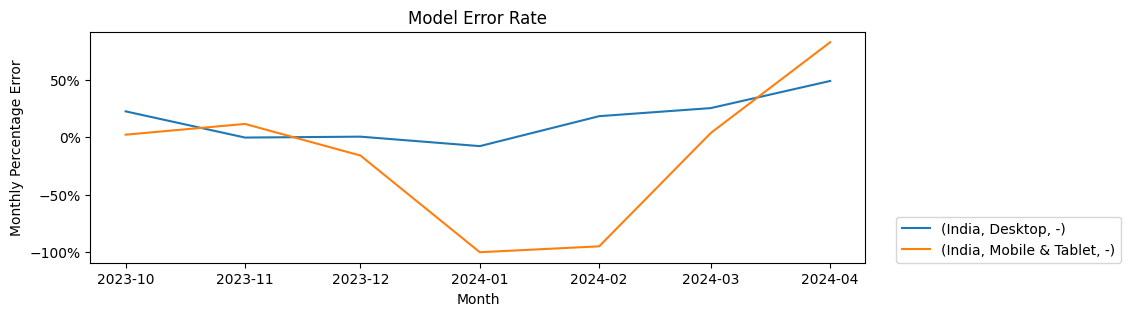

In [47]:
plot_printer = PlotAndSaveAccuracyDf()
fig = plot_printer.Plot(df_for_plt)
plot_name = "Accuracy_By_Month.jpg"
%load_ext autoreload
%autoreload 2

In [48]:
#fig.savefig(plot_name)
plot_printer.SaveToGCS(output_bucket,  plot_name, folder_name)

ups_bj_cost_by_device_optimization/India/reg/jun_2024_upd/Accuracy_By_Month.jpg
Image saved: ups_bj_cost_by_device_optimization/India/reg/jun_2024_upd/Accuracy_By_Month.jpg


In [40]:
# min_score = grid_competitor[(grid_competitor['account_type'] == 'Bing Ads')&(grid_competitor['funnel'] == 'Competitor')]['MAPE'].min()

# best_setting_df = grid_competitor[(grid_competitor['account_type'] == 'Bing Ads')&(grid_competitor['funnel'] == 'Competitor')\
#                                           &(grid_competitor['MAPE'] == min_score)]

In [22]:
# search_engine = ProphetParameterSearch()
# search_engine.add_power_params(num=5)
# df1, df2 = search_engine.search(cuts_df, df_filled)
# df2.to_csv('best_setting_df.csv')
# df1.to_csv('all_setting_result_acc_df.csv')  

In [23]:
# new_cuts_df = pd.read_csv('US Model Setting.csv')
# cuts_df_col_ls = ['market', 'account_type', 'funnel', 'starting_date', 'cutoff_month', 'periods', 'periods_for_acc_cal']
# new_cuts_df = new_cuts_df.merge(cuts_df[cuts_df_col_ls], how = 'left', on = ['market', 'account_type', 'funnel'])

# new_cuts_df.to_csv(config_dict['CLIENTINFO']['country'] + ' Breakdown.csv')
# generator = BreakdownSettingFileGenerator()
# new_cuts_df = generator.Generate(daily_df, config_dict, new_cuts_df)
# new_cuts_df = generator.Update()
# generator.SaveFile(bucket_name, folder_name, 'cuts_df.csv')
# new_cuts_df

In [24]:
# new_cuts_df.to_csv('cuts_df.csv')

In [42]:
# calculator = AccuracyCalculator()
# accuracy_df = calculator.CalculateAccuracy(new_cuts_df, df, query_item_list)
# # %load_ext autoreload
# # %autoreload 2
# calculator.SaveFile(bucket_name, folder_name, 'Finalized Model Score.csv')
# accuracy_df

In [58]:
# import json
# param_search_dict = {'power': 5,
#                      'growth': ['linear', 'logistic', 'power'],
#                     'seasonality_mode': ['additive', 'multiplicative'],
#                     'input_mode': ['additive', 'multiplicative'],
#                     'include_holiday': ['NA', 'Custom', 'Default'],
#                     'weekday_or_weekend': ['NA', 'additive', 'multiplicative'],
#                     'covid_year_exclude': ['Exclude', 'na'],
#                     'covid_year_dummy': ['NA', 'additive', 'multiplicative'],
#                     'anomaly_2021':['NA', 'additive', 'multiplicative'],
#                     }
# with open("param serach.json", "w") as outfile:
#     json.dump(param_search_dict, outfile)

In [59]:
# param_search_f = open("param serach.json")
# param_search_dict = json.load(param_search_f)
# power_number = int(param_search_dict['power']) 
# param_search_dict = {k: v for i, (k, v) in enumerate(param_search_dict.items()) if i > 1}
# power_number, param_search_dict

In [60]:
# import itertools
# list(itertools.product(*param_search_dict.values()))
# list(param_search_dict.keys())

# Model Generator

In [18]:
# %load_ext autoreload
# %autoreload 2
# model_generator = GenerateModelFile()
# model_generator.Generate(cuts_df, df_filled, query_item_list, output_bucket, folder_name)

# %load_ext autoreload
# %autoreload 
model_generator = GenerateModelFile()
model_generator.Generate(cuts_df, df_filled , query_item_list, output_bucket, folder_name, base_path=base_path)

/opt/conda/lib/python3.10/site-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
03:58:54 - cmdstanpy - INFO - Chain [1] start processing
03:58:54 - cmdstanpy - INFO - Chain [1] done processing
03:58:55 - cmdstanpy - INFO - Chain [1] start processing
03:58:55 - cmdstanpy - INFO - Chain [1] done processing


# Constraint Setting

In [14]:
bounds = cuts_df.copy()
bounds['MinWeight'] = 0.8
bounds['MaxWeight'] = 1.2
bounds

# %load_ext autoreload
# %autoreload 2
constraint_file_generator = ConstraintFileGenerator(config_dict, analytical_file_df)
constraint_file = constraint_file_generator.Generate(bounds)
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MinWeight'] = 0.9
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MaxWeight'] = 1.0
constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name)

Data Frame file saved


In [20]:
#constraint_file.to_csv('Constrain File.csv')
#constrain_file_generator.SaveFile(output_bucket, folder_name, 'Constraint File.csv')

In [21]:
df_filled[(df_filled.ds>='2024-01-01')&(df_filled.ds<='2024-01-10')].groupby(by='region').sum(numeric_only=1)

,X,y,weekday_or_weekend,floor,AOV,ROAS,cap
region,,,,,,,
EMEA,12757.95,1339.0,4,0,1597.410979,188.279127,1771.528473


In [29]:
# # cuts_df.loc[5, 'growth'] = 'linear'
# for i in cuts_df.itertuples():
#     pass

# import pickle
# from repo.Accuracy import MakeFuture
# file_name = "UK Mobile & Tablet -.pkl"
# pickle_file_path = base_path + file_name
# pickle_in = open(pickle_file_path,'rb') 
# # unpickled model is the model to use, training_dataset is used to get historical spend
# unpickled_model, training_dataset, model_df = pickle.load(pickle_in)

# analytical_file_copy = analytical_file_df.copy()
# market = 'UK'
# account_type = 'Mobile & Tablet'
# funnel = '-'

# spend_df_for_forecast = analytical_file_copy[(analytical_file_copy['market'] == market) & (analytical_file_copy['account_type'] == account_type) & \
#                                              (analytical_file_copy['funnel'] == funnel)].copy()
# spend_df_for_forecast['ds'] = pd.to_datetime(spend_df_for_forecast.ds)

# future = MakeFuture(unpickled_model, training_dataset, i, 183, spend_df_for_forecast)
# # print(training_dataset.ds.max(), i)
# forecast = unpickled_model.predict(future)
# unpickled_model.plot_components(forecast)

# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(unpickled_model, forecast)